In [1]:
# conda environment (project)
# /home/student/.conda/envs/project/bin/python 
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import os, gc
import torch

from transformers import set_seed
from datasets import load_dataset
from evaluate import *
from arc.arc import ARCSolver

from datasets import Dataset
from utils import render_grid

[2025-07-21 23:05:12,537] [INFO] [real_accelerator.py:254:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


In [2]:
# prepare the test dataset
data_path = "dataset"
dataset, task_list = load_data(data_path)
df300 = sample_data(dataset, task_list, n_row=30000, random=112) 
df300.head(5) 

Imported 300 different tasks in the dataset.
# of samples in a task: min(82), Q1(1000), Q2(1000), Q3(1000), max(1000), mean(897.7)


,task,train,test_input,test_output,test
0,e8dc4411,"[{'input': [[7, 7, 7, 7, 7, 7, 7, 7, 7], [7, 7...","[{'input': [[4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4...","[[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4,...","[{'input': [[4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [4..."
1,673ef223,"[{'input': [[5, 5, 5, 5, 5, 5, 3, 3], [5, 5, 5...","[{'input': [[8, 8, 8, 8, 7, 7, 7, 7, 8], [8, 8...","[[[9, 8, 8, 9, 7, 7, 7, 7, 8], [9, 8, 8, 9, 9,...","[{'input': [[8, 8, 8, 8, 7, 7, 7, 7, 8], [8, 8..."
2,b60334d2,"[{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0...","[{'input': [[7, 7, 7, 7, 7, 7, 7], [7, 7, 7, 7...","[[[7, 7, 7, 7, 6, 1, 6], [6, 1, 6, 7, 1, 7, 1]...","[{'input': [[7, 7, 7, 7, 7, 7, 7], [7, 7, 7, 7..."
3,5168d44c,"[{'input': [[7, 7, 7, 7, 7, 7, 7], [7, 7, 7, 7...","[{'input': [[4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4...","[[[4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4, 4, 4, 4,...","[{'input': [[4, 4, 4, 4, 4, 4, 4, 4], [4, 4, 4..."
4,c9e6f938,"[{'input': [[1, 1, 1]], 'output': [[1, 1, 1, 1...","[{'input': [[2, 2, 5, 2, 2], [2, 2, 5, 2, 2], ...","[[[2, 2, 5, 2, 2, 2, 2, 5, 2, 2], [2, 2, 5, 2,...","[{'input': [[2, 2, 5, 2, 2], [2, 2, 5, 2, 2], ..."


In [5]:
# prepare samples for each task
task_samples = []
for t in range(300):
    df = sample_data(dataset, task_list, n_row=1000, indices=[t])
    task_samples.append(df)

In [12]:
# Visualize a task (EDA)
task_indices = [1, 6, 8, 10, 13, 15, 17] # select which task you want to examine
#task_indices = [10] # select which task you want to examine
n_sample = 1
for task_idx in task_indices:
    print(task_idx)
    #print(len(Dataset.from_pandas(task_samples[task_idx])))
    for data in Dataset.from_pandas(task_samples[task_idx]).shuffle().select(range(n_sample)):
        for case in data['train']:
            print("==================================================")
            print("Example input")
            render_grid(case['input'])
            print("Example output")
            render_grid(case['output'])
            break
        print("==================================================")
        print("Example test input")
        render_grid(data['test'][0]['input'])
        print("Example test output")
        render_grid(data['test'][0]['output'])
    print("==================================================")

1
Example input


                      [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
                      [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
                      [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
                      [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
                      [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
                      [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
                      [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
                      [9, 9, 9, 9, 9, 9, 9, 9, 9, 2]

Example output


                      [8, 8, 2, 8, 8, 8, 8, 8, 8, 8]
                      [8, 2, 8, 2, 8, 8, 8, 8, 8, 8]
                      [2, 8, 8, 8, 2, 8, 8, 8, 8, 8]
                      [8, 8, 8, 8, 8, 2, 8, 8, 8, 8]
                      [8, 8, 8, 8, 8, 8, 2, 8, 8, 8]
                      [8, 8, 8, 8, 8, 8, 8, 2, 8, 8]
                      [8, 8, 8, 8, 8, 8, 8, 8, 2, 8]
                      [8, 8, 8, 8, 8, 8, 8, 8, 8, 2]

Example test input


          [6, 9, 9, 6]
          [9, 9, 9, 9]
          [9, 9, 9, 9]
          [9, 9, 9, 9]
          [9, 9, 9, 9]
          [9, 9, 9, 9]
          [9, 9, 9, 9]
          [9, 9, 9, 9]
          [9, 9, 9, 6]

Example test output


          [6, 6, 8, 6]
          [8, 6, 6, 8]
          [8, 6, 6, 6]
          [6, 8, 6, 6]
          [8, 6, 6, 8]
          [6, 6, 6, 8]
          [6, 6, 8, 6]
          [8, 6, 6, 8]
          [8, 6, 6, 6]

6
Example input


            [0, 7, 4, 0, 3]
            [7, 0, 4, 3, 3]
            [7, 7, 4, 3, 3]
            [7, 7, 4, 3, 3]
            [7, 7, 4, 3, 3]
            [7, 7, 4, 3, 0]
            [7, 0, 4, 3, 3]

Example output


      [0, 2]
      [2, 0]
      [2, 2]
      [2, 2]
      [2, 2]
      [2, 0]
      [2, 0]

Example test input


                [0, 0, 0, 3, 0, 0, 0]
                [5, 0, 0, 3, 5, 0, 0]

Example test output


        [0, 0, 0]
        [2, 0, 0]

8
Example input


                      [7, 7, 2, 2, 2, 7, 7, 2, 7, 7]
                      [2, 7, 7, 7, 7, 7, 7, 7, 7, 7]
                      [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
                      [7, 7, 6, 6, 6, 7, 7, 7, 7, 7]
                      [2, 7, 6, 6, 6, 7, 7, 7, 7, 7]
                      [2, 7, 6, 6, 6, 7, 7, 7, 7, 7]
                      [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
                      [7, 7, 7, 7, 2, 7, 2, 7, 7, 7]
                      [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]

Example output


                      [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
                      [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
                      [7, 2, 2, 2, 2, 2, 7, 7, 7, 7]
                      [7, 7, 6, 6, 6, 7, 7, 7, 7, 7]
                      [7, 2, 6, 6, 6, 7, 7, 7, 7, 7]
                      [7, 2, 6, 6, 6, 7, 7, 7, 7, 7]
                      [7, 7, 7, 7, 2, 2, 7, 7, 7, 7]
                      [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
                      [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]

Example test input


                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [7, 2, 3, 3, 3, 2, 2, 2]
                  [2, 2, 3, 3, 3, 2, 2, 2]
                  [7, 2, 3, 3, 3, 2, 2, 7]
                  [7, 2, 3, 3, 3, 2, 2, 2]
                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [2, 2, 2, 2, 2, 2, 2, 2]

Example test output


                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [2, 7, 3, 3, 3, 2, 2, 2]
                  [2, 2, 3, 3, 3, 2, 2, 2]
                  [2, 7, 3, 3, 3, 7, 2, 2]
                  [2, 7, 3, 3, 3, 2, 2, 2]
                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [2, 2, 2, 2, 2, 2, 2, 2]

10
Example input


              [1, 1, 1, 1, 1, 3]
              [7, 7, 1, 0, 0, 1]
              [1, 1, 1, 1, 3, 1]
              [1, 1, 0, 1, 0, 1]
              [1, 1, 1, 1, 1, 3]
              [2, 1, 1, 1, 1, 1]
              [1, 7, 7, 3, 1, 0]
              [1, 3, 1, 1, 1, 1]

Example output


              [1, 1, 1, 1, 1, 1]
              [1, 1, 1, 1, 1, 1]
              [1, 1, 1, 1, 1, 1]
              [1, 1, 1, 1, 1, 1]
              [2, 2, 1, 1, 1, 1]
              [2, 2, 1, 1, 1, 1]
              [2, 2, 1, 1, 1, 1]
              [1, 1, 1, 1, 1, 1]

Example test input


            [8, 7, 9, 9, 2]
            [9, 0, 9, 9, 9]
            [9, 9, 8, 4, 9]
            [4, 0, 7, 9, 9]
            [2, 5, 4, 9, 8]
            [8, 9, 9, 8, 0]
            [8, 9, 6, 9, 5]
            [7, 9, 9, 9, 7]
            [9, 2, 2, 9, 5]
            [5, 5, 9, 9, 0]

Example test output


            [9, 9, 9, 9, 9]
            [9, 9, 9, 9, 9]
            [9, 9, 9, 9, 9]
            [9, 9, 9, 9, 9]
            [9, 9, 9, 9, 9]
            [9, 2, 2, 2, 9]
            [9, 2, 6, 2, 9]
            [9, 2, 2, 2, 9]
            [9, 9, 9, 9, 9]
            [9, 9, 9, 9, 9]

13


Example input


            [1, 1, 1, 4, 1]
            [1, 0, 1, 7, 1]
            [1, 0, 1, 0, 1]
            [1, 0, 0, 0, 1]
            [1, 1, 1, 1, 1]
            [1, 0, 0, 0, 0]
            [1, 0, 1, 1, 1]
            [1, 0, 1, 0, 1]
            [1, 1, 1, 0, 1]

Example output


            [1, 1, 1, 4, 1]
            [1, 7, 1, 7, 1]
            [1, 4, 1, 4, 1]
            [1, 7, 4, 7, 1]
            [1, 1, 1, 1, 1]
            [1, 0, 0, 0, 0]
            [1, 0, 1, 1, 1]
            [1, 0, 1, 0, 1]
            [1, 1, 1, 0, 1]

Example test input


                    [8, 8, 8, 8, 8, 8, 8, 3, 8]
                    [8, 3, 3, 3, 3, 3, 8, 3, 8]
                    [8, 3, 8, 8, 8, 4, 8, 3, 8]
                    [8, 3, 8, 3, 8, 0, 8, 3, 8]
                    [8, 3, 8, 3, 8, 8, 8, 8, 8]

Example test output


                    [8, 8, 8, 8, 8, 8, 8, 3, 8]
                    [8, 0, 4, 0, 4, 0, 8, 3, 8]
                    [8, 4, 8, 8, 8, 4, 8, 3, 8]
                    [8, 0, 8, 3, 8, 0, 8, 3, 8]
                    [8, 4, 8, 3, 8, 8, 8, 8, 8]

15
Example input


                  [5, 5, 5, 5, 5, 6, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 4, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]

Example output


                  [5, 5, 5, 5, 5, 6, 5, 5]
                  [5, 5, 5, 6, 6, 6, 6, 6]
                  [5, 5, 5, 6, 5, 5, 5, 6]
                  [5, 5, 5, 4, 5, 5, 5, 4]
                  [5, 5, 5, 4, 4, 4, 4, 4]
                  [5, 5, 5, 5, 5, 4, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]

Example test input


                [8, 8, 8, 8, 8, 8, 8]
                [8, 8, 8, 8, 8, 8, 8]
                [8, 8, 8, 8, 8, 8, 8]
                [0, 8, 8, 8, 8, 5, 8]
                [8, 8, 8, 8, 8, 8, 8]
                [8, 8, 8, 8, 8, 8, 8]
                [8, 8, 8, 8, 8, 8, 8]

Example test output


                [8, 8, 8, 8, 8, 8, 8]
                [8, 0, 0, 5, 5, 8, 8]
                [8, 0, 8, 8, 5, 8, 8]
                [0, 0, 8, 8, 5, 5, 8]
                [8, 0, 8, 8, 5, 8, 8]
                [8, 0, 0, 5, 5, 8, 8]
                [8, 8, 8, 8, 8, 8, 8]

17
Example input


                      [6, 6, 8, 0, 7, 7, 0, 8, 6, 6]
                      [6, 8, 1, 6, 8, 8, 6, 1, 8, 6]
                      [8, 1, 2, 4, 6, 6, 4, 2, 1, 8]
                      [0, 6, 4, 8, 8, 8, 8, 4, 6, 0]
                      [7, 8, 3, 3, 3, 9, 8, 6, 8, 7]
                      [7, 8, 6, 8, 9, 9, 8, 6, 8, 7]
                      [0, 6, 4, 8, 8, 8, 8, 4, 6, 0]
                      [8, 1, 2, 4, 6, 6, 4, 2, 1, 8]
                      [6, 8, 1, 6, 8, 8, 6, 1, 8, 6]
                      [6, 6, 8, 0, 7, 7, 0, 8, 6, 6]

Example output


        [6, 8, 9]

Example test input


                      [1, 1, 9, 9, 9, 9, 9, 9, 1, 1]
                      [1, 2, 2, 2, 9, 9, 2, 2, 2, 1]
                      [9, 2, 9, 9, 9, 9, 9, 9, 2, 9]
                      [9, 2, 9, 9, 9, 9, 9, 9, 2, 9]
                      [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
                      [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
                      [9, 2, 9, 9, 9, 9, 9, 9, 2, 9]
                      [9, 2, 9, 3, 3, 9, 9, 9, 2, 9]
                      [1, 2, 2, 3, 3, 9, 2, 2, 2, 1]
                      [1, 1, 9, 9, 9, 9, 9, 9, 1, 1]

Example test output


      [9, 9]
      [2, 9]

In [9]:
simple_tasks = []
hard_tasks = []
for task_idx in range(300):
    check = True
    for data in Dataset.from_pandas(task_samples[task_idx]).shuffle().select(range(3)):
        for case in data['train']:
            wi, hi = len(case['input'][0]), len(case['input'])
            wo, ho = len(case['output'][0]), len(case['output'])
            if (wi!=wo) or (hi!=ho): check = False
        case = data['test'][0]
        wi, hi = len(case['input'][0]), len(case['input'])
        wo, ho = len(case['output'][0]), len(case['output'])
        if (wi!=wo) or (hi!=ho): check = False
    if check: simple_tasks.append(task_idx)
    else: hard_tasks.append(task_idx)
print(simple_tasks)

[0, 1, 3, 7, 8, 9, 10, 11, 13, 15, 18, 19, 20, 22, 27, 29, 30, 32, 33, 34, 35, 38, 40, 41, 44, 45, 46, 51, 52, 54, 55, 56, 57, 58, 61, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 78, 79, 80, 81, 83, 85, 87, 89, 90, 91, 92, 93, 95, 97, 98, 99, 100, 101, 102, 104, 105, 106, 107, 110, 111, 113, 114, 116, 117, 118, 119, 120, 123, 124, 128, 129, 130, 133, 135, 137, 138, 139, 140, 141, 142, 143, 145, 147, 148, 150, 151, 153, 154, 155, 157, 158, 159, 160, 161, 162, 166, 167, 169, 170, 172, 173, 174, 175, 176, 177, 178, 179, 181, 182, 185, 188, 190, 193, 194, 195, 196, 197, 198, 201, 203, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 218, 220, 222, 224, 225, 226, 227, 228, 230, 231, 233, 234, 235, 236, 239, 244, 245, 246, 248, 249, 250, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 264, 267, 268, 270, 271, 273, 274, 275, 276, 277, 281, 282, 285, 286, 287, 291, 292, 293, 295, 296, 297]


In [4]:
set_seed(1234567890)
token = os.environ.get("HF_TOKEN", None)
solver = ARCSolver(model_id="Qwen/Qwen3-1.7B", hf_token=token)

In [6]:
solver.prepare_train()
n_train = 30000
n_eval = 500
#dfsimple = sample_data(dataset, task_list, n_row=n_train+n_eval, indices=simple_tasks, random=56)
#dfhard = sample_data(dataset, task_list, n_row=n_train+n_eval, indices=hard_tasks, random=56)
train_dataset = Dataset.from_pandas(df300).select(range(n_train))
solver.train_rlvr(train_dataset,  checkpoint="20250709_120108/checkpoint-final")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

{'task': 'e8dc4411', 'train': [{'input': [[7, 7, 7, 7, 7, 7, 7, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7], [7, 7, 7, 7, 7, 8, 8, 8, 7], [7, 7, 7, 7, 7, 8, 8, 8, 7], [7, 7, 7, 7, 7, 8, 8, 8, 7], [7, 7, 7, 7, 2, 7, 7, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7]], 'output': [[7, 7, 7, 7, 7, 7, 7, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 7], [7, 7, 7, 7, 7, 8, 8, 8, 7], [7, 7, 7, 7, 7, 8, 8, 8, 7], [7, 7, 7, 7, 7, 8, 8, 8, 7], [7, 7, 2, 2, 2, 7, 7, 7, 7], [7, 7, 2, 2, 2, 7, 7, 7, 7], [7, 7, 2, 2, 2, 7, 7, 7, 7], [2, 2, 7, 7, 7, 7, 7, 7, 7]]}, {'input': [[9, 9, 9, 9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 9, 9, 5, 9, 9, 9, 9], [9, 9, 9, 9, 5, 5, 5, 9, 9, 9], [9, 9, 9, 9, 9, 5, 9, 6, 9, 9], [9, 9, 9, 9, 9, 9, 6, 9, 9, 9], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9], [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]], 'output': [[9, 9, 9, 9, 9, 9, 9,

AssertionError: 

In [27]:
n_eval = 100
solver.prepare_evaluation(select_adapter="20250709_120108") # make sure you set the right model

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [30]:
# evaluate our model (eval set)
scores = []
scores_max = []
n_eval = 20
ttt = True
task_indices = [6,8,9,10,13,14,15,17] 
scores_task = []
scores_max_task = []
for task in task_indices:
    eval_dataset = Dataset.from_pandas(task_samples[task]).select(range(n_eval))

    for eval_data in tqdm(eval_dataset):
        print("============================================")
        print("Test input")
        render_grid(eval_data["test"][0]['input'])

        print("Predict output")
        if ttt: solver.train_testtime(eval_data) # TTT
        preds, candidate_scores = [], []
        for _ in range(10):
            p, cs = solver.predict(eval_data, use_ttt=ttt, return_score=True)
            dup = -1
            for i, q in enumerate(preds):
                if p.shape == q.shape and (p == q).all(): 
                    cs = np.log(np.exp(cs)+np.exp(candidate_scores[i]))
                    dup = i; break 
            if dup == -1: 
                preds.append(p)
                candidate_scores.append(cs)
            else: candidate_scores[dup] = cs
            # render_grid(p)

        s, s_max, cs_max, i_max = 0, 0, float('-inf'), -1
        for i, p in enumerate(preds):
            if p is None: continue
            check = check_match(p, eval_data["test"][0]["output"])
            s_max = max(s_max, check)
            cs = candidate_scores[i]
            if cs > cs_max: 
                cs_max = cs; s = check; i_max = i
            if check: print("Here! vv")
            print(cs)
        scores.append(s)
        scores_max.append(s_max)
        print("Selected candidate")
        render_grid(preds[i_max])

        print("Test output")
        render_grid(eval_data["test"][0]['output'])
        print("============================================")

    score = np.array(scores).mean() * 100
    score_max = np.array(scores_max).mean() * 100
    scores_task.append(score)
    scores_max_task.append(score_max)
    print(f"Evaluation score: {score:.2f}", flush=True)
    print(f"Max Evaluation Score: {score_max:.2f}", flush=True)
    scores = []
    scores_max = []

  0%|          | 0/20 [00:00<?, ?it/s]

Test input


                    [0, 0, 5, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [9, 9, 9, 9, 9, 9, 9, 9, 9]
                    [0, 0, 7, 0, 7, 7, 0, 0, 0]
                    [7, 7, 7, 0, 7, 7, 7, 7, 7]
                    [0, 7, 0, 7, 0, 7, 7, 7, 0]
                    [0, 7, 7, 7, 7, 7, 7, 7, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.012900
20,0.012400
30,0.010700


-0.36983504186610916
-0.1624799642873847
-0.12103754200223016
-0.1835688357127876
0.6643910685885105
-0.11794325709342957
-0.18478838783567367
-0.038253218583438706
-0.1554946895779633
Selected candidate


                    [2 2 2 2 2 2 2 2 2]
                    [2 2 2 2 2 2 2 2 2]
                    [2 2 2 2 2 2 2 2 2]
                    [2 2 2 2 2 2 2 2 2]

Test output


                    [0, 0, 2, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]

Test input


            [0, 0, 3, 0, 0]
            [1, 0, 3, 0, 9]
            [0, 0, 3, 0, 0]
            [0, 0, 3, 0, 0]
            [0, 0, 3, 9, 0]
            [0, 1, 3, 0, 9]
            [0, 0, 3, 0, 9]
            [0, 0, 3, 9, 9]
            [0, 0, 3, 0, 0]
            [0, 1, 3, 9, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.008500
20,0.010000
30,0.008100


-0.08155538838717245
-0.44038787532237267
0.6212814447684305
-0.13511499233784213
-0.17323029527197714
-0.026026450337902192
Here! vv
-0.09894784394165744
-0.23570187632804332
-0.2620341508932736
Selected candidate


      [0 0]
      [0 2]
      [0 0]
      [0 0]
      [2 0]
      [0 2]
      [0 2]
      [2 2]
      [0 0]
      [2 0]

Test output


      [0, 0]
      [0, 0]
      [0, 0]
      [0, 0]
      [0, 0]
      [0, 2]
      [0, 0]
      [0, 0]
      [0, 0]
      [0, 0]

Test input


                [0, 1, 1, 9, 0, 0, 8]
                [0, 0, 1, 9, 8, 0, 0]
                [0, 0, 0, 9, 8, 0, 0]
                [0, 1, 1, 9, 0, 0, 0]
                [1, 0, 1, 9, 0, 0, 8]
                [0, 0, 1, 9, 8, 8, 8]
                [0, 1, 1, 9, 0, 8, 8]
                [1, 1, 0, 9, 0, 0, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.010200
20,0.009900
30,0.009600


0.6252135065932605
-0.16121278567747635
-0.33428618338491234
-0.242062559633544
-0.02634730056992599
-inf
-0.41949750389903784
-0.11625192190210025
-0.1695711323709199
Selected candidate


        [0 2 2]
        [0 0 2]
        [0 0 0]
        [0 2 2]
        [2 0 2]
        [0 0 2]
        [0 2 2]
        [2 2 0]

Test output


        [0, 0, 2]
        [0, 0, 0]
        [0, 0, 0]
        [0, 0, 0]
        [0, 0, 2]
        [0, 0, 2]
        [0, 2, 2]
        [0, 0, 0]

Test input


                    [0, 1, 1, 1, 1, 0, 0, 1, 1]
                    [0, 1, 0, 1, 0, 1, 1, 0, 1]
                    [0, 0, 0, 1, 1, 0, 0, 1, 1]
                    [0, 1, 1, 1, 1, 1, 1, 1, 1]
                    [9, 9, 9, 9, 9, 9, 9, 9, 9]
                    [0, 0, 6, 0, 0, 0, 6, 0, 0]
                    [0, 0, 0, 0, 6, 6, 6, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.013800
20,0.012900
30,0.015100


-0.03202640913102938
1.0754896813499626
-0.051612369352724494
-0.021615448853243954
-0.14950989186763763
-0.019740119576454163
-0.14734544550500264
-0.03879192835934784
Selected candidate


                    [0 0 0 0 0 0 0 0 0]
                    [0 0 0 0 0 0 0 0 0]
                    [0 0 0 0 0 0 0 0 0]
                    [0 0 0 0 0 0 0 0 0]

Test output


                    [0, 0, 2, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 2, 2, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]

Test input


                    [1, 1, 1, 0, 1, 1, 1, 1, 0]
                    [1, 1, 1, 1, 1, 1, 1, 1, 1]
                    [9, 9, 9, 9, 9, 9, 9, 9, 9]
                    [3, 3, 3, 3, 3, 3, 3, 0, 3]
                    [3, 3, 3, 3, 0, 3, 3, 3, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.022300
20,0.014900
30,0.015600


-0.14357059921271034
0.644872477983387
1.365261304817705
-0.14542546016829355
-0.1710657083562442
-0.13905755882816656
Selected candidate


                    [0 0 0 0 0 0 0 0 0]
                    [0 0 0 0 0 0 0 0 0]

Test output


                    [2, 2, 2, 0, 2, 2, 2, 0, 0]
                    [2, 2, 2, 2, 0, 2, 2, 2, 0]

Test input


          [0, 8, 0, 8]
          [0, 0, 0, 0]
          [0, 0, 0, 0]
          [0, 0, 8, 8]
          [9, 9, 9, 9]
          [0, 0, 6, 6]
          [0, 0, 0, 6]
          [6, 6, 0, 6]
          [6, 6, 0, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.010100
20,0.009300
30,0.006600


0.6778066875461343
0.5722651208885216
-0.2318738280307679
-0.10543259339673179
-0.22012901235194432
-0.11594089723768689
-0.128463916657936
-0.011801656622153062
Selected candidate


          [0 0 0 0]
          [0 0 0 0]
          [0 0 0 0]
          [0 0 0 0]

Test output


          [0, 0, 0, 2]
          [0, 0, 0, 0]
          [0, 0, 0, 0]
          [0, 0, 0, 0]

Test input


                [0, 7, 0, 6, 0, 3, 0]
                [7, 7, 7, 6, 3, 3, 0]
                [0, 0, 7, 6, 0, 0, 3]
                [7, 7, 7, 6, 0, 3, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.004900
20,0.002400
30,0.003300


Here! vv
-0.10238438006490469
-0.1889388070386999
-0.07571447780355811
0.6677227010946141
-0.039263841696083546
-0.07048577186651528
-0.19708754308521748
-0.18705491116270423
-0.10058463321012609
Selected candidate


        [0 2 0]
        [0 0 0]
        [0 0 0]
        [0 0 0]

Test output


        [0, 2, 0]
        [2, 2, 0]
        [0, 0, 2]
        [0, 2, 0]

Test input


            [0, 0, 4, 1, 1]
            [0, 0, 4, 1, 1]
            [0, 1, 4, 0, 1]
            [1, 1, 4, 1, 1]
            [0, 0, 4, 1, 1]
            [0, 0, 4, 0, 1]
            [0, 0, 4, 1, 1]
            [0, 0, 4, 1, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.011000
20,0.006500
30,0.004700


-0.11270437806844712
1.3065639001582474
-0.050317417830228806
-0.5972099949916204
-0.294500498591285
Here! vv
-0.09050740811385606
-0.13726358205080033
Selected candidate


      [0 0]
      [0 0]
      [0 0]
      [0 0]

Test output


      [0, 0]
      [0, 0]
      [0, 2]
      [2, 2]
      [0, 0]
      [0, 0]
      [0, 0]
      [0, 0]

Test input


                    [4, 4, 0, 4, 7, 0, 0, 0, 9]
                    [4, 4, 0, 4, 7, 0, 9, 0, 0]
                    [4, 4, 4, 4, 7, 9, 0, 0, 0]
                    [0, 0, 4, 4, 7, 9, 9, 0, 9]
                    [4, 4, 4, 4, 7, 9, 0, 0, 0]
                    [4, 4, 0, 4, 7, 0, 0, 0, 0]
                    [4, 4, 4, 4, 7, 0, 0, 0, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.014700
20,0.013700
30,0.012200


-0.06617070341275798
-0.25253407657146454
-0.1081844089138839
-0.07536521326336595
0.6377659407018109
-0.11281071515644298
-0.17903320581624002
-0.054416086731685534
-0.2396326462427775
Selected candidate


          [0 0 0 2]
          [0 2 0 0]
          [2 0 0 0]
          [2 2 0 2]
          [2 0 0 0]
          [0 0 0 0]
          [0 0 0 0]

Test output


          [0, 0, 0, 2]
          [0, 2, 0, 0]
          [2, 0, 0, 0]
          [0, 0, 0, 2]
          [2, 0, 0, 0]
          [0, 0, 0, 0]
          [0, 0, 0, 0]

Test input


                [0, 0, 0, 0, 0, 9, 9]
                [0, 9, 9, 9, 9, 0, 9]
                [9, 0, 0, 9, 0, 0, 9]
                [9, 9, 9, 0, 0, 9, 9]
                [3, 3, 3, 3, 3, 3, 3]
                [0, 8, 0, 8, 0, 0, 0]
                [8, 0, 0, 0, 0, 0, 0]
                [0, 0, 0, 0, 0, 8, 0]
                [0, 0, 0, 8, 0, 0, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.008700
20,0.012000
30,0.008500


-0.20137837835971048
-0.09580927186956008
-0.2045938339498308
Here! vv
-0.023838747518532204
-0.09483142580009168
-0.14956391188833448
-0.1787951907515526
-0.09149835424290763
-0.2865746218918098
-0.12718422152101994
Selected candidate


                [0 0 0 0 0 0 0]
                [0 0 0 0 0 0 0]
                [0 0 0 0 0 0 0]
                [0 0 0 0 0 0 0]

Test output


                [0, 0, 0, 0, 0, 0, 0]
                [0, 0, 0, 0, 0, 0, 0]
                [0, 0, 0, 0, 0, 0, 0]
                [0, 0, 0, 0, 0, 0, 0]

Test input


                    [5, 0, 0, 0, 5, 5, 5, 5, 5]
                    [5, 0, 5, 5, 0, 5, 0, 5, 0]
                    [1, 1, 1, 1, 1, 1, 1, 1, 1]
                    [3, 3, 3, 3, 3, 0, 0, 0, 3]
                    [3, 3, 0, 0, 0, 3, 0, 3, 3]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.010500
20,0.012100
30,0.007400


-0.16852568023438966
1.06772223280703
-0.4597443319283999
-0.07895991435417762
-0.020755192445170496
-0.11562055846055348
-0.11114827330623354
-0.05940336388136659
Selected candidate


                    [0 0 0 0 0 0 0 0 0]
                    [0 0 0 0 0 0 0 0 0]

Test output


                    [2, 0, 0, 0, 2, 0, 0, 0, 2]
                    [2, 0, 0, 0, 0, 2, 0, 2, 0]

Test input


                  [0, 9, 0, 9, 9, 9, 0, 9]
                  [9, 9, 9, 9, 0, 9, 9, 9]
                  [7, 7, 7, 7, 7, 7, 7, 7]
                  [0, 0, 0, 0, 0, 0, 0, 0]
                  [8, 0, 0, 0, 0, 0, 0, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.015000
20,0.013400
30,0.011000


1.05202551393218
-0.23841027954691335
-0.12044593542814255
-0.14502644695733724
-0.06609284742311998
-0.09306778719550685
-0.10342438327092113
-0.05726409726070635
Selected candidate


                  [0 0 0 0 0 0 0 0]
                  [0 0 0 0 0 0 0 0]

Test output


                  [0, 0, 0, 0, 0, 0, 0, 0]
                  [2, 0, 0, 0, 0, 0, 0, 0]

Test input


                    [0, 0, 0, 0, 8, 0, 0, 0, 0]
                    [0, 0, 0, 0, 8, 0, 0, 0, 0]
                    [0, 0, 4, 0, 8, 0, 7, 0, 0]
                    [4, 0, 4, 0, 8, 0, 0, 0, 0]
                    [4, 0, 0, 0, 8, 0, 0, 7, 0]
                    [0, 4, 4, 0, 8, 0, 0, 0, 0]
                    [0, 0, 0, 0, 8, 0, 0, 0, 0]
                    [0, 4, 0, 0, 8, 0, 7, 0, 0]
                    [0, 0, 0, 4, 8, 0, 0, 0, 0]
                    [0, 0, 0, 0, 8, 0, 0, 0, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.003900
20,0.004100
30,0.002400


1.092755219842728
0.663916414997842
1.085425615356551
0.6625426521223544
Selected candidate


          [0 0 0 0]
          [0 0 0 0]
          [0 0 0 0]
          [0 0 0 0]
          [0 0 0 0]
          [0 0 0 0]
          [0 0 0 0]
          [0 0 0 0]
          [0 0 0 2]
          [0 0 0 0]

Test output


          [0, 0, 0, 0]
          [0, 0, 0, 0]
          [0, 0, 0, 0]
          [0, 0, 0, 0]
          [0, 0, 0, 0]
          [0, 0, 0, 0]
          [0, 0, 0, 0]
          [0, 2, 0, 0]
          [0, 0, 0, 0]
          [0, 0, 0, 0]

Test input


                [0, 0, 9, 9, 0, 0, 0]
                [0, 0, 9, 0, 0, 0, 9]
                [0, 9, 0, 0, 0, 0, 0]
                [0, 0, 0, 0, 0, 0, 0]
                [6, 6, 6, 6, 6, 6, 6]
                [0, 0, 0, 0, 0, 0, 0]
                [0, 0, 0, 0, 7, 0, 0]
                [7, 7, 7, 0, 0, 7, 0]
                [0, 7, 0, 0, 7, 0, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.006500
20,0.005700
30,0.005800


1.7720031048711133
-0.07305052219068303
-0.10929881025933558
Here! vv
-0.07298912040211937
-0.03738110181358126
Selected candidate


                [0 0 0 0 0 0 0]
                [0 0 0 0 0 0 0]
                [0 0 0 0 0 0 0]
                [0 0 0 0 0 0 0]

Test output


                [0, 0, 0, 0, 0, 0, 0]
                [0, 0, 0, 0, 0, 0, 0]
                [0, 2, 0, 0, 0, 0, 0]
                [0, 0, 0, 0, 0, 0, 0]

Test input


                    [0, 0, 0, 0, 6, 5, 0, 0, 0]
                    [0, 0, 3, 0, 6, 0, 0, 0, 0]
                    [3, 0, 3, 0, 6, 0, 0, 0, 0]
                    [0, 3, 0, 0, 6, 0, 0, 0, 0]
                    [0, 0, 3, 0, 6, 0, 0, 0, 0]
                    [0, 0, 3, 0, 6, 0, 0, 0, 0]
                    [0, 3, 0, 3, 6, 0, 0, 0, 5]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.007600
20,0.006700
30,0.005600


Here! vv
-0.08345041413687998
-0.13532968217300045
1.9343519800817965
-0.0361884001529578
Selected candidate


          [0 0 0 0]
          [0 0 0 0]
          [0 0 0 0]
          [0 0 0 0]
          [0 0 0 0]
          [0 0 0 0]
          [0 0 0 0]

Test output


          [0, 0, 0, 0]
          [0, 0, 0, 0]
          [0, 0, 0, 0]
          [0, 0, 0, 0]
          [0, 0, 0, 0]
          [0, 0, 0, 0]
          [0, 0, 0, 2]

Test input


            [0, 0, 0, 0, 0]
            [0, 0, 0, 0, 0]
            [0, 8, 0, 0, 0]
            [3, 3, 3, 3, 3]
            [0, 0, 5, 0, 0]
            [0, 0, 5, 5, 0]
            [0, 0, 5, 5, 5]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.006800
20,0.006400
30,0.004500


-0.13772911225494586
Here! vv
1.9238579120795063
-0.12475036055995868
-0.03686251295240302
Selected candidate


            [0 0 0 0 0]
            [0 0 0 0 0]
            [0 0 0 0 0]

Test output


            [0, 0, 0, 0, 0]
            [0, 0, 0, 0, 0]
            [0, 0, 0, 0, 0]

Test input


            [5, 5, 4, 5, 0]
            [5, 5, 4, 0, 5]
            [5, 5, 4, 0, 0]
            [5, 0, 4, 0, 0]
            [5, 5, 4, 0, 0]
            [5, 5, 4, 0, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.013300
20,0.010500
30,0.009700


1.0620583016664893
0.55502047070121
-0.2709705844521523
Here! vv
-0.11993309031975896
-0.06504102026422819
-0.3817482699950536
-0.10597609042337067
Selected candidate


      [0 0]
      [0 0]
      [0 0]
      [0 0]
      [0 0]
      [0 0]

Test output


      [2, 0]
      [0, 2]
      [0, 0]
      [0, 0]
      [0, 0]
      [0, 0]

Test input


        [0, 5, 5]
        [0, 0, 5]
        [1, 1, 1]
        [3, 3, 3]
        [3, 0, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.010900
20,0.006700
30,0.006000


1.5517993901131537
-0.3675951245758269
-0.22117162164714602
-0.3076934681998359
-0.2638896942138672
-0.2909057777788904
Selected candidate


        [0 0 0]
        [0 0 0]

Test output


        [0, 2, 2]
        [0, 0, 0]

Test input


            [4, 0, 7, 3, 3]
            [4, 4, 7, 0, 0]
            [4, 4, 7, 3, 0]
            [0, 4, 7, 0, 3]
            [0, 0, 7, 0, 3]
            [4, 0, 7, 0, 3]
            [4, 4, 7, 0, 0]
            [4, 4, 7, 3, 3]
            [4, 4, 7, 3, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.009300
20,0.006200
30,0.007500


2.189740507102703
-0.11038260055439812
Selected candidate


      [0 0]
      [0 0]
      [0 0]
      [0 0]
      [0 0]
      [0 0]
      [0 0]
      [0 0]
      [0 0]

Test output


      [2, 0]
      [0, 0]
      [2, 0]
      [0, 2]
      [0, 0]
      [0, 0]
      [0, 0]
      [2, 2]
      [2, 0]

Test input


            [6, 6, 1, 0, 0]
            [6, 6, 1, 5, 0]
            [0, 0, 1, 0, 5]
            [6, 6, 1, 5, 5]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.006600
20,0.002800
30,0.002300


1.9095742471903496
-0.07110952413999118
-0.14857791789940425
-0.13135002152277872
Selected candidate


      [0 0]
      [0 0]
      [0 0]
      [0 0]

Test output


      [0, 0]
      [2, 0]
      [0, 0]
      [2, 2]

Evaluation score: 10.00
Max Evaluation Score: 40.00


  0%|          | 0/20 [00:00<?, ?it/s]

Test input


                    [8, 8, 2, 8, 2, 8, 8, 8, 8]
                    [8, 8, 8, 8, 8, 8, 8, 8, 8]
                    [2, 8, 0, 0, 0, 8, 8, 2, 8]
                    [8, 8, 0, 0, 0, 8, 2, 8, 8]
                    [2, 8, 0, 0, 0, 8, 8, 8, 8]
                    [2, 8, 0, 0, 0, 8, 8, 8, 8]
                    [8, 8, 8, 8, 8, 8, 8, 8, 8]
                    [2, 8, 8, 8, 8, 8, 8, 8, 8]
                    [8, 8, 2, 8, 2, 8, 8, 8, 8]
                    [8, 8, 8, 8, 8, 8, 8, 8, 8]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.028300
20,0.024000
30,0.020700


-0.07697361397861253
-0.017494549825787544
-0.05969146251826003
-0.06254922089600327
-0.06993936233222485
-0.014512740149356352
-0.0669771108031273
-0.04772248664999952
-0.06848548490554095
-0.034792518615722655
Selected candidate


                    [8 8 8 8 8 8 8 8 8]
                    [8 8 2 8 2 8 8 8 8]
                    [8 8 0 0 0 8 8 8 8]
                    [8 8 0 0 0 8 8 8 8]
                    [8 8 0 0 0 8 8 8 8]
                    [8 8 0 0 0 8 8 8 8]
                    [8 8 2 8 2 8 8 8 8]
                    [8 8 8 8 8 8 8 8 8]
                    [8 8 8 8 8 8 8 8 8]
                    [8 8 8 8 8 8 8 8 8]

Test output


                    [8, 8, 8, 8, 8, 8, 8, 8, 8]
                    [8, 8, 2, 8, 2, 8, 8, 8, 8]
                    [8, 2, 0, 0, 0, 2, 8, 8, 8]
                    [8, 8, 0, 0, 0, 2, 8, 8, 8]
                    [8, 2, 0, 0, 0, 8, 8, 8, 8]
                    [8, 2, 0, 0, 0, 8, 8, 8, 8]
                    [8, 2, 2, 8, 2, 8, 8, 8, 8]
                    [8, 8, 8, 8, 8, 8, 8, 8, 8]
                    [8, 8, 8, 8, 8, 8, 8, 8, 8]
                    [8, 8, 8, 8, 8, 8, 8, 8, 8]

Test input


                  [7, 1, 1, 1, 1, 1, 1, 1]
                  [1, 1, 1, 1, 1, 1, 7, 1]
                  [1, 1, 1, 1, 1, 1, 1, 1]
                  [1, 7, 1, 6, 6, 1, 1, 1]
                  [1, 1, 1, 6, 6, 1, 7, 1]
                  [1, 7, 1, 6, 6, 1, 1, 1]
                  [1, 1, 1, 1, 1, 1, 1, 1]
                  [1, 1, 1, 7, 7, 1, 7, 1]
                  [7, 1, 1, 1, 1, 1, 1, 1]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.026400
20,0.016000
30,0.024900


-0.032567521212277586
-0.0705815358768876
-0.04018983871835034
-0.03331988359369883
0.6660813602532177
-0.04884976671054596
1.0675535045232858
Selected candidate


                  [1 1 1 1 1 1 1 1]
                  [1 1 1 1 1 1 1 1]
                  [1 1 1 1 1 7 1 1]
                  [1 1 7 6 6 1 1 1]
                  [1 1 1 6 6 7 1 1]
                  [1 1 7 6 6 1 1 1]
                  [1 1 7 7 7 7 1 1]
                  [1 1 1 1 1 1 1 1]
                  [1 1 1 1 1 1 1 1]

Test output


                  [1, 1, 1, 1, 1, 1, 1, 1]
                  [1, 1, 1, 1, 1, 1, 1, 1]
                  [1, 1, 7, 1, 1, 7, 1, 1]
                  [1, 1, 7, 6, 6, 1, 1, 1]
                  [1, 1, 1, 6, 6, 7, 1, 1]
                  [1, 1, 7, 6, 6, 1, 1, 1]
                  [1, 1, 7, 7, 7, 7, 1, 1]
                  [1, 1, 1, 1, 1, 1, 1, 1]
                  [1, 1, 1, 1, 1, 1, 1, 1]

Test input


                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 9, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [9, 6, 8, 8, 6, 6, 6, 6, 6, 6]
                      [6, 6, 8, 8, 6, 6, 6, 6, 6, 6]
                      [6, 6, 8, 8, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 9, 9, 6, 6, 6, 6, 6, 6]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.029800
20,0.018500
30,0.018300


-0.036277702834346504
0.6788168062729081
0.6860728106509396
-0.02361356872733277
-0.05594341516494751
-0.02278676437269343
0.6770781956777286
Selected candidate


                      [6 6 6 6 6 6 6 6 6 6]
                      [6 6 6 6 6 6 6 6 6 6]
                      [6 6 6 9 6 6 6 6 6 6]
                      [6 9 8 8 9 6 6 6 6 6]
                      [6 6 8 8 6 6 6 6 6 6]
                      [6 6 8 8 6 6 6 6 6 6]
                      [6 6 9 9 6 6 6 6 6 6]
                      [6 6 6 6 6 6 6 6 6 6]
                      [6 6 6 6 6 6 6 6 6 6]

Test output


                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 9, 6, 6, 6, 6, 6, 6]
                      [6, 9, 8, 8, 6, 6, 6, 6, 6, 6]
                      [6, 6, 8, 8, 6, 6, 6, 6, 6, 6]
                      [6, 6, 8, 8, 6, 6, 6, 6, 6, 6]
                      [6, 6, 9, 9, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

Test input


                  [4, 7, 7, 4, 7, 4, 7, 7]
                  [7, 7, 7, 7, 7, 7, 7, 4]
                  [7, 7, 7, 7, 7, 7, 7, 7]
                  [7, 4, 7, 0, 0, 0, 7, 4]
                  [7, 4, 7, 0, 0, 0, 7, 4]
                  [7, 4, 7, 0, 0, 0, 7, 4]
                  [7, 7, 7, 7, 7, 7, 7, 7]
                  [7, 4, 7, 4, 4, 4, 7, 4]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.033300
20,0.020100
30,0.019400


-0.024330609210141716
-0.09424021727826497
-0.07695285373762863
0.6558133513026281
-0.05964956320311925
-0.10858564140045479
-0.07596420200720225
-0.018974696477390314
-0.11744988745410148
Selected candidate


                  [7 7 7 7 7 7 7 7]
                  [7 7 7 7 7 7 7 7]
                  [7 4 4 4 4 4 7 7]
                  [7 4 0 0 0 4 7 7]
                  [7 4 0 0 0 4 7 7]
                  [7 4 0 0 0 4 7 7]
                  [7 4 4 4 4 4 4 7]
                  [7 7 7 7 7 7 7 7]

Test output


                  [7, 7, 7, 7, 7, 7, 7, 7]
                  [7, 7, 7, 7, 7, 7, 7, 7]
                  [7, 7, 4, 4, 7, 4, 4, 7]
                  [7, 7, 4, 0, 0, 0, 4, 7]
                  [7, 7, 4, 0, 0, 0, 4, 7]
                  [7, 7, 4, 0, 0, 0, 4, 7]
                  [7, 7, 4, 4, 4, 4, 4, 7]
                  [7, 7, 7, 7, 7, 7, 7, 7]

Test input


                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 3, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 9, 9, 9, 6, 6, 6, 3, 6]
                      [6, 6, 9, 9, 9, 6, 6, 6, 6, 6]
                      [6, 6, 9, 9, 9, 6, 6, 6, 6, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 3, 3, 3, 6, 6, 3, 6, 6]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.024300
20,0.012800
30,0.006700


-0.01794597130637985
0.6789044335607878
-0.06262763861466099
-0.06271914855853931
-0.023004418155094526
-0.0132974002275381
-0.0427003292417204
-0.010236330431055379
-0.02041090548306972
Selected candidate


                      [6 6 6 6 6 6 6 6 6 6]
                      [6 6 6 6 6 6 6 6 6 6]
                      [6 6 6 6 6 6 6 6 6 6]
                      [6 6 6 3 6 6 6 6 6 6]
                      [6 6 9 9 9 6 6 3 6 6]
                      [6 6 9 9 9 6 6 6 6 6]
                      [6 6 9 9 9 6 6 6 6 6]
                      [6 6 6 6 6 6 6 6 6 6]
                      [6 6 6 3 3 3 6 3 6 6]
                      [6 6 6 6 6 6 6 6 6 6]

Test output


                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 3, 6, 6, 6, 6, 6, 6]
                      [6, 6, 9, 9, 9, 3, 6, 6, 6, 6]
                      [6, 6, 9, 9, 9, 6, 6, 6, 6, 6]
                      [6, 6, 9, 9, 9, 6, 6, 6, 6, 6]
                      [6, 6, 3, 3, 3, 3, 6, 6, 6, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

Test input


                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [5, 2, 5, 2, 2, 2, 2, 2]
                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [5, 2, 1, 1, 2, 2, 2, 2]
                  [2, 2, 1, 1, 2, 2, 2, 5]
                  [5, 2, 1, 1, 2, 2, 2, 5]
                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [5, 2, 5, 5, 2, 5, 2, 2]
                  [2, 2, 2, 2, 2, 2, 2, 2]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.026800
20,0.023300
30,0.018300


-0.056098428221396456
-0.10167117684897853
-0.09067296043590263
-0.027610781292120617
-0.08034754342135088
-0.022737197945883244
-0.061450214693095626
-0.10772630682698002
-0.12544222862073562
-0.056907760161088734
Selected candidate


                  [2 2 2 2 2 2 2 2]
                  [2 2 2 2 2 2 2 2]
                  [2 2 5 2 2 2 2 2]
                  [2 5 1 1 2 2 2 2]
                  [2 5 1 1 2 2 2 2]
                  [2 5 1 1 5 2 2 2]
                  [2 5 5 5 5 2 2 2]
                  [2 2 2 2 2 2 2 2]
                  [2 2 2 2 2 2 2 2]

Test output


                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [2, 5, 5, 2, 2, 2, 2, 2]
                  [2, 5, 1, 1, 2, 2, 2, 2]
                  [2, 2, 1, 1, 5, 2, 2, 2]
                  [2, 5, 1, 1, 5, 2, 2, 2]
                  [2, 5, 5, 5, 5, 2, 2, 2]
                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [2, 2, 2, 2, 2, 2, 2, 2]

Test input


                  [6, 6, 6, 6, 6, 6, 6, 6]
                  [6, 6, 6, 6, 6, 6, 6, 6]
                  [6, 6, 6, 6, 6, 6, 6, 6]
                  [6, 6, 6, 6, 6, 6, 6, 6]
                  [6, 6, 6, 3, 3, 6, 6, 5]
                  [6, 6, 6, 3, 3, 6, 6, 6]
                  [6, 6, 6, 3, 3, 6, 6, 6]
                  [6, 6, 6, 6, 6, 6, 6, 6]
                  [6, 6, 6, 6, 6, 6, 6, 6]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.033900
20,0.030700
30,0.020800


0.6808925085113898
Here! vv
1.3716063559416085
-0.012529810754264273
-0.02663413416824223
-0.05506650158544866
-0.03848329313644549
Selected candidate


                  [6 6 6 6 6 6 6 6]
                  [6 6 6 6 6 6 6 6]
                  [6 6 6 6 6 6 6 6]
                  [6 6 6 6 6 6 6 6]
                  [6 6 6 3 3 5 6 6]
                  [6 6 6 3 3 6 6 6]
                  [6 6 6 3 3 6 6 6]
                  [6 6 6 6 6 6 6 6]
                  [6 6 6 6 6 6 6 6]

Test output


                  [6, 6, 6, 6, 6, 6, 6, 6]
                  [6, 6, 6, 6, 6, 6, 6, 6]
                  [6, 6, 6, 6, 6, 6, 6, 6]
                  [6, 6, 6, 6, 6, 6, 6, 6]
                  [6, 6, 6, 3, 3, 5, 6, 6]
                  [6, 6, 6, 3, 3, 6, 6, 6]
                  [6, 6, 6, 3, 3, 6, 6, 6]
                  [6, 6, 6, 6, 6, 6, 6, 6]
                  [6, 6, 6, 6, 6, 6, 6, 6]

Test input


                      [0, 0, 0, 0, 8, 0, 8, 0, 0, 0]
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                      [0, 8, 0, 0, 2, 2, 2, 0, 8, 0]
                      [0, 0, 0, 0, 2, 2, 2, 0, 0, 8]
                      [0, 0, 8, 0, 2, 2, 2, 0, 0, 8]
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                      [0, 0, 0, 0, 0, 8, 8, 0, 8, 0]
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                      [0, 0, 0, 0, 8, 0, 0, 0, 0, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.033000
20,0.027700
30,0.023100


-0.09136814520795747
-0.036573590766085254
0.6832825087074532
-0.09903450627433191
-0.06422357629984617
-0.013026274925116266
-0.026445823546388362
-0.06392927087917186
-0.032557541670480576
Selected candidate


                      [0 0 0 0 0 0 0 0 0 0]
                      [0 0 0 0 8 0 8 0 0 0]
                      [0 0 0 0 2 2 2 8 0 0]
                      [0 0 0 0 2 2 2 8 0 0]
                      [0 0 0 0 2 2 2 8 0 0]
                      [0 0 0 0 0 0 0 0 0 0]
                      [0 0 0 0 0 0 0 0 0 0]
                      [0 0 0 0 0 0 0 0 0 0]
                      [0 0 0 0 0 0 0 0 0 0]

Test output


                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                      [0, 0, 0, 0, 8, 0, 8, 0, 0, 0]
                      [0, 0, 0, 8, 2, 2, 2, 8, 0, 0]
                      [0, 0, 0, 0, 2, 2, 2, 8, 0, 0]
                      [0, 0, 0, 8, 2, 2, 2, 8, 0, 0]
                      [0, 0, 0, 0, 8, 8, 8, 8, 0, 0]
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Test input


                    [3, 3, 3, 3, 3, 3, 3, 3, 3]
                    [9, 3, 3, 9, 3, 3, 9, 3, 3]
                    [3, 3, 3, 3, 3, 3, 3, 3, 3]
                    [9, 3, 7, 7, 7, 3, 3, 3, 3]
                    [9, 3, 7, 7, 7, 3, 9, 3, 3]
                    [3, 3, 7, 7, 7, 3, 3, 3, 3]
                    [3, 3, 3, 3, 3, 3, 3, 3, 3]
                    [9, 3, 3, 3, 3, 3, 9, 3, 3]
                    [3, 3, 9, 3, 9, 3, 3, 3, 3]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.029300
20,0.027300
30,0.016300


-0.03776083305314347
-0.029186896979808807
-0.07222233786360248
-0.027126728751502193
-0.045065430740078724
-0.030090943838541325
-0.08806069277145051
-0.05305838224652049
-0.056567882361647844
-0.05757987847203737
Selected candidate


                    [3 3 3 3 3 3 3 3 3]
                    [3 3 3 3 3 3 3 3 3]
                    [3 3 3 3 3 3 3 3 3]
                    [3 9 7 7 7 3 3 3 3]
                    [3 9 7 7 7 9 3 3 3]
                    [3 3 7 7 7 3 3 3 3]
                    [3 3 3 3 3 3 3 3 3]
                    [3 9 9 3 9 9 3 3 3]
                    [3 3 3 3 3 3 3 3 3]

Test output


                    [3, 3, 3, 3, 3, 3, 3, 3, 3]
                    [3, 3, 3, 3, 3, 3, 3, 3, 3]
                    [3, 9, 3, 9, 3, 9, 3, 3, 3]
                    [3, 9, 7, 7, 7, 3, 3, 3, 3]
                    [3, 9, 7, 7, 7, 9, 3, 3, 3]
                    [3, 3, 7, 7, 7, 3, 3, 3, 3]
                    [3, 9, 9, 3, 9, 9, 3, 3, 3]
                    [3, 3, 3, 3, 3, 3, 3, 3, 3]
                    [3, 3, 3, 3, 3, 3, 3, 3, 3]

Test input


                  [3, 4, 3, 4, 4, 3, 3, 4]
                  [3, 3, 3, 3, 3, 3, 3, 3]
                  [3, 4, 3, 5, 5, 5, 3, 3]
                  [3, 3, 3, 5, 5, 5, 3, 3]
                  [3, 3, 3, 5, 5, 5, 3, 4]
                  [4, 3, 3, 5, 5, 5, 3, 4]
                  [3, 3, 3, 5, 5, 5, 3, 4]
                  [3, 3, 3, 3, 3, 3, 3, 3]
                  [3, 3, 3, 4, 3, 3, 3, 4]
                  [3, 3, 3, 3, 3, 3, 3, 3]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.026900
20,0.016600
30,0.012400


-0.031014826271560166
-0.04254997325140041
-0.06263640832700086
-0.08044564048503781
-0.021152500523610063
-0.030540666218554037
-0.013368659809734045
-0.034053097305062056
-0.0211147672527439
-0.03758180964287821
Selected candidate


                  [3 3 3 3 3 3 3 3]
                  [3 3 3 4 4 3 3 3]
                  [3 3 4 5 5 5 4 3]
                  [3 3 4 5 5 5 4 3]
                  [3 3 4 5 5 5 4 3]
                  [3 3 4 5 5 5 4 3]
                  [3 3 3 5 5 5 4 3]
                  [3 3 3 4 3 3 4 3]
                  [3 3 3 3 3 3 3 3]
                  [3 3 3 3 3 3 3 3]

Test output


                  [3, 3, 3, 3, 3, 3, 3, 3]
                  [3, 3, 4, 4, 4, 3, 4, 3]
                  [3, 3, 4, 5, 5, 5, 3, 3]
                  [3, 3, 3, 5, 5, 5, 3, 3]
                  [3, 3, 3, 5, 5, 5, 4, 3]
                  [3, 3, 4, 5, 5, 5, 4, 3]
                  [3, 3, 3, 5, 5, 5, 4, 3]
                  [3, 3, 3, 4, 3, 3, 4, 3]
                  [3, 3, 3, 3, 3, 3, 3, 3]
                  [3, 3, 3, 3, 3, 3, 3, 3]

Test input


                    [4, 4, 4, 4, 4, 7, 4, 4, 4]
                    [4, 4, 4, 7, 4, 4, 4, 4, 4]
                    [4, 4, 4, 4, 4, 4, 4, 4, 4]
                    [4, 4, 4, 3, 3, 3, 4, 4, 7]
                    [4, 4, 4, 3, 3, 3, 4, 4, 4]
                    [4, 4, 4, 3, 3, 3, 4, 4, 4]
                    [4, 4, 4, 4, 4, 4, 4, 4, 4]
                    [4, 4, 4, 7, 4, 4, 4, 4, 4]
                    [7, 4, 4, 4, 4, 4, 4, 4, 4]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.026000
20,0.021800
30,0.015600


-0.030162066999045046
-0.009965479373931885
-0.048505347999897634
-0.034892287637506215
-0.0531168353672211
-0.0126799273785654
-0.0198315095442992
-0.047753096609325196
-0.021642376965546346
-0.013268206964482318
Selected candidate


                    [4 4 4 4 4 4 4 4 4]
                    [4 4 4 4 4 4 4 4 4]
                    [4 4 4 7 4 4 4 4 4]
                    [4 4 4 3 3 3 7 4 4]
                    [4 4 4 3 3 3 4 4 4]
                    [4 4 4 3 3 3 4 4 4]
                    [4 4 7 4 4 4 4 4 4]
                    [4 4 4 4 4 4 4 4 4]
                    [4 4 4 4 4 4 4 4 4]

Test output


                    [4, 4, 4, 4, 4, 4, 4, 4, 4]
                    [4, 4, 4, 4, 4, 4, 4, 4, 4]
                    [4, 4, 4, 7, 4, 7, 4, 4, 4]
                    [4, 4, 4, 3, 3, 3, 7, 4, 4]
                    [4, 4, 4, 3, 3, 3, 4, 4, 4]
                    [4, 4, 4, 3, 3, 3, 4, 4, 4]
                    [4, 4, 7, 7, 4, 4, 4, 4, 4]
                    [4, 4, 4, 4, 4, 4, 4, 4, 4]
                    [4, 4, 4, 4, 4, 4, 4, 4, 4]

Test input


                    [9, 9, 9, 9, 9, 9, 9, 9, 9]
                    [9, 9, 9, 9, 9, 9, 9, 9, 9]
                    [9, 9, 9, 9, 9, 9, 9, 9, 9]
                    [0, 9, 0, 9, 9, 9, 9, 9, 9]
                    [9, 9, 9, 9, 9, 9, 9, 9, 9]
                    [9, 9, 8, 8, 8, 8, 9, 9, 9]
                    [0, 9, 8, 8, 8, 8, 9, 9, 9]
                    [9, 9, 9, 9, 9, 9, 9, 9, 9]
                    [9, 9, 9, 9, 9, 9, 9, 9, 9]
                    [9, 9, 9, 9, 9, 9, 9, 9, 9]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.022600
20,0.018900
30,0.013600


0.6659858018677598
-0.020210872367024423
0.6753713770437774
-0.031151063555833136
-0.02654266091856626
-0.015305080404966184
Here! vv
-0.010738628283143044
-0.02103107924213504
Selected candidate


                    [9 9 9 9 9 9 9 9 9]
                    [9 9 9 9 9 9 9 9 9]
                    [9 9 9 9 9 9 9 9 9]
                    [9 9 9 9 9 9 9 9 9]
                    [9 9 9 9 9 9 9 9 9]
                    [9 9 8 8 8 8 9 9 9]
                    [9 0 8 8 8 8 9 9 9]
                    [9 9 9 9 9 9 9 9 9]
                    [9 9 9 9 9 9 9 9 9]
                    [9 9 9 9 9 9 9 9 9]

Test output


                    [9, 9, 9, 9, 9, 9, 9, 9, 9]
                    [9, 9, 9, 9, 9, 9, 9, 9, 9]
                    [9, 9, 9, 9, 9, 9, 9, 9, 9]
                    [9, 9, 9, 9, 9, 9, 9, 9, 9]
                    [9, 0, 0, 9, 9, 9, 9, 9, 9]
                    [9, 9, 8, 8, 8, 8, 9, 9, 9]
                    [9, 0, 8, 8, 8, 8, 9, 9, 9]
                    [9, 9, 9, 9, 9, 9, 9, 9, 9]
                    [9, 9, 9, 9, 9, 9, 9, 9, 9]
                    [9, 9, 9, 9, 9, 9, 9, 9, 9]

Test input


                    [2, 2, 2, 2, 0, 0, 2, 2, 0]
                    [2, 2, 2, 2, 2, 2, 2, 2, 2]
                    [2, 2, 2, 2, 2, 2, 2, 2, 2]
                    [2, 2, 2, 5, 5, 5, 2, 0, 2]
                    [2, 2, 2, 5, 5, 5, 2, 2, 2]
                    [2, 2, 2, 5, 5, 5, 2, 2, 2]
                    [2, 2, 2, 5, 5, 5, 2, 2, 2]
                    [0, 2, 2, 5, 5, 5, 2, 2, 2]
                    [2, 2, 2, 2, 2, 2, 2, 2, 2]
                    [2, 2, 2, 0, 0, 2, 2, 2, 2]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.027400
20,0.020400
30,0.020300


-0.040257885679602624
-0.05371617887279775
-0.021004925668239593
-0.007248322367668152
-0.016319599924701274
-0.03138270900391116
-0.0197217519773115
-0.01718403679309505
-0.02728927393655966
-0.05598097925286482
Selected candidate


                    [2 2 2 2 2 2 2 2 2]
                    [2 2 2 2 2 2 2 2 2]
                    [2 2 2 2 0 0 2 2 2]
                    [2 2 2 5 5 5 2 2 2]
                    [2 2 2 5 5 5 2 2 2]
                    [2 2 2 5 5 5 2 2 2]
                    [2 2 2 5 5 5 2 2 2]
                    [2 2 0 5 5 5 2 2 2]
                    [2 2 2 2 2 2 2 2 2]
                    [2 2 2 2 2 2 2 2 2]

Test output


                    [2, 2, 2, 2, 2, 2, 2, 2, 2]
                    [2, 2, 2, 2, 2, 2, 2, 2, 2]
                    [2, 2, 2, 2, 0, 0, 0, 2, 2]
                    [2, 2, 2, 5, 5, 5, 0, 2, 2]
                    [2, 2, 2, 5, 5, 5, 2, 2, 2]
                    [2, 2, 2, 5, 5, 5, 2, 2, 2]
                    [2, 2, 2, 5, 5, 5, 2, 2, 2]
                    [2, 2, 0, 5, 5, 5, 2, 2, 2]
                    [2, 2, 2, 0, 0, 2, 2, 2, 2]
                    [2, 2, 2, 2, 2, 2, 2, 2, 2]

Test input


                    [6, 6, 6, 6, 6, 6, 6, 2, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 8, 8, 6, 6, 6]
                    [6, 6, 6, 6, 8, 8, 6, 6, 6]
                    [6, 6, 2, 6, 8, 8, 6, 6, 6]
                    [6, 6, 6, 6, 8, 8, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 2, 6, 6, 2, 6, 2, 6]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.035800
20,0.033700
30,0.021600


-0.016359453066820052
-0.024870424542898013
-0.04880612538900317
-0.030483234535764764
-0.04153410272627342
-0.04865134734569526
-0.08136120456747892
Here! vv
-0.04287558196135509
-0.04229182156699675
-0.03463011460355771
Selected candidate


                    [6 6 6 6 6 6 6 6 6]
                    [6 6 6 6 6 6 6 6 6]
                    [6 6 6 6 8 8 6 6 6]
                    [6 6 6 6 8 8 6 6 6]
                    [6 6 6 2 8 8 6 6 6]
                    [6 6 6 6 8 8 6 6 6]
                    [6 6 6 2 6 2 2 6 6]
                    [6 6 6 6 6 6 6 6 6]

Test output


                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 2, 6, 6]
                    [6, 6, 6, 6, 8, 8, 6, 6, 6]
                    [6, 6, 6, 6, 8, 8, 6, 6, 6]
                    [6, 6, 6, 2, 8, 8, 6, 6, 6]
                    [6, 6, 6, 6, 8, 8, 6, 6, 6]
                    [6, 6, 6, 2, 6, 2, 2, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]

Test input


                  [2, 2, 2, 5, 2, 2, 2, 2]
                  [5, 2, 2, 2, 5, 2, 2, 2]
                  [2, 2, 2, 2, 2, 5, 2, 5]
                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [2, 2, 2, 4, 4, 4, 2, 2]
                  [2, 2, 2, 4, 4, 4, 2, 5]
                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [2, 2, 2, 5, 2, 5, 2, 5]
                  [2, 2, 2, 2, 5, 2, 2, 2]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.024600
20,0.018700
30,0.015600


-0.060460880398750305
-0.11814445970051082
-0.09687727813919385
-0.1235180276411551
-0.048770876302395336
-0.04717412763615934
0.67415401647275
-0.09770285563520444
-0.0943760182938458
Selected candidate


                  [2 2 2 2 2 2 2 2]
                  [2 2 2 2 2 2 2 2]
                  [2 2 2 5 5 5 5 2]
                  [2 2 2 4 4 4 5 2]
                  [2 2 2 4 4 4 5 2]
                  [2 2 2 5 5 5 5 2]
                  [2 2 2 2 2 2 2 2]
                  [2 2 2 2 2 2 2 2]
                  [2 2 2 2 2 2 2 2]

Test output


                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [2, 2, 5, 5, 5, 5, 5, 2]
                  [2, 2, 2, 4, 4, 4, 2, 2]
                  [2, 2, 2, 4, 4, 4, 5, 2]
                  [2, 2, 2, 5, 5, 5, 5, 2]
                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [2, 2, 2, 2, 2, 2, 2, 2]

Test input


                      [6, 8, 6, 8, 8, 6, 8, 6, 6, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [8, 6, 6, 5, 5, 6, 6, 6, 6, 6]
                      [6, 6, 6, 5, 5, 6, 6, 6, 6, 8]
                      [6, 8, 6, 5, 5, 6, 6, 6, 8, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 6, 8, 6, 6, 6, 6, 6]
                      [8, 6, 6, 8, 6, 6, 6, 6, 6, 6]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.037100
20,0.030900
30,0.018900


-0.04069432820920106
-0.045617543663201705
-0.049494631462887434
-0.023767118331756484
-0.03947755924603912
-0.11408066799801388
-0.15520080195718935
-0.11625170661659723
-0.07217978891194536
-0.09883753854906961
Selected candidate


                      [6 6 6 6 6 6 6 6 6 6]
                      [6 6 8 8 8 8 8 6 6 6]
                      [6 6 8 5 5 8 6 6 6 6]
                      [6 6 6 5 5 8 6 6 6 6]
                      [6 6 8 5 5 8 6 6 6 6]
                      [6 6 8 8 8 8 6 6 6 6]
                      [6 6 6 6 6 6 6 6 6 6]
                      [6 6 6 6 6 6 6 6 6 6]

Test output


                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 8, 8, 8, 8, 6, 6, 6, 6]
                      [6, 6, 8, 5, 5, 6, 6, 6, 6, 6]
                      [6, 6, 6, 5, 5, 8, 6, 6, 6, 6]
                      [6, 6, 8, 5, 5, 8, 6, 6, 6, 6]
                      [6, 6, 8, 8, 8, 6, 6, 6, 6, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

Test input


                    [1, 1, 1, 1, 1, 0, 1, 1, 1]
                    [1, 1, 1, 1, 1, 1, 1, 1, 0]
                    [1, 0, 1, 1, 1, 1, 1, 1, 1]
                    [1, 1, 1, 1, 1, 1, 1, 1, 1]
                    [1, 0, 1, 7, 7, 7, 1, 1, 1]
                    [1, 1, 1, 7, 7, 7, 1, 1, 0]
                    [0, 1, 1, 7, 7, 7, 1, 1, 1]
                    [1, 1, 1, 7, 7, 7, 1, 1, 1]
                    [1, 1, 1, 1, 1, 1, 1, 1, 1]
                    [1, 1, 1, 1, 1, 1, 1, 0, 1]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.034300
20,0.024800
30,0.014100


-0.03544606268405914
-0.041987479589879514
-0.02417683806270361
-0.041338637210428714
-0.017333259880542753
-0.034660757407546046
-0.025838208198547364
-0.04107413972073262
-0.025934133936863134
-0.07206131374039272
Selected candidate


                    [1 1 1 1 1 1 1 1 1]
                    [1 1 1 1 1 1 0 1 1]
                    [1 1 1 1 1 1 1 1 1]
                    [1 1 0 0 0 0 0 1 1]
                    [1 1 0 7 7 7 1 1 1]
                    [1 1 0 7 7 7 0 1 1]
                    [1 1 0 7 7 7 1 1 1]
                    [1 1 1 7 7 7 0 1 1]
                    [1 1 1 1 1 1 1 1 1]
                    [1 1 1 1 1 1 1 1 1]

Test output


                    [1, 1, 1, 1, 1, 1, 1, 1, 1]
                    [1, 1, 1, 1, 1, 1, 1, 1, 1]
                    [1, 1, 1, 1, 1, 1, 1, 1, 1]
                    [1, 1, 0, 1, 1, 0, 0, 1, 1]
                    [1, 1, 0, 7, 7, 7, 1, 1, 1]
                    [1, 1, 1, 7, 7, 7, 0, 1, 1]
                    [1, 1, 0, 7, 7, 7, 1, 1, 1]
                    [1, 1, 1, 7, 7, 7, 1, 1, 1]
                    [1, 1, 1, 1, 1, 1, 0, 1, 1]
                    [1, 1, 1, 1, 1, 1, 1, 1, 1]

Test input


                    [7, 7, 7, 7, 7, 7, 7, 7, 7]
                    [7, 7, 7, 7, 7, 7, 7, 7, 7]
                    [7, 7, 7, 5, 5, 7, 7, 7, 7]
                    [7, 7, 7, 7, 7, 7, 7, 7, 7]
                    [7, 7, 7, 7, 7, 7, 7, 7, 7]
                    [7, 7, 7, 8, 8, 8, 8, 7, 7]
                    [7, 7, 7, 8, 8, 8, 8, 7, 5]
                    [7, 7, 7, 7, 7, 7, 7, 7, 7]
                    [7, 7, 7, 5, 5, 5, 5, 7, 5]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.031500
20,0.019900
30,0.019500


-0.057358471083117056
-0.010604896551960117
-0.03787728145227327
-0.016029021324037194
-0.034618038888816
-0.02078440384222911
-0.0520460276895172
-0.008475678594230296
-0.01993249414058832
-0.05118781139889916
Selected candidate


                    [7 7 7 7 7 7 7 7 7]
                    [7 7 7 7 7 7 7 7 7]
                    [7 7 7 7 7 7 7 7 7]
                    [7 7 7 7 7 7 7 7 7]
                    [7 7 7 7 7 7 7 7 7]
                    [7 7 7 8 8 8 8 7 7]
                    [7 7 7 8 8 8 8 5 7]
                    [7 7 7 5 5 5 5 5 7]
                    [7 7 7 7 7 7 7 7 7]

Test output


                    [7, 7, 7, 7, 7, 7, 7, 7, 7]
                    [7, 7, 7, 7, 7, 7, 7, 7, 7]
                    [7, 7, 7, 7, 7, 7, 7, 7, 7]
                    [7, 7, 7, 7, 7, 7, 7, 7, 7]
                    [7, 7, 7, 5, 5, 7, 7, 7, 7]
                    [7, 7, 7, 8, 8, 8, 8, 7, 7]
                    [7, 7, 7, 8, 8, 8, 8, 5, 7]
                    [7, 7, 7, 5, 5, 5, 5, 5, 7]
                    [7, 7, 7, 7, 7, 7, 7, 7, 7]

Test input


                      [1, 1, 1, 6, 1, 6, 1, 1, 1, 1]
                      [1, 1, 1, 1, 1, 1, 1, 6, 1, 1]
                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
                      [1, 1, 2, 2, 2, 2, 1, 1, 1, 1]
                      [6, 1, 2, 2, 2, 2, 1, 1, 1, 6]
                      [6, 1, 2, 2, 2, 2, 1, 1, 1, 1]
                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
                      [1, 1, 1, 6, 1, 1, 1, 6, 1, 1]
                      [1, 1, 1, 1, 6, 1, 1, 1, 1, 1]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.028200
20,0.023200
30,0.022200


-0.031966207493649854
-0.010167251303792
-0.04872276067733765
-0.04319918657293414
0.6720211285872822
-0.08360969807952642
-0.03434932405258169
-0.04539002008736134
-0.042372460338738885
Selected candidate


                      [1 1 1 1 1 1 1 1 1 1]
                      [1 1 1 1 1 1 1 1 1 1]
                      [1 1 1 6 1 6 6 1 1 1]
                      [1 1 2 2 2 2 1 1 1 1]
                      [1 6 2 2 2 2 1 1 1 1]
                      [1 6 2 2 2 2 1 1 1 1]
                      [1 1 1 1 6 1 6 1 1 1]
                      [1 1 1 1 1 1 1 1 1 1]
                      [1 1 1 1 1 1 1 1 1 1]

Test output


                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
                      [1, 1, 1, 6, 1, 6, 6, 1, 1, 1]
                      [1, 1, 2, 2, 2, 2, 1, 1, 1, 1]
                      [1, 6, 2, 2, 2, 2, 6, 1, 1, 1]
                      [1, 6, 2, 2, 2, 2, 1, 1, 1, 1]
                      [1, 1, 1, 6, 6, 1, 6, 1, 1, 1]
                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Test input


                    [2, 2, 9, 2, 2, 2, 2, 2, 2]
                    [2, 2, 2, 2, 2, 2, 2, 2, 2]
                    [2, 2, 2, 2, 1, 1, 1, 2, 2]
                    [2, 2, 9, 2, 1, 1, 1, 2, 9]
                    [2, 2, 2, 2, 1, 1, 1, 2, 2]
                    [2, 2, 2, 2, 1, 1, 1, 2, 2]
                    [2, 2, 2, 2, 2, 2, 2, 2, 2]
                    [2, 2, 9, 2, 2, 2, 2, 2, 2]
                    [2, 2, 2, 2, 2, 2, 2, 2, 2]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.028300
20,0.029800
30,0.019200


-0.07275342114351607
-0.030435954271764546
-0.04991668413628589
-0.015252654246249041
-0.021674432351694
-0.022810605937963004
-0.04766920806614907
-0.030812275933695364
-0.020330011271513425
-0.03209611290431285
Selected candidate


                    [2 2 2 2 2 2 2 2 2]
                    [2 2 2 2 9 2 2 2 2]
                    [2 2 2 2 1 1 1 2 2]
                    [2 2 2 2 1 1 1 2 2]
                    [2 2 2 2 1 1 1 2 2]
                    [2 2 2 2 1 1 1 2 2]
                    [2 2 2 2 2 2 2 2 2]
                    [2 2 2 2 2 2 2 2 2]
                    [2 2 2 2 2 2 2 2 2]

Test output


                    [2, 2, 2, 2, 2, 2, 2, 2, 2]
                    [2, 2, 2, 9, 2, 2, 2, 2, 2]
                    [2, 2, 2, 2, 1, 1, 1, 2, 2]
                    [2, 2, 2, 9, 1, 1, 1, 9, 2]
                    [2, 2, 2, 2, 1, 1, 1, 2, 2]
                    [2, 2, 2, 2, 1, 1, 1, 2, 2]
                    [2, 2, 2, 9, 2, 2, 2, 2, 2]
                    [2, 2, 2, 2, 2, 2, 2, 2, 2]
                    [2, 2, 2, 2, 2, 2, 2, 2, 2]

Evaluation score: 5.00
Max Evaluation Score: 15.00


  0%|          | 0/20 [00:00<?, ?it/s]

Test input


                [6, 6, 6, 6, 6, 6, 6]
                [6, 6, 6, 6, 1, 6, 6]
                [6, 6, 6, 6, 6, 6, 6]
                [6, 6, 6, 6, 6, 6, 6]
                [6, 4, 6, 6, 6, 6, 6]
                [6, 6, 6, 6, 6, 6, 6]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.007000
20,0.005400
30,0.004200


-0.07182772868141836
-0.01238451958919058
0.6745206776046342
1.0688650435574907
0.6817894176958789
-0.021159532118816764
Selected candidate


                [6 6 6 6 6 6 6]
                [6 6 6 6 1 6 6]
                [6 6 6 6 6 6 6]
                [6 6 6 6 6 6 6]
                [6 6 4 6 6 6 6]
                [6 6 6 6 6 6 6]

Test output


                [6, 6, 6, 6, 6, 6, 6]
                [6, 6, 6, 6, 6, 6, 6]
                [6, 6, 6, 1, 6, 6, 6]
                [6, 6, 6, 6, 6, 6, 6]
                [6, 4, 6, 6, 6, 6, 6]
                [6, 6, 6, 6, 6, 6, 6]

Test input


              [1, 1, 1, 1, 1, 1]
              [1, 1, 1, 1, 1, 1]
              [1, 1, 1, 1, 1, 4]
              [1, 1, 1, 1, 1, 1]
              [1, 1, 1, 2, 1, 1]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.012900
20,0.009600
30,0.009900


-0.05612747552427086
-0.1328057517876496
1.0673843897334034
0.6454091137503805
-0.11951201791978544
0.632159777833457
Selected candidate


              [1 1 1 1 1 1]
              [1 1 1 1 1 1]
              [1 1 1 1 1 4]
              [1 1 1 1 1 1]
              [1 1 1 2 1 1]

Test output


              [1, 1, 1, 1, 1, 1]
              [1, 1, 1, 1, 1, 1]
              [1, 1, 1, 1, 1, 4]
              [1, 1, 1, 1, 2, 1]
              [1, 1, 1, 1, 1, 1]

Test input


                [4, 0, 0, 0, 0, 0, 0]
                [0, 0, 0, 0, 0, 0, 0]
                [0, 0, 0, 0, 0, 0, 0]
                [0, 0, 0, 0, 0, 0, 0]
                [0, 0, 0, 0, 0, 0, 0]
                [0, 0, 0, 0, 0, 0, 0]
                [1, 0, 0, 0, 0, 0, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.008700
20,0.008000
30,0.006800


0.6422584987552907
-0.022503322284472615
Here! vv
1.0639017836804534
-0.02369229417098196
-0.03789214633013073
-0.012075543403625488
-0.03885021047633991
Selected candidate


                [4 0 0 0 0 0 0]
                [0 0 0 0 0 0 0]
                [0 0 0 0 0 0 0]
                [0 0 0 0 0 0 0]
                [0 0 0 0 0 0 0]
                [1 0 0 0 0 0 0]
                [0 0 0 0 0 0 0]

Test output


                [4, 0, 0, 0, 0, 0, 0]
                [0, 0, 0, 0, 0, 0, 0]
                [0, 0, 0, 0, 0, 0, 0]
                [0, 0, 0, 0, 0, 0, 0]
                [0, 0, 0, 0, 0, 0, 0]
                [1, 0, 0, 0, 0, 0, 0]
                [0, 0, 0, 0, 0, 0, 0]

Test input


                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [4, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [5, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.002700
20,0.004900
30,0.002800


-0.020425607662389773
Here! vv
2.07559766242692
-0.03848030207918422
Selected candidate


                    [0 0 0 0 0 0 0 0 0]
                    [0 0 0 0 0 0 0 0 0]
                    [4 0 0 0 0 0 0 0 0]
                    [0 0 0 0 0 0 0 0 0]
                    [5 0 0 0 0 0 0 0 0]
                    [0 0 0 0 0 0 0 0 0]
                    [0 0 0 0 0 0 0 0 0]
                    [0 0 0 0 0 0 0 0 0]
                    [0 0 0 0 0 0 0 0 0]
                    [0 0 0 0 0 0 0 0 0]

Test output


                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [4, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [5, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]

Test input


          [4, 8, 8, 8]
          [8, 8, 8, 8]
          [8, 8, 8, 8]
          [1, 8, 8, 8]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.004300
20,0.005500
30,0.002600


1.597022709710063
-0.03541064723616555
-0.007852985035805475
-0.17042428042207444
-0.05860980919429234
-0.13025518187454768
Selected candidate


          [4 8 8 8]
          [8 8 8 8]
          [8 8 8 8]
          [1 8 8 8]

Test output


          [4, 8, 8, 8]
          [8, 8, 8, 8]
          [1, 8, 8, 8]
          [8, 8, 8, 8]

Test input


                  [3, 3, 3, 3, 3, 3, 3, 3]
                  [2, 3, 3, 3, 3, 3, 3, 3]
                  [3, 3, 3, 3, 3, 3, 3, 3]
                  [3, 3, 3, 3, 3, 3, 3, 3]
                  [3, 3, 3, 3, 3, 3, 3, 3]
                  [3, 3, 3, 3, 4, 3, 3, 3]
                  [3, 3, 3, 3, 3, 3, 3, 3]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.008000
20,0.005900
30,0.005500


0.6766564757607343
-0.012997804093174636
-0.02602236671373248
1.0878736109827025
-0.04930125561077148
-0.022169335129169316
-0.07843951605833493
Selected candidate


                  [3 3 3 3 3 3 3 3]
                  [2 3 3 3 3 3 3 3]
                  [3 3 3 3 3 3 3 3]
                  [3 3 3 3 3 3 3 3]
                  [3 3 3 3 3 3 3 3]
                  [3 3 3 3 4 3 3 3]
                  [3 3 3 3 3 3 3 3]

Test output


                  [3, 3, 3, 3, 3, 3, 3, 3]
                  [3, 3, 3, 3, 3, 3, 3, 3]
                  [3, 2, 3, 3, 3, 3, 3, 3]
                  [3, 3, 3, 3, 3, 3, 3, 3]
                  [3, 3, 3, 3, 3, 3, 3, 3]
                  [3, 3, 3, 3, 4, 3, 3, 3]
                  [3, 3, 3, 3, 3, 3, 3, 3]

Test input


                      [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
                      [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
                      [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
                      [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
                      [3, 3, 3, 3, 3, 3, 3, 4, 3, 3]
                      [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
                      [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
                      [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
                      [3, 3, 3, 0, 3, 3, 3, 3, 3, 3]
                      [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.007200
20,0.006100
30,0.006100


0.6825998166481202
1.785144051516714
-0.04108739976544638
-0.02456482862298553
Selected candidate


                      [3 3 3 3 3 3 3 3 3 3]
                      [3 3 3 3 3 3 3 3 3 3]
                      [3 3 3 3 3 3 3 3 3 3]
                      [3 3 3 3 3 3 3 3 3 3]
                      [3 3 3 3 3 3 3 4 3 3]
                      [3 3 3 3 3 3 3 3 3 3]
                      [3 3 3 3 3 3 3 3 3 3]
                      [3 3 3 3 3 3 3 3 3 3]
                      [3 3 3 0 3 3 3 3 3 3]
                      [3 3 3 3 3 3 3 3 3 3]

Test output


                      [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
                      [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
                      [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
                      [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
                      [3, 3, 3, 3, 3, 3, 3, 4, 3, 3]
                      [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
                      [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
                      [3, 3, 3, 3, 0, 3, 3, 3, 3, 3]
                      [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
                      [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

Test input


              [6, 6, 6, 6, 6, 6]
              [6, 6, 6, 6, 4, 6]
              [6, 6, 6, 6, 6, 6]
              [6, 6, 6, 6, 6, 6]
              [6, 6, 6, 6, 6, 6]
              [5, 6, 6, 6, 6, 6]
              [6, 6, 6, 6, 6, 6]
              [6, 6, 6, 6, 6, 6]
              [6, 6, 6, 6, 6, 6]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.004600
20,0.004300
30,0.003000


1.3653599849654199
1.3675011247860467
-0.120815260685049
-0.023628423570609482
Selected candidate


              [6 6 6 6 6 6]
              [6 6 6 6 4 6]
              [6 6 6 6 6 6]
              [6 6 6 6 6 6]
              [6 6 6 6 6 6]
              [6 5 6 6 6 6]
              [6 6 6 6 6 6]
              [6 6 6 6 6 6]
              [6 6 6 6 6 6]

Test output


              [6, 6, 6, 6, 6, 6]
              [6, 6, 6, 6, 4, 6]
              [6, 6, 6, 6, 6, 6]
              [6, 6, 6, 6, 6, 6]
              [6, 5, 6, 6, 6, 6]
              [6, 6, 6, 6, 6, 6]
              [6, 6, 6, 6, 6, 6]
              [6, 6, 6, 6, 6, 6]
              [6, 6, 6, 6, 6, 6]

Test input


                [9, 9, 9, 9, 9, 9, 9]
                [9, 9, 9, 9, 9, 9, 9]
                [9, 9, 9, 9, 9, 9, 9]
                [9, 9, 9, 9, 9, 9, 9]
                [9, 9, 9, 9, 9, 9, 9]
                [9, 9, 9, 9, 9, 9, 9]
                [9, 9, 9, 9, 9, 9, 9]
                [9, 4, 9, 9, 9, 8, 9]
                [9, 9, 9, 9, 9, 9, 9]
                [9, 9, 9, 9, 9, 9, 9]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.009800
20,0.007800
30,0.008000


1.786638389025148
-0.011633500074728942
-0.01956096941079849
Here! vv
-0.009439093418992482
-0.061848123684341526
Selected candidate


                [9 9 9 9 9 9 9]
                [9 9 9 9 9 9 9]
                [9 9 9 9 9 9 9]
                [9 9 9 9 9 9 9]
                [9 9 9 9 9 9 9]
                [9 9 9 9 9 9 9]
                [9 9 9 9 9 9 9]
                [9 4 9 9 9 8 9]
                [9 9 9 9 9 9 9]
                [9 9 9 9 9 9 9]

Test output


                [9, 9, 9, 9, 9, 9, 9]
                [9, 9, 9, 9, 9, 9, 9]
                [9, 9, 9, 9, 9, 9, 9]
                [9, 9, 9, 9, 9, 9, 9]
                [9, 9, 9, 9, 9, 9, 9]
                [9, 9, 9, 9, 9, 9, 9]
                [9, 9, 9, 9, 9, 9, 9]
                [9, 4, 9, 9, 8, 9, 9]
                [9, 9, 9, 9, 9, 9, 9]
                [9, 9, 9, 9, 9, 9, 9]

Test input


                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [2, 0, 0, 0, 0, 0, 4, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.006800
20,0.007200
30,0.005700


1.0940586259162122
0.6580651818163071
Here! vv
1.381418793884545
-0.018999075496589746
Selected candidate


                    [0 0 0 0 0 0 0 0 0]
                    [0 2 0 0 0 0 4 0 0]
                    [0 0 0 0 0 0 0 0 0]
                    [0 0 0 0 0 0 0 0 0]
                    [0 0 0 0 0 0 0 0 0]
                    [0 0 0 0 0 0 0 0 0]
                    [0 0 0 0 0 0 0 0 0]
                    [0 0 0 0 0 0 0 0 0]
                    [0 0 0 0 0 0 0 0 0]

Test output


                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 2, 0, 0, 0, 0, 4, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]

Test input


                    [1, 1, 1, 1, 1, 1, 1, 1, 1]
                    [1, 1, 1, 1, 1, 1, 1, 1, 1]
                    [1, 1, 1, 1, 1, 8, 1, 1, 1]
                    [1, 1, 1, 1, 1, 1, 1, 1, 1]
                    [1, 1, 1, 1, 1, 1, 1, 4, 1]
                    [1, 1, 1, 1, 1, 1, 1, 1, 1]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.012600
20,0.010600
30,0.006600


-0.06611090580948063
-0.025175136376599797
-0.0387672457145527
-0.016865756013430655
1.0857339500776737
-0.027673535659664968
0.6611407477601088
Selected candidate


                    [1 1 1 1 1 1 1 1 1]
                    [1 1 1 1 1 1 1 1 1]
                    [1 1 1 1 1 8 1 1 1]
                    [1 1 1 1 1 1 1 1 1]
                    [1 1 1 1 1 1 1 4 1]
                    [1 1 1 1 1 1 1 1 1]

Test output


                    [1, 1, 1, 1, 1, 1, 1, 1, 1]
                    [1, 1, 1, 1, 1, 1, 1, 1, 1]
                    [1, 1, 1, 1, 1, 1, 1, 1, 1]
                    [1, 1, 1, 1, 1, 1, 8, 1, 1]
                    [1, 1, 1, 1, 1, 1, 1, 4, 1]
                    [1, 1, 1, 1, 1, 1, 1, 1, 1]

Test input


          [9, 9, 8, 9]
          [9, 9, 9, 9]
          [4, 9, 9, 9]
          [9, 9, 9, 9]
          [9, 9, 9, 9]
          [9, 9, 9, 9]
          [9, 9, 9, 9]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.010500
20,0.010100
30,0.008700


-0.03902226438124975
0.631415046029749
1.5911465235906261
-0.0814351039853963
-0.02307587523352016
Selected candidate


          [9 9 8 9]
          [9 9 9 9]
          [9 4 9 9]
          [9 9 9 9]
          [9 9 9 9]
          [9 9 9 9]
          [9 9 9 9]

Test output


          [9, 9, 9, 9]
          [9, 8, 9, 9]
          [4, 9, 9, 9]
          [9, 9, 9, 9]
          [9, 9, 9, 9]
          [9, 9, 9, 9]
          [9, 9, 9, 9]

Test input


                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 4, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 5, 6, 6, 6, 6]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.006100
20,0.005800
30,0.003500


-0.05352176565165613
1.3801532034602724
1.3806257801179895
-0.02910990720870448
Selected candidate


                    [6 6 6 6 6 6 6 6 6]
                    [6 6 6 6 6 6 6 6 6]
                    [6 6 6 6 6 6 6 6 6]
                    [6 6 6 6 6 6 4 6 6]
                    [6 6 6 6 5 6 6 6 6]

Test output


                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 4, 6, 6]
                    [6, 6, 6, 6, 6, 5, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]

Test input


                    [6, 6, 4, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [7, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.008200
20,0.008600
30,0.005900


Here! vv
1.0826694018687304
1.0697139815522587
-0.03544384667819196
0.6692130548716846
-0.0832105974721558
Selected candidate


                    [6 6 4 6 6 6 6 6 6]
                    [6 7 6 6 6 6 6 6 6]
                    [6 6 6 6 6 6 6 6 6]
                    [6 6 6 6 6 6 6 6 6]
                    [6 6 6 6 6 6 6 6 6]

Test output


                    [6, 6, 4, 6, 6, 6, 6, 6, 6]
                    [6, 7, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]

Test input


            [0, 0, 0, 0, 0]
            [0, 0, 0, 0, 0]
            [0, 0, 5, 0, 0]
            [0, 0, 0, 0, 0]
            [0, 0, 4, 0, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.009200
20,0.007800
30,0.006600


Here! vv
1.3588564886474064
-0.10501606654255621
-0.1267263252408274
-0.07031575566337954
-0.12362051178370753
-0.13164569485572078
-0.11474818952621953
Selected candidate


            [0 0 0 0 0]
            [0 0 0 0 0]
            [0 0 0 0 0]
            [0 0 5 0 0]
            [0 0 4 0 0]

Test output


            [0, 0, 0, 0, 0]
            [0, 0, 0, 0, 0]
            [0, 0, 0, 0, 0]
            [0, 0, 5, 0, 0]
            [0, 0, 4, 0, 0]

Test input


                [2, 4, 2, 2, 2, 0, 2]
                [2, 2, 2, 2, 2, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.006500
20,0.004800
30,0.003900


0.6809360167467151
0.6751110919741266
0.6921098272468302
-0.020951766186417677
-0.02868429695566495
-0.02246008684605728
-0.018615523209938638
Selected candidate


                [2 2 2 2 2 2 2]
                [2 2 2 2 2 2 2]
                [2 2 2 2 2 2 2]
                [2 2 2 2 2 2 2]
                [2 2 2 2 2 2 2]
                [2 2 2 2 2 2 2]
                [2 2 2 2 2 2 2]
                [2 2 2 2 2 2 2]
                [2 2 2 2 2 2 2]
                [2 2 2 2 2 2 2]

Test output


                [2, 4, 2, 2, 0, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]

Test input


            [0, 0, 0, 0, 0]
            [0, 0, 0, 0, 0]
            [0, 0, 0, 0, 0]
            [4, 0, 0, 0, 1]
            [0, 0, 0, 0, 0]
            [0, 0, 0, 0, 0]
            [0, 0, 0, 0, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.011200
20,0.007900
30,0.006200


-0.12154740658475131
1.0848526416630655
-0.04731563605913302
Here! vv
0.6632903380703737
0.6440862870287086
-0.042214231701885783
Selected candidate


            [0 0 0 0 0]
            [0 0 0 0 0]
            [0 0 0 0 0]
            [0 0 0 0 0]
            [0 0 0 0 0]
            [0 0 0 0 0]
            [0 0 0 0 0]

Test output


            [0, 0, 0, 0, 0]
            [0, 0, 0, 0, 0]
            [0, 0, 0, 0, 0]
            [4, 0, 0, 1, 0]
            [0, 0, 0, 0, 0]
            [0, 0, 0, 0, 0]
            [0, 0, 0, 0, 0]

Test input


                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [5, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 4, 0, 0, 0, 0, 0, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.005500
20,0.003900
30,0.004300


-0.0026931603252887725
0.6892438846049138
1.3792522165123382
-0.00983708567917347
-0.023230700716376305
-0.06059396587312221
Selected candidate


                    [0 0 0 0 0 0 0 0 0]
                    [0 0 0 0 0 0 0 0 0]
                    [0 0 0 0 0 0 0 0 0]
                    [0 0 0 0 0 0 0 0 0]
                    [0 0 0 0 0 0 0 0 0]
                    [0 0 0 0 0 0 0 0 0]
                    [0 0 0 0 0 0 0 0 0]
                    [5 0 0 0 0 0 0 0 0]
                    [0 0 4 0 0 0 0 0 0]
                    [0 0 0 0 0 0 0 0 0]

Test output


                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 0, 0, 0, 0, 0, 0, 0]
                    [0, 5, 0, 0, 0, 0, 0, 0, 0]
                    [0, 0, 4, 0, 0, 0, 0, 0, 0]

Test input


              [2, 2, 2, 2, 2, 2]
              [2, 2, 2, 2, 2, 2]
              [2, 2, 2, 2, 2, 2]
              [2, 2, 2, 2, 9, 2]
              [2, 2, 2, 2, 2, 2]
              [2, 2, 4, 2, 2, 2]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.006100
20,0.004400
30,0.004300


-0.03828847685525583
1.0743550443594558
1.0880553721488124
0.6647876949934455
-0.03385000745224398
Selected candidate


              [2 2 2 2 2 2]
              [2 2 2 2 2 2]
              [2 2 2 2 2 2]
              [2 2 2 2 9 2]
              [2 2 4 2 2 2]
              [2 2 2 2 2 2]

Test output


              [2, 2, 2, 2, 2, 2]
              [2, 2, 2, 2, 2, 2]
              [2, 2, 2, 2, 2, 2]
              [2, 2, 2, 2, 2, 2]
              [2, 2, 2, 9, 2, 2]
              [2, 2, 4, 2, 2, 2]

Test input


            [3, 3, 3, 3, 3]
            [3, 3, 3, 3, 3]
            [3, 3, 3, 3, 3]
            [3, 3, 3, 3, 3]
            [3, 3, 3, 3, 8]
            [3, 3, 3, 3, 3]
            [3, 3, 3, 3, 3]
            [3, 4, 3, 3, 3]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.008400
20,0.006600
30,0.005900


-0.05269761565996676
-0.09662196615143963
-0.02163253184788081
-0.0685123378524975
-0.056491225148024765
-0.1255183715535247
-0.07678881449543912
-0.041990956210571785
-0.01691453766239726
-0.10429532187325614
Selected candidate


            [3 3 3 3 3]
            [3 3 3 3 3]
            [3 3 3 3 3]
            [3 3 3 3 3]
            [3 3 3 3 8]
            [3 3 3 3 3]
            [3 3 3 3 3]
            [3 3 3 3 3]

Test output


            [3, 3, 3, 3, 3]
            [3, 3, 3, 3, 3]
            [3, 3, 3, 3, 3]
            [3, 3, 3, 3, 3]
            [3, 3, 3, 3, 3]
            [3, 3, 3, 8, 3]
            [3, 3, 3, 3, 3]
            [3, 4, 3, 3, 3]

Evaluation score: 25.00
Max Evaluation Score: 35.00


  0%|          | 0/20 [00:00<?, ?it/s]

Test input


              [0, 0, 1, 5, 6, 7]
              [1, 1, 1, 1, 6, 1]
              [7, 1, 6, 1, 1, 0]
              [2, 2, 1, 1, 7, 1]
              [6, 6, 1, 1, 0, 1]
              [1, 1, 6, 6, 1, 2]
              [1, 7, 0, 1, 1, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.035200
20,0.026600
30,0.021500


1.7755061970817323
-0.02535647093033304
-0.05742464032100172
-0.0795700613941465
-0.0558984924335869
Selected candidate


              [1 1 1 1 1 1]
              [1 1 1 1 1 1]
              [1 1 1 1 1 1]
              [1 1 1 1 1 1]
              [1 1 1 1 1 1]
              [1 1 1 1 1 1]
              [1 1 1 1 1 1]

Test output


              [1, 1, 2, 5, 2, 1]
              [1, 1, 2, 2, 2, 1]
              [1, 1, 1, 1, 1, 1]
              [1, 1, 1, 1, 1, 1]
              [1, 1, 1, 1, 1, 1]
              [1, 1, 1, 1, 1, 1]
              [1, 1, 1, 1, 1, 1]

Test input


                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [2, 2, 2, 2, 2, 2, 7, 2]
                  [2, 7, 2, 2, 2, 2, 5, 5]
                  [2, 2, 2, 2, 2, 2, 2, 6]
                  [7, 7, 2, 2, 2, 2, 2, 2]
                  [2, 5, 2, 5, 2, 2, 2, 7]
                  [2, 2, 2, 2, 5, 2, 5, 2]
                  [7, 2, 2, 2, 2, 2, 2, 2]
                  [2, 7, 2, 2, 2, 2, 2, 2]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.014600
20,0.013000
30,0.010100


2.3025850929940455
Selected candidate


                  [2 2 2 2 2 2 2 2]
                  [2 2 2 2 2 2 2 2]
                  [2 2 2 2 2 2 2 2]
                  [2 2 2 2 2 2 2 2]
                  [2 2 2 2 2 2 2 2]
                  [2 2 2 2 2 2 2 2]
                  [2 2 2 2 2 2 2 2]
                  [2 2 2 2 2 2 2 2]
                  [2 2 2 2 2 2 2 2]
                  [2 2 2 2 2 2 2 2]

Test output


                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [2, 2, 2, 2, 2, 2, 2, 6]
                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [2, 2, 2, 2, 2, 2, 2, 2]

Test input


                    [1, 2, 2, 2, 2, 2, 1, 2, 2]
                    [1, 7, 5, 7, 2, 2, 2, 2, 2]
                    [2, 2, 1, 2, 7, 5, 2, 2, 0]
                    [0, 5, 0, 2, 2, 5, 5, 2, 2]
                    [2, 4, 2, 0, 2, 2, 2, 5, 2]
                    [2, 2, 5, 2, 2, 0, 7, 2, 2]
                    [2, 2, 5, 1, 2, 2, 2, 2, 2]
                    [2, 2, 2, 2, 2, 2, 2, 2, 2]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.015800
20,0.015000
30,0.012400


2.3024617412602524
Selected candidate


                    [2 2 2 2 2 2 2 2 2]
                    [2 2 2 2 2 2 2 2 2]
                    [2 2 2 2 2 2 2 2 2]
                    [2 2 2 2 2 2 2 2 2]
                    [2 2 2 2 2 2 2 2 2]
                    [2 2 2 2 2 2 2 2 2]
                    [2 2 2 2 2 2 2 2 2]
                    [2 2 2 2 2 2 2 2 2]

Test output


                    [2, 2, 2, 2, 2, 2, 2, 2, 2]
                    [2, 2, 2, 2, 2, 2, 2, 2, 2]
                    [2, 2, 2, 2, 2, 2, 2, 2, 2]
                    [2, 2, 2, 2, 2, 2, 2, 2, 2]
                    [2, 4, 2, 2, 2, 2, 2, 2, 2]
                    [2, 2, 2, 2, 2, 2, 2, 2, 2]
                    [2, 2, 2, 2, 2, 2, 2, 2, 2]
                    [2, 2, 2, 2, 2, 2, 2, 2, 2]

Test input


                      [1, 4, 9, 9, 9, 9, 9, 9, 1, 9]
                      [9, 9, 9, 9, 9, 9, 9, 4, 9, 9]
                      [9, 9, 9, 9, 6, 1, 9, 9, 9, 9]
                      [4, 9, 9, 9, 9, 1, 9, 9, 9, 9]
                      [1, 1, 4, 9, 4, 9, 4, 9, 9, 9]
                      [9, 9, 9, 9, 9, 4, 9, 9, 9, 9]
                      [1, 9, 9, 9, 9, 9, 9, 9, 9, 9]
                      [9, 4, 9, 9, 9, 9, 9, 9, 9, 9]
                      [9, 4, 9, 9, 9, 9, 9, 4, 9, 9]
                      [9, 9, 4, 9, 9, 9, 9, 9, 9, 9]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.016500
20,0.013600
30,0.015700


-0.028399138971491978
1.6044481758462932
-0.029721722476654226
-0.006700041292755453
-0.009823079313243832
-0.03173777209343137
Selected candidate


                      [9 9 9 9 9 9 9 9 9 9]
                      [9 9 9 9 9 9 9 9 9 9]
                      [9 9 9 9 9 9 9 9 9 9]
                      [9 9 9 9 9 9 9 9 9 9]
                      [9 9 9 9 9 9 9 9 9 9]
                      [9 9 9 9 9 9 9 9 9 9]
                      [9 9 9 9 9 9 9 9 9 9]
                      [9 9 9 9 9 9 9 9 9 9]
                      [9 9 9 9 9 9 9 9 9 9]
                      [9 9 9 9 9 9 9 9 9 9]

Test output


                      [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
                      [9, 9, 9, 2, 2, 2, 9, 9, 9, 9]
                      [9, 9, 9, 2, 6, 2, 9, 9, 9, 9]
                      [9, 9, 9, 2, 2, 2, 9, 9, 9, 9]
                      [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
                      [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
                      [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
                      [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
                      [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
                      [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]

Test input


                    [3, 7, 8, 8, 7, 5, 8, 8, 8]
                    [8, 8, 0, 8, 8, 9, 8, 8, 4]
                    [8, 8, 8, 8, 8, 8, 9, 8, 8]
                    [8, 4, 8, 8, 8, 8, 8, 8, 8]
                    [8, 8, 8, 8, 8, 8, 8, 8, 4]
                    [5, 8, 8, 8, 8, 8, 1, 8, 1]
                    [8, 8, 3, 1, 8, 9, 7, 8, 7]
                    [8, 8, 7, 3, 8, 8, 9, 9, 8]
                    [8, 8, 8, 8, 8, 8, 7, 8, 8]
                    [8, 8, 8, 8, 8, 8, 1, 8, 8]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.028100
20,0.027700
30,0.021600


2.1960899025975524
-0.07794343576867982
Selected candidate


                    [8 8 8 8 8 8 8 8 8]
                    [8 8 8 8 8 8 8 8 8]
                    [8 8 8 8 8 8 8 8 8]
                    [8 8 8 8 8 8 8 8 8]
                    [8 8 8 8 8 8 8 8 8]
                    [8 8 8 8 8 8 8 8 8]
                    [8 8 8 8 8 8 8 8 8]
                    [8 8 8 8 8 8 8 8 8]
                    [8 8 8 8 8 8 8 8 8]
                    [8 8 8 8 8 8 8 8 8]

Test output


                    [8, 2, 2, 2, 8, 8, 8, 8, 8]
                    [8, 2, 0, 2, 8, 8, 8, 8, 8]
                    [8, 2, 2, 2, 8, 8, 8, 8, 8]
                    [8, 8, 8, 8, 8, 8, 8, 8, 8]
                    [8, 8, 8, 8, 8, 8, 8, 8, 8]
                    [8, 8, 8, 8, 8, 8, 8, 8, 8]
                    [8, 8, 8, 8, 8, 8, 8, 8, 8]
                    [8, 8, 8, 8, 8, 8, 8, 8, 8]
                    [8, 8, 8, 8, 8, 8, 8, 8, 8]
                    [8, 8, 8, 8, 8, 8, 8, 8, 8]

Test input


            [2, 6, 2, 8, 2]
            [0, 0, 2, 4, 1]
            [2, 0, 6, 4, 1]
            [0, 0, 0, 7, 8]
            [0, 2, 1, 0, 8]
            [4, 0, 8, 0, 1]
            [0, 8, 0, 2, 0]
            [0, 0, 1, 8, 8]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.023500
20,0.017100
30,0.015200


-0.037002072629073395
-0.006186452248822088
1.7817880806021582
-0.14042618660175282
-0.0435093921058032
Selected candidate


            [0 0 0 0 0]
            [0 0 0 0 0]
            [0 0 0 0 0]
            [0 0 0 0 0]
            [0 0 0 0 0]
            [0 0 0 0 0]
            [0 0 0 0 0]
            [0 0 0 0 0]

Test output


            [0, 0, 0, 0, 0]
            [0, 0, 0, 0, 0]
            [0, 0, 2, 2, 2]
            [0, 0, 2, 7, 2]
            [0, 0, 2, 2, 2]
            [0, 0, 0, 0, 0]
            [0, 0, 0, 0, 0]
            [0, 0, 0, 0, 0]

Test input


            [3, 2, 1, 3, 7]
            [7, 3, 3, 8, 3]
            [7, 8, 3, 8, 3]
            [1, 1, 3, 7, 3]
            [7, 3, 3, 3, 3]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.019300
20,0.014000
30,0.014000


-0.10053929326034361
2.185803041094439
Selected candidate


            [3 3 3 3 3]
            [3 3 3 3 3]
            [3 3 3 3 3]
            [3 3 3 3 3]
            [3 3 3 3 3]

Test output


            [2, 2, 2, 3, 3]
            [2, 2, 2, 3, 3]
            [3, 3, 3, 3, 3]
            [3, 3, 3, 3, 3]
            [3, 3, 3, 3, 3]

Test input


                  [5, 5, 0, 5, 5, 5, 5, 5]
                  [5, 5, 5, 0, 5, 0, 5, 3]
                  [5, 7, 1, 5, 5, 3, 5, 1]
                  [1, 5, 3, 5, 7, 5, 5, 5]
                  [5, 8, 0, 5, 5, 8, 3, 5]
                  [5, 5, 0, 1, 5, 5, 5, 5]
                  [5, 5, 5, 1, 5, 7, 8, 3]
                  [1, 5, 0, 9, 5, 5, 7, 5]
                  [3, 5, 5, 3, 7, 5, 8, 5]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.019800
20,0.015500
30,0.011900


-0.03875320400224953
-0.03727145106872407
-0.020401589020534797
-0.013447701379104896
-0.03989090871663741
1.0980921952600426
-0.034166680285479964
-0.01879787353085883
Selected candidate


                  [5 5 5 5 5 5 5 5]
                  [5 5 5 5 5 5 5 5]
                  [5 5 5 5 5 5 5 5]
                  [5 5 5 5 5 5 5 5]
                  [5 5 5 5 5 5 5 5]
                  [5 5 5 5 5 5 5 5]
                  [5 5 5 5 5 5 5 5]
                  [5 5 5 5 5 5 5 5]
                  [5 5 5 5 5 5 5 5]

Test output


                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 2, 2, 2, 5, 5, 5]
                  [5, 5, 2, 9, 2, 5, 5, 5]
                  [5, 5, 2, 2, 2, 5, 5, 5]

Test input


                [2, 9, 2, 4, 2, 9, 2]
                [2, 2, 2, 2, 2, 4, 2]
                [2, 4, 9, 7, 2, 2, 2]
                [2, 9, 2, 9, 2, 7, 7]
                [3, 3, 4, 2, 5, 2, 9]
                [4, 7, 2, 8, 2, 3, 9]
                [2, 7, 9, 3, 5, 3, 2]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.018600
20,0.017800
30,0.014600


1.791759469228055
0.6614835455371048
-0.01207569842798668
-0.08928729776750531
Selected candidate


                [2 2 2 2 2 2 2]
                [2 2 2 2 2 2 2]
                [2 2 2 2 2 2 2]
                [2 2 2 2 2 2 2]
                [2 2 2 2 2 2 2]
                [2 2 2 2 2 2 2]
                [2 2 2 2 2 2 2]

Test output


                [2, 2, 2, 2, 2, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]
                [2, 2, 2, 8, 2, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]

Test input


              [2, 6, 6, 6, 9, 5]
              [6, 6, 5, 6, 6, 9]
              [6, 8, 9, 6, 4, 6]
              [6, 6, 5, 9, 9, 6]
              [6, 5, 6, 4, 2, 1]
              [6, 6, 6, 5, 9, 1]
              [2, 5, 9, 5, 6, 1]
              [6, 6, 9, 6, 2, 2]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.022200
20,0.018100
30,0.016600


1.592432852594879
-0.02573540664531968
-0.08709755003975149
-0.12023027751006578
-0.05352724212826344
-0.043286914365333426
Selected candidate


              [6 6 6 6 6 6]
              [6 6 6 6 6 6]
              [6 6 6 6 6 6]
              [6 6 6 6 6 6]
              [6 6 6 6 6 6]
              [6 6 6 6 6 6]
              [6 6 6 6 6 6]
              [6 6 6 6 6 6]

Test output


              [6, 6, 6, 6, 6, 6]
              [2, 2, 2, 6, 6, 6]
              [2, 8, 2, 6, 6, 6]
              [2, 2, 2, 6, 6, 6]
              [6, 6, 6, 6, 6, 6]
              [6, 6, 6, 6, 6, 6]
              [6, 6, 6, 6, 6, 6]
              [6, 6, 6, 6, 6, 6]

Test input


                [6, 8, 2, 6, 6, 7, 6]
                [6, 6, 6, 7, 7, 7, 4]
                [3, 1, 6, 2, 6, 6, 5]
                [1, 9, 6, 2, 5, 9, 6]
                [9, 6, 9, 2, 1, 6, 5]
                [2, 6, 6, 6, 6, 6, 6]
                [6, 4, 6, 6, 6, 3, 4]
                [6, 4, 6, 2, 2, 6, 6]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.022400
20,0.017800
30,0.015700


-0.046317216295462385
-0.03592247603228316
1.7835798321105811
-0.1459139860020234
-0.12309981171901409
Selected candidate


                [6 6 6 6 6 6 6]
                [6 6 6 6 6 6 6]
                [6 6 6 6 6 6 6]
                [6 6 6 6 6 6 6]
                [6 6 6 6 6 6 6]
                [6 6 6 6 6 6 6]
                [6 6 6 6 6 6 6]
                [6 6 6 6 6 6 6]

Test output


                [2, 8, 2, 6, 6, 6, 6]
                [2, 2, 2, 6, 6, 6, 6]
                [6, 6, 6, 6, 6, 6, 6]
                [6, 6, 6, 6, 6, 6, 6]
                [6, 6, 6, 6, 6, 6, 6]
                [6, 6, 6, 6, 6, 6, 6]
                [6, 6, 6, 6, 6, 6, 6]
                [6, 6, 6, 6, 6, 6, 6]

Test input


                [2, 3, 8, 3, 3, 3, 3]
                [9, 3, 6, 2, 3, 5, 3]
                [4, 8, 3, 6, 9, 4, 4]
                [2, 3, 3, 8, 9, 3, 3]
                [3, 8, 4, 8, 3, 3, 4]
                [3, 3, 3, 3, 3, 2, 3]
                [8, 8, 3, 2, 4, 2, 4]
                [3, 3, 3, 3, 6, 3, 3]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.024000
20,0.021600
30,0.014600


1.3818034920646611
-0.10064132603315207
-0.0221889122040011
-0.07520054053748026
-0.03888960893337543
-0.058463701089987385
-0.03762606674662003
Selected candidate


                [3 3 3 3 3 3 3]
                [3 3 3 3 3 3 3]
                [3 3 3 3 3 3 3]
                [3 3 3 3 3 3 3]
                [3 3 3 3 3 3 3]
                [3 3 3 3 3 3 3]
                [3 3 3 3 3 3 3]
                [3 3 3 3 3 3 3]

Test output


                [3, 3, 3, 3, 2, 2, 2]
                [3, 3, 3, 3, 2, 5, 2]
                [3, 3, 3, 3, 2, 2, 2]
                [3, 3, 3, 3, 3, 3, 3]
                [3, 3, 3, 3, 3, 3, 3]
                [3, 3, 3, 3, 3, 3, 3]
                [3, 3, 3, 3, 3, 3, 3]
                [3, 3, 3, 3, 3, 3, 3]

Test input


                      [8, 4, 8, 8, 8, 8, 0, 8, 6, 8]
                      [8, 8, 0, 5, 1, 8, 8, 1, 8, 3]
                      [8, 8, 8, 5, 8, 8, 5, 8, 8, 6]
                      [6, 8, 8, 8, 7, 8, 8, 8, 8, 0]
                      [8, 8, 8, 8, 8, 8, 4, 8, 8, 8]
                      [8, 6, 8, 7, 8, 8, 6, 6, 8, 8]
                      [4, 8, 8, 8, 8, 6, 8, 8, 8, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.020400
20,0.023300
30,0.016400


-0.05609070758024851
1.6065096998999464
-0.018338287502159305
-0.030215102627321525
-0.04039484726977937
-0.018483826747307412
Selected candidate


                      [8 8 8 8 8 8 8 8 8 8]
                      [8 8 8 8 8 8 8 8 8 8]
                      [8 8 8 8 8 8 8 8 8 8]
                      [8 8 8 8 8 8 8 8 8 8]
                      [8 8 8 8 8 8 8 8 8 8]
                      [8 8 8 8 8 8 8 8 8 8]
                      [8 8 8 8 8 8 8 8 8 8]

Test output


                      [8, 8, 8, 8, 8, 8, 8, 8, 2, 2]
                      [8, 8, 8, 8, 8, 8, 8, 8, 2, 3]
                      [8, 8, 8, 8, 8, 8, 8, 8, 2, 2]
                      [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
                      [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
                      [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
                      [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]

Test input


            [9, 6, 0, 4, 9]
            [9, 9, 0, 9, 9]
            [9, 9, 5, 5, 5]
            [5, 9, 8, 9, 9]
            [8, 8, 9, 9, 9]
            [6, 9, 8, 5, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.023300
20,0.020600
30,0.018000


1.3664162442659915
-0.055804640468623906
-0.1033443206300338
-0.09219408427944055
-0.10018959962245491
-0.14592782005264954
-0.13817279161633672
Selected candidate


            [9 9 9 9 9]
            [9 9 9 9 9]
            [9 9 9 9 9]
            [9 9 9 9 9]
            [9 9 9 9 9]
            [9 9 9 9 9]

Test output


            [9, 9, 2, 4, 2]
            [9, 9, 2, 2, 2]
            [9, 9, 9, 9, 9]
            [9, 9, 9, 9, 9]
            [9, 9, 9, 9, 9]
            [9, 9, 9, 9, 9]

Test input


                    [7, 7, 0, 7, 0, 7, 0, 7, 3]
                    [7, 3, 0, 7, 7, 3, 0, 7, 7]
                    [7, 7, 3, 3, 7, 7, 7, 7, 0]
                    [3, 7, 7, 0, 8, 7, 0, 7, 7]
                    [3, 7, 7, 7, 7, 7, 7, 7, 7]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.029400
20,0.019000
30,0.015600


1.59808619965761
-0.11485337764024735
-0.1101614656096155
-0.090362410382791
-0.13125579723832653
-0.18209182748740368
Selected candidate


                    [7 7 7 7 7 7 7 7 7]
                    [7 7 7 7 7 7 7 7 7]
                    [7 7 7 7 7 7 7 7 7]
                    [7 7 7 7 7 7 7 7 7]
                    [7 7 7 7 7 7 7 7 7]

Test output


                    [7, 7, 7, 7, 7, 7, 7, 7, 7]
                    [7, 7, 7, 7, 7, 7, 7, 7, 7]
                    [7, 7, 7, 2, 2, 2, 7, 7, 7]
                    [7, 7, 7, 2, 8, 2, 7, 7, 7]
                    [7, 7, 7, 2, 2, 2, 7, 7, 7]

Test input


                    [9, 9, 9, 9, 9, 9, 9, 6, 9]
                    [4, 9, 9, 9, 9, 9, 9, 9, 9]
                    [9, 9, 9, 9, 9, 4, 9, 9, 9]
                    [4, 6, 9, 8, 1, 8, 9, 9, 9]
                    [6, 9, 9, 4, 6, 9, 9, 6, 9]
                    [9, 9, 9, 4, 9, 9, 8, 9, 4]
                    [9, 9, 8, 4, 9, 9, 8, 9, 6]
                    [9, 9, 9, 9, 9, 4, 9, 9, 9]
                    [9, 9, 4, 6, 6, 8, 9, 9, 9]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.028800
20,0.027000
30,0.014400


1.7914447369001962
-0.03465909347101882
0.6448025714418764
-0.022342559236746568
Selected candidate


                    [9 9 9 9 9 9 9 9 9]
                    [9 9 9 9 9 9 9 9 9]
                    [9 9 9 9 9 9 9 9 9]
                    [9 9 9 9 9 9 9 9 9]
                    [9 9 9 9 9 9 9 9 9]
                    [9 9 9 9 9 9 9 9 9]
                    [9 9 9 9 9 9 9 9 9]
                    [9 9 9 9 9 9 9 9 9]
                    [9 9 9 9 9 9 9 9 9]

Test output


                    [9, 9, 9, 9, 9, 9, 9, 9, 9]
                    [9, 9, 9, 9, 9, 9, 9, 9, 9]
                    [9, 9, 9, 2, 2, 2, 9, 9, 9]
                    [9, 9, 9, 2, 1, 2, 9, 9, 9]
                    [9, 9, 9, 2, 2, 2, 9, 9, 9]
                    [9, 9, 9, 9, 9, 9, 9, 9, 9]
                    [9, 9, 9, 9, 9, 9, 9, 9, 9]
                    [9, 9, 9, 9, 9, 9, 9, 9, 9]
                    [9, 9, 9, 9, 9, 9, 9, 9, 9]

Test input


                    [9, 9, 9, 9, 9, 7, 9, 9, 9]
                    [9, 2, 9, 9, 9, 9, 9, 9, 9]
                    [2, 0, 0, 0, 0, 9, 9, 9, 9]
                    [9, 9, 9, 9, 9, 7, 2, 9, 9]
                    [9, 9, 9, 0, 9, 9, 9, 7, 9]
                    [7, 9, 2, 0, 2, 9, 9, 0, 7]
                    [2, 9, 0, 9, 9, 4, 2, 2, 7]
                    [9, 9, 9, 9, 9, 9, 9, 9, 9]
                    [9, 7, 9, 9, 9, 9, 7, 9, 9]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.035800
20,0.026800
30,0.020800


2.1959575072475954
-0.041617598834928576
Selected candidate


                    [9 9 9 9 9 9 9 9 9]
                    [9 9 9 9 9 9 9 9 9]
                    [9 9 9 9 9 9 9 9 9]
                    [9 9 9 9 9 9 9 9 9]
                    [9 9 9 9 9 9 9 9 9]
                    [9 9 9 9 9 9 9 9 9]
                    [9 9 9 9 9 9 9 9 9]
                    [9 9 9 9 9 9 9 9 9]
                    [9 9 9 9 9 9 9 9 9]

Test output


                    [9, 9, 9, 9, 9, 9, 9, 9, 9]
                    [9, 9, 9, 9, 9, 9, 9, 9, 9]
                    [9, 9, 9, 9, 9, 9, 9, 9, 9]
                    [9, 9, 9, 9, 9, 9, 9, 9, 9]
                    [9, 9, 9, 9, 9, 9, 9, 9, 9]
                    [9, 9, 9, 9, 2, 2, 2, 9, 9]
                    [9, 9, 9, 9, 2, 4, 2, 9, 9]
                    [9, 9, 9, 9, 2, 2, 2, 9, 9]
                    [9, 9, 9, 9, 9, 9, 9, 9, 9]

Test input


                  [5, 5, 6, 9, 6, 5, 6, 8]
                  [5, 4, 5, 2, 6, 8, 8, 5]
                  [2, 3, 5, 6, 2, 9, 9, 2]
                  [5, 9, 5, 3, 5, 3, 5, 8]
                  [6, 3, 5, 9, 2, 3, 2, 6]
                  [8, 5, 3, 5, 5, 8, 5, 5]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.030200
20,0.023900
30,0.020500


2.07555567942476
-0.03279773773331391
-0.1850251933390444
Selected candidate


                  [5 5 5 5 5 5 5 5]
                  [5 5 5 5 5 5 5 5]
                  [5 5 5 5 5 5 5 5]
                  [5 5 5 5 5 5 5 5]
                  [5 5 5 5 5 5 5 5]
                  [5 5 5 5 5 5 5 5]

Test output


                  [2, 2, 2, 5, 5, 5, 5, 5]
                  [2, 4, 2, 5, 5, 5, 5, 5]
                  [2, 2, 2, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]

Test input


              [7, 0, 0, 8, 6, 2]
              [7, 1, 7, 3, 8, 7]
              [0, 6, 3, 7, 7, 7]
              [3, 1, 3, 7, 7, 1]
              [7, 7, 4, 4, 1, 8]
              [7, 4, 8, 0, 0, 7]
              [7, 7, 7, 4, 7, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.021700
20,0.017400
30,0.014600


-0.10437972411513328
-0.09998472012579442
0.647248739874293
-0.08122282496891743
-0.029599080383777617
-0.03596515893936157
-0.01460063762962818
-0.15710416287183762
-0.06772067260985472
Selected candidate


              [7 7 7 7 7 7]
              [7 7 7 7 7 7]
              [7 7 7 7 7 7]
              [7 7 7 7 7 7]
              [7 7 7 7 7 7]
              [7 7 7 7 7 7]

Test output


              [7, 7, 7, 7, 2, 2]
              [7, 7, 7, 7, 2, 2]
              [7, 7, 7, 7, 7, 7]
              [7, 7, 7, 7, 7, 7]
              [7, 7, 7, 7, 7, 7]
              [7, 7, 7, 7, 7, 7]
              [7, 7, 7, 7, 7, 7]

Test input


                    [8, 7, 8, 8, 1, 8, 8, 8, 8]
                    [8, 8, 8, 8, 8, 7, 7, 8, 8]
                    [8, 1, 1, 8, 8, 8, 8, 6, 1]
                    [8, 1, 8, 8, 7, 8, 7, 8, 8]
                    [8, 8, 8, 8, 7, 7, 8, 8, 8]
                    [8, 8, 1, 8, 8, 1, 8, 8, 8]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.023400
20,0.014900
30,0.014500


2.195202596398275
-0.10861442115856335
Selected candidate


                    [8 8 8 8 8 8 8 8 8]
                    [8 8 8 8 8 8 8 8 8]
                    [8 8 8 8 8 8 8 8 8]
                    [8 8 8 8 8 8 8 8 8]
                    [8 8 8 8 8 8 8 8 8]
                    [8 8 8 8 8 8 8 8 8]

Test output


                    [8, 8, 8, 8, 8, 8, 8, 8, 8]
                    [8, 8, 8, 8, 8, 8, 2, 2, 2]
                    [8, 8, 8, 8, 8, 8, 2, 6, 2]
                    [8, 8, 8, 8, 8, 8, 2, 2, 2]
                    [8, 8, 8, 8, 8, 8, 8, 8, 8]
                    [8, 8, 8, 8, 8, 8, 8, 8, 8]

Evaluation score: 0.00
Max Evaluation Score: 0.00


  0%|          | 0/20 [00:00<?, ?it/s]

Test input


            [2, 2, 2, 2, 2]
            [4, 4, 4, 4, 2]
            [2, 2, 2, 4, 2]
            [2, 4, 2, 4, 2]
            [2, 9, 2, 2, 2]
            [2, 0, 9, 4, 4]
            [2, 9, 2, 2, 2]
            [2, 4, 2, 4, 2]
            [2, 2, 2, 4, 2]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.029900
20,0.023000
30,0.019400


1.3777272941057288
-0.0946956134655259
-0.07422336424682655
-0.06431572741883643
-0.054222326068317186
-0.06357393793084405
-0.03558318718683486
Selected candidate


            [2 2 2 2 2]
            [4 4 4 4 2]
            [2 2 2 4 2]
            [2 4 2 4 2]
            [2 9 2 2 2]
            [2 0 9 4 4]
            [2 9 2 2 2]
            [2 4 2 4 2]
            [2 2 2 4 2]

Test output


            [2, 2, 2, 2, 2]
            [4, 4, 4, 4, 2]
            [2, 2, 2, 4, 2]
            [2, 0, 2, 4, 2]
            [2, 9, 2, 2, 2]
            [2, 0, 9, 0, 9]
            [2, 9, 2, 2, 2]
            [2, 0, 2, 4, 2]
            [2, 2, 2, 4, 2]

Test input


                    [5, 0, 5, 5, 5, 5, 5, 0, 5]
                    [5, 0, 5, 0, 0, 0, 5, 0, 5]
                    [5, 0, 5, 5, 5, 0, 5, 5, 5]
                    [5, 0, 0, 0, 5, 0, 0, 0, 0]
                    [5, 5, 5, 0, 5, 5, 5, 0, 5]
                    [5, 0, 0, 0, 8, 4, 5, 0, 5]
                    [5, 5, 5, 5, 5, 8, 5, 5, 5]
                    [5, 0, 5, 0, 0, 0, 0, 0, 5]
                    [5, 0, 5, 5, 5, 5, 5, 5, 5]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.032600
20,0.025500
30,0.020400


-0.06709703622938512
-0.060684533564599005
-0.08029428435550941
-0.06817631181943548
-0.0923985269862217
-0.05550601926969958
-0.07453936027301537
-0.07536151599916784
-0.031389131159572814
-0.0870803377212404
Selected candidate


                    [5 0 5 5 5 5 5 0 5]
                    [5 0 5 0 0 0 5 0 5]
                    [5 0 5 5 5 0 5 5 5]
                    [5 0 0 0 5 0 0 0 0]
                    [5 5 5 0 5 5 5 0 5]
                    [5 8 4 8 4 8 4 8 5]
                    [5 5 5 5 5 8 5 5 5]
                    [5 0 5 0 0 0 0 0 5]
                    [5 0 5 5 5 5 5 5 5]

Test output


                    [5, 8, 5, 5, 5, 5, 5, 0, 5]
                    [5, 4, 5, 0, 0, 0, 5, 0, 5]
                    [5, 8, 5, 5, 5, 0, 5, 5, 5]
                    [5, 4, 8, 4, 5, 0, 0, 0, 0]
                    [5, 5, 5, 8, 5, 5, 5, 0, 5]
                    [5, 4, 8, 4, 8, 4, 5, 0, 5]
                    [5, 5, 5, 5, 5, 8, 5, 5, 5]
                    [5, 0, 5, 4, 8, 4, 8, 4, 5]
                    [5, 0, 5, 5, 5, 5, 5, 5, 5]

Test input


                    [0, 1, 0, 0, 0, 0, 0, 0, 0]
                    [0, 1, 0, 1, 1, 1, 1, 1, 0]
                    [0, 1, 0, 0, 0, 0, 0, 1, 0]
                    [0, 1, 1, 9, 6, 9, 0, 1, 0]
                    [0, 1, 0, 0, 0, 0, 0, 1, 0]
                    [0, 1, 1, 1, 0, 1, 1, 1, 0]
                    [0, 0, 0, 1, 0, 1, 0, 0, 0]
                    [1, 1, 0, 1, 1, 1, 0, 1, 0]
                    [0, 0, 0, 0, 0, 0, 0, 1, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.029500
20,0.029200
30,0.021500


-0.07867695329772247
-0.09161736087484675
-0.06548162688920786
-0.08570937493017741
-0.13744791957375768
-0.09466931899334048
-0.07348694054635016
-0.07952632116419929
-0.16689372267369385
-0.09432906972674224
Selected candidate


                    [0 1 0 0 0 0 0 0 0]
                    [0 1 0 1 1 1 1 1 0]
                    [0 1 0 0 0 0 0 1 0]
                    [0 1 7 9 6 9 0 1 0]
                    [0 1 0 0 0 0 0 1 0]
                    [0 1 7 7 0 7 1 1 0]
                    [0 0 0 6 0 6 0 0 0]
                    [1 1 0 7 6 7 0 1 0]
                    [0 0 0 0 0 0 0 1 0]

Test output


                    [0, 6, 0, 0, 0, 0, 0, 0, 0]
                    [0, 9, 0, 9, 6, 9, 6, 9, 0]
                    [0, 6, 0, 0, 0, 0, 0, 6, 0]
                    [0, 9, 6, 9, 6, 9, 0, 9, 0]
                    [0, 6, 0, 0, 0, 0, 0, 6, 0]
                    [0, 9, 6, 9, 0, 9, 6, 9, 0]
                    [0, 0, 0, 6, 0, 6, 0, 0, 0]
                    [1, 1, 0, 9, 6, 9, 0, 1, 0]
                    [0, 0, 0, 0, 0, 0, 0, 1, 0]

Test input


            [2, 2, 2, 2, 2]
            [2, 4, 4, 4, 2]
            [2, 2, 2, 4, 2]
            [2, 4, 2, 4, 2]
            [2, 4, 2, 4, 2]
            [4, 4, 2, 4, 2]
            [2, 2, 2, 4, 2]
            [2, 3, 1, 4, 2]
            [2, 1, 2, 2, 2]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.027200
20,0.020800
30,0.018000


-0.028143415848414104
-0.12922132073664197
-0.025285341522910378
-0.03290059227835048
-0.036067704797959795
-0.08681264777075161
-0.06530310369350693
-0.11606854369694536
-0.018605293536728077
-0.10835342620517693
Selected candidate


            [2 2 2 2 2]
            [2 3 1 4 2]
            [2 2 2 4 2]
            [2 4 2 4 2]
            [2 4 2 4 2]
            [4 4 2 4 2]
            [2 2 2 4 2]
            [2 3 1 4 2]
            [2 1 2 2 2]

Test output


            [2, 2, 2, 2, 2]
            [2, 3, 1, 3, 2]
            [2, 2, 2, 1, 2]
            [2, 4, 2, 3, 2]
            [2, 4, 2, 1, 2]
            [4, 4, 2, 3, 2]
            [2, 2, 2, 1, 2]
            [2, 3, 1, 3, 2]
            [2, 1, 2, 2, 2]

Test input


                [8, 8, 8, 8, 8, 7, 8]
                [8, 7, 7, 7, 7, 7, 8]
                [8, 7, 8, 8, 8, 8, 8]
                [8, 7, 8, 7, 7, 7, 7]
                [8, 8, 8, 7, 8, 8, 8]
                [8, 7, 7, 7, 7, 7, 8]
                [8, 7, 8, 8, 8, 6, 8]
                [8, 7, 8, 7, 8, 4, 8]
                [8, 8, 8, 7, 8, 8, 8]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.017200
20,0.014700
30,0.015600


-0.10391753030494905
-0.15972552754699368
-0.03600837769981933
-0.15115236401767798
-0.07176170204306992
0.6671163559122463
-0.030053086788721487
-0.06907061783418264
-0.1130032243443207
Selected candidate


                [8 8 8 8 8 7 8]
                [8 7 7 7 7 7 8]
                [8 7 8 8 8 8 8]
                [8 7 8 7 7 7 7]
                [8 8 8 7 8 8 8]
                [8 7 7 7 7 7 8]
                [8 6 8 8 8 6 8]
                [8 4 8 7 8 4 8]
                [8 8 8 7 8 8 8]

Test output


                [8, 8, 8, 8, 8, 7, 8]
                [8, 7, 7, 7, 7, 7, 8]
                [8, 7, 8, 8, 8, 8, 8]
                [8, 7, 8, 4, 6, 4, 6]
                [8, 8, 8, 6, 8, 8, 8]
                [8, 4, 6, 4, 6, 4, 8]
                [8, 6, 8, 8, 8, 6, 8]
                [8, 4, 8, 7, 8, 4, 8]
                [8, 8, 8, 7, 8, 8, 8]

Test input


                    [6, 6, 6, 6, 6, 9, 6, 6, 6]
                    [9, 9, 9, 9, 6, 9, 6, 9, 9]
                    [6, 6, 6, 6, 6, 9, 6, 9, 6]
                    [6, 9, 6, 9, 9, 9, 6, 9, 6]
                    [6, 9, 6, 9, 6, 6, 6, 9, 6]
                    [6, 9, 9, 9, 6, 9, 9, 9, 6]
                    [6, 6, 6, 7, 6, 6, 6, 9, 6]
                    [6, 9, 6, 0, 7, 9, 6, 9, 6]
                    [6, 9, 6, 6, 6, 6, 6, 6, 6]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.014100
20,0.014000
30,0.009100


-0.10441979602143005
-0.08974306088882489
-0.06947262355914482
-0.06949485457696758
-0.024949742747204646
-0.05875321932055138
-0.05325424581111132
-0.13922351418615697
-0.15747155396492926
-0.06164312436357959
Selected candidate


                    [6 6 6 6 6 9 6 6 6]
                    [9 9 9 9 6 9 6 9 9]
                    [6 6 6 6 6 9 6 9 6]
                    [6 9 6 9 9 9 6 9 6]
                    [6 9 6 9 6 6 6 9 6]
                    [6 9 9 9 6 9 9 9 6]
                    [6 6 6 7 6 6 6 0 6]
                    [6 7 6 0 7 0 6 7 6]
                    [6 0 6 6 6 6 6 6 6]

Test output


                    [6, 6, 6, 6, 6, 7, 6, 6, 6]
                    [9, 9, 9, 9, 6, 0, 6, 9, 9]
                    [6, 6, 6, 6, 6, 7, 6, 9, 6]
                    [6, 0, 6, 0, 7, 0, 6, 9, 6]
                    [6, 7, 6, 7, 6, 6, 6, 9, 6]
                    [6, 0, 7, 0, 6, 9, 9, 9, 6]
                    [6, 6, 6, 7, 6, 6, 6, 9, 6]
                    [6, 9, 6, 0, 7, 0, 6, 9, 6]
                    [6, 9, 6, 6, 6, 6, 6, 6, 6]

Test input


                    [8, 8, 8, 8, 8, 0, 8, 8, 8]
                    [0, 0, 8, 0, 8, 0, 8, 7, 5]
                    [8, 8, 8, 0, 8, 0, 8, 5, 8]
                    [8, 0, 0, 0, 0, 0, 8, 0, 8]
                    [8, 8, 8, 8, 8, 8, 8, 0, 8]
                    [8, 0, 0, 0, 0, 0, 0, 0, 8]
                    [8, 8, 8, 8, 8, 8, 8, 8, 8]
                    [0, 0, 0, 0, 0, 0, 0, 0, 8]
                    [8, 8, 8, 8, 8, 8, 8, 8, 8]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.014900
20,0.014400
30,0.016100


-0.06092741905332922
-0.03845965829524365
-0.10419618129566476
-0.04562462350496879
-0.031852665674555435
-0.027279607910703826
-0.08495260938838288
-0.029002804391004226
-0.021467907579390558
-0.06918751759516013
Selected candidate


                    [8 8 8 8 8 0 8 8 8]
                    [0 0 8 7 8 0 8 7 5]
                    [8 8 8 5 8 0 8 5 8]
                    [8 7 7 7 7 0 8 0 8]
                    [8 8 8 8 8 8 8 0 8]
                    [8 0 0 0 0 0 0 0 8]
                    [8 8 8 8 8 8 8 8 8]
                    [0 0 0 0 0 0 0 0 8]
                    [8 8 8 8 8 8 8 8 8]

Test output


                    [8, 8, 8, 8, 8, 0, 8, 8, 8]
                    [0, 0, 8, 0, 8, 0, 8, 7, 5]
                    [8, 8, 8, 0, 8, 0, 8, 5, 8]
                    [8, 0, 0, 0, 0, 0, 8, 7, 8]
                    [8, 8, 8, 8, 8, 8, 8, 5, 8]
                    [8, 7, 5, 7, 5, 7, 5, 7, 8]
                    [8, 8, 8, 8, 8, 8, 8, 8, 8]
                    [0, 0, 0, 0, 0, 0, 0, 0, 8]
                    [8, 8, 8, 8, 8, 8, 8, 8, 8]

Test input


                    [9, 9, 9, 9, 9, 9, 9, 7, 9]
                    [9, 7, 9, 4, 5, 4, 7, 7, 9]
                    [9, 7, 9, 7, 9, 9, 9, 7, 9]
                    [9, 7, 9, 7, 9, 7, 9, 7, 9]
                    [9, 7, 9, 9, 9, 7, 9, 9, 9]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.032100
20,0.025000
30,0.019400


-0.18123451160157428
-0.009750811078331686
-0.02679520764134147
Here! vv
-0.058270032061081306
-0.05968413092926437
-0.06900345446432338
-0.07343540713191032
-0.048523393815213985
-0.031072253543956607
-0.04216527785448467
Selected candidate


                    [9 9 9 9 9 9 9 7 9]
                    [4 5 4 5 4 5 4 7 9]
                    [9 7 9 7 9 9 9 7 9]
                    [9 7 9 7 9 7 9 7 9]
                    [9 7 9 9 9 7 9 9 9]

Test output


                    [9, 9, 9, 9, 9, 9, 9, 5, 9]
                    [9, 7, 9, 4, 5, 4, 5, 4, 9]
                    [9, 7, 9, 5, 9, 9, 9, 5, 9]
                    [9, 7, 9, 4, 9, 7, 9, 4, 9]
                    [9, 7, 9, 9, 9, 7, 9, 9, 9]

Test input


                [4, 4, 4, 8, 4, 4, 4]
                [4, 8, 4, 8, 4, 8, 4]
                [4, 9, 4, 4, 4, 8, 4]
                [4, 0, 4, 8, 8, 8, 8]
                [4, 9, 4, 8, 4, 4, 4]
                [4, 8, 8, 8, 4, 8, 4]
                [4, 4, 4, 4, 4, 8, 4]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.021000
20,0.013900
30,0.013900


-0.08425841650419068
-0.05104490278059976
-0.035419619331757225
-0.10543949732132125
-0.07174292611971236
-0.042872959911300426
-0.15716589804281267
-0.07933192438723748
-0.13040018931292652
-0.05080157903987065
Selected candidate


                [4 4 4 8 4 4 4]
                [4 0 4 8 4 0 4]
                [4 9 4 4 4 9 4]
                [4 0 4 8 9 0 9]
                [4 9 4 8 4 4 4]
                [4 0 9 8 4 8 4]
                [4 4 4 4 4 8 4]

Test output


                [4, 4, 4, 8, 4, 4, 4]
                [4, 0, 4, 8, 4, 0, 4]
                [4, 9, 4, 4, 4, 9, 4]
                [4, 0, 4, 0, 9, 0, 9]
                [4, 9, 4, 9, 4, 4, 4]
                [4, 0, 9, 0, 4, 8, 4]
                [4, 4, 4, 4, 4, 8, 4]

Test input


                    [2, 0, 2, 2, 2, 2, 2, 2, 2]
                    [2, 0, 2, 0, 0, 0, 2, 0, 2]
                    [2, 0, 2, 2, 2, 0, 2, 0, 2]
                    [2, 0, 0, 0, 2, 5, 2, 0, 0]
                    [2, 2, 2, 2, 2, 6, 2, 2, 2]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.019600
20,0.020200
30,0.024700


1.069932415168271
-0.04111270254308527
-0.051627632636915555
-0.11690307262481428
-0.09675001082759277
-0.028375262292948636
-0.15355258120917806
-0.18663104550511228
Selected candidate


                    [2 0 2 2 2 2 2 2 2]
                    [2 0 2 0 0 0 2 0 2]
                    [2 0 2 2 2 0 2 0 2]
                    [2 0 0 0 2 5 2 0 0]
                    [2 2 2 2 2 6 2 2 2]

Test output


                    [2, 0, 2, 2, 2, 2, 2, 2, 2]
                    [2, 0, 2, 5, 6, 5, 2, 0, 2]
                    [2, 0, 2, 2, 2, 6, 2, 0, 2]
                    [2, 0, 0, 0, 2, 5, 2, 0, 0]
                    [2, 2, 2, 2, 2, 6, 2, 2, 2]

Test input


                [1, 1, 1, 1, 1, 6, 1]
                [1, 7, 7, 7, 1, 3, 1]
                [1, 1, 1, 7, 1, 6, 1]
                [7, 7, 1, 7, 7, 7, 1]
                [1, 1, 1, 7, 1, 1, 1]
                [1, 7, 7, 7, 1, 7, 7]
                [1, 1, 1, 1, 1, 1, 1]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.034700
20,0.027500
30,0.023200


1.3731080329634489
-0.11618536181355778
-0.08848839514611061
-0.13439864586842687
-0.13595180429126086
-0.07155137587534754
-0.06500933325865813
Selected candidate


                [1 1 1 1 1 6 1]
                [1 7 7 7 1 3 1]
                [1 1 1 7 1 6 1]
                [7 7 1 7 7 7 1]
                [1 1 1 7 1 1 1]
                [1 7 7 7 1 7 7]
                [1 1 1 1 1 1 1]

Test output


                [1, 1, 1, 1, 1, 6, 1]
                [1, 3, 6, 3, 1, 3, 1]
                [1, 1, 1, 6, 1, 6, 1]
                [7, 7, 1, 3, 6, 3, 1]
                [1, 1, 1, 6, 1, 1, 1]
                [1, 3, 6, 3, 1, 7, 7]
                [1, 1, 1, 1, 1, 1, 1]

Test input


                [4, 4, 4, 4, 4, 4, 4]
                [0, 0, 4, 0, 0, 0, 0]
                [4, 4, 4, 6, 4, 4, 4]
                [4, 0, 6, 3, 4, 0, 4]
                [4, 0, 4, 4, 4, 0, 4]
                [4, 0, 4, 0, 0, 0, 4]
                [4, 4, 4, 4, 4, 0, 4]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.030400
20,0.027000
30,0.025900


-0.12325866396228473
-0.1476080884928243
-0.0922155556383363
-0.05971035825317366
-0.14646561208524203
-0.04246790380331508
-0.13142503817614756
-0.10732293194323256
-0.1477639902579157
-0.10744324084698108
Selected candidate


                [4 4 4 4 4 4 4]
                [0 0 4 0 0 0 0]
                [4 4 4 6 4 4 4]
                [4 0 6 3 4 0 4]
                [4 0 4 4 4 0 4]
                [4 0 4 0 0 0 4]
                [4 4 4 4 4 0 4]

Test output


                [4, 4, 4, 4, 4, 4, 4]
                [0, 0, 4, 3, 6, 3, 6]
                [4, 4, 4, 6, 4, 4, 4]
                [4, 3, 6, 3, 4, 0, 4]
                [4, 6, 4, 4, 4, 0, 4]
                [4, 3, 4, 0, 0, 0, 4]
                [4, 4, 4, 4, 4, 0, 4]

Test input


            [7, 7, 7, 7, 7]
            [7, 4, 4, 4, 4]
            [7, 7, 7, 7, 7]
            [9, 5, 9, 4, 7]
            [7, 7, 7, 4, 7]
            [7, 4, 7, 4, 7]
            [7, 4, 7, 7, 7]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.027700
20,0.028100
30,0.020300


-0.05748841270457867
-0.13483078741445775
-0.10594031864473986
Here! vv
0.6644617152338632
-0.10058230075032212
0.6871761138382573
-0.025489705910043018
-0.08787697103134422
Selected candidate


            [7 7 7 7 7]
            [7 4 4 4 4]
            [7 7 7 7 7]
            [9 5 9 4 7]
            [7 7 7 4 7]
            [7 4 7 4 7]
            [7 4 7 7 7]

Test output


            [7, 7, 7, 7, 7]
            [7, 4, 4, 4, 4]
            [7, 7, 7, 7, 7]
            [9, 5, 9, 5, 7]
            [7, 7, 7, 9, 7]
            [7, 4, 7, 5, 7]
            [7, 4, 7, 7, 7]

Test input


                    [6, 6, 6, 6, 6, 1, 6, 6, 6]
                    [6, 1, 6, 1, 6, 0, 6, 1, 1]
                    [6, 1, 6, 1, 6, 3, 6, 6, 6]
                    [1, 1, 6, 1, 6, 0, 1, 1, 6]
                    [6, 6, 6, 1, 6, 1, 6, 6, 6]
                    [6, 1, 1, 1, 6, 1, 6, 1, 6]
                    [6, 1, 6, 6, 6, 6, 6, 1, 6]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.022600
20,0.018900
30,0.014600


-0.07605116546783648
-0.16415035577727036
-0.1494919286227562
-0.06558958262624875
-0.09060057324089416
-0.048347534994556476
-0.05315156653523445
-0.09428537284878835
-0.13756292355312427
-0.039325190988713746
Selected candidate


                    [6 6 6 6 6 1 6 6 6]
                    [6 0 6 1 6 0 6 1 1]
                    [6 3 6 1 6 3 6 6 6]
                    [3 0 6 1 6 0 1 1 6]
                    [6 6 6 1 6 3 6 6 6]
                    [6 1 1 1 6 0 6 1 6]
                    [6 1 6 6 6 6 6 1 6]

Test output


                    [6, 6, 6, 6, 6, 3, 6, 6, 6]
                    [6, 1, 6, 1, 6, 0, 6, 1, 1]
                    [6, 1, 6, 1, 6, 3, 6, 6, 6]
                    [1, 1, 6, 1, 6, 0, 3, 0, 6]
                    [6, 6, 6, 1, 6, 3, 6, 6, 6]
                    [6, 1, 1, 1, 6, 0, 6, 1, 6]
                    [6, 1, 6, 6, 6, 6, 6, 1, 6]

Test input


                [0, 0, 0, 0, 0, 0, 0]
                [0, 7, 0, 7, 7, 7, 7]
                [0, 7, 0, 0, 0, 0, 0]
                [7, 7, 7, 7, 7, 7, 0]
                [0, 0, 0, 7, 0, 0, 0]
                [0, 7, 0, 9, 0, 7, 0]
                [0, 7, 0, 4, 0, 7, 0]
                [0, 7, 0, 9, 0, 7, 0]
                [0, 7, 0, 0, 0, 7, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.018900
20,0.011700
30,0.012200


-0.0535614110835611
-0.06799622131905085
-0.09930954422329513
-0.15099527592390355
-0.03834177899948308
-0.06615027512463045
-0.041624491855706255
-0.0814404423073144
-0.09714557000831382
-0.10392089933156967
Selected candidate


                [0 0 0 0 0 0 0]
                [0 0 0 7 7 7 7]
                [0 0 0 0 0 0 0]
                [7 9 7 7 7 7 0]
                [0 0 0 7 0 0 0]
                [0 7 0 9 0 7 0]
                [0 7 0 4 0 7 0]
                [0 7 0 9 0 7 0]
                [0 7 0 0 0 7 0]

Test output


                [0, 0, 0, 0, 0, 0, 0]
                [0, 9, 0, 7, 7, 7, 7]
                [0, 4, 0, 0, 0, 0, 0]
                [4, 9, 4, 9, 4, 9, 0]
                [0, 0, 0, 4, 0, 0, 0]
                [0, 7, 0, 9, 0, 7, 0]
                [0, 7, 0, 4, 0, 7, 0]
                [0, 7, 0, 9, 0, 7, 0]
                [0, 7, 0, 0, 0, 7, 0]

Test input


            [4, 4, 4, 4, 4]
            [4, 1, 1, 1, 4]
            [4, 4, 4, 1, 4]
            [1, 1, 4, 1, 4]
            [4, 4, 4, 1, 4]
            [4, 0, 1, 1, 1]
            [4, 3, 4, 4, 4]
            [4, 0, 4, 1, 4]
            [4, 4, 4, 1, 4]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.016600
20,0.016800
30,0.014500


1.9422745541421258
-0.049604609462560394
-0.014842870560559359
-0.05204447168929904
Selected candidate


            [4 4 4 4 4]
            [4 1 1 1 4]
            [4 4 4 1 4]
            [1 1 4 1 4]
            [4 4 4 1 4]
            [4 0 1 1 1]
            [4 3 4 4 4]
            [4 0 4 1 4]
            [4 4 4 1 4]

Test output


            [4, 4, 4, 4, 4]
            [4, 0, 3, 0, 4]
            [4, 4, 4, 3, 4]
            [1, 1, 4, 0, 4]
            [4, 4, 4, 3, 4]
            [4, 0, 3, 0, 3]
            [4, 3, 4, 4, 4]
            [4, 0, 4, 1, 4]
            [4, 4, 4, 1, 4]

Test input


            [0, 0, 0, 7, 0]
            [0, 2, 0, 7, 0]
            [0, 4, 0, 0, 0]
            [0, 7, 7, 7, 7]
            [0, 0, 0, 0, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.013900
20,0.010300
30,0.008200


-0.03494911652899558
0.6588353968046772
0.6845313401723071
-0.03849914730075867
-0.03507274293130444
Here! vv
-0.07450674954921968
-0.007485772573178814
-0.04530519535464625
Selected candidate


            [0 0 0 4 0]
            [0 7 0 2 0]
            [0 4 0 0 0]
            [0 7 7 7 7]
            [0 0 0 0 0]

Test output


            [0, 0, 0, 7, 0]
            [0, 2, 0, 7, 0]
            [0, 4, 0, 0, 0]
            [0, 2, 4, 2, 4]
            [0, 0, 0, 0, 0]

Test input


                [4, 1, 4, 4, 4, 4, 4]
                [4, 1, 4, 1, 4, 1, 1]
                [4, 1, 4, 1, 4, 4, 4]
                [4, 1, 4, 1, 1, 0, 4]
                [4, 1, 4, 1, 4, 6, 4]
                [4, 1, 4, 1, 4, 0, 4]
                [4, 4, 4, 4, 4, 1, 4]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.021500
20,0.016400
30,0.015000


-0.05682733550406339
-0.10268101677821394
0.6506341275078483
-0.08554238316259886
-0.23668916275103888
-0.060557422800022256
-0.12911777315955414
-0.10671370339236762
-0.11113729340988293
Selected candidate


                [4 6 4 4 4 4 4]
                [4 0 4 1 4 1 1]
                [4 6 4 1 4 4 4]
                [4 0 4 1 1 0 4]
                [4 6 4 1 4 6 4]
                [4 0 4 1 4 0 4]
                [4 4 4 4 4 1 4]

Test output


                [4, 1, 4, 4, 4, 4, 4]
                [4, 1, 4, 0, 4, 1, 1]
                [4, 1, 4, 6, 4, 4, 4]
                [4, 1, 4, 0, 6, 0, 4]
                [4, 1, 4, 6, 4, 6, 4]
                [4, 1, 4, 0, 4, 0, 4]
                [4, 4, 4, 4, 4, 6, 4]

Test input


                [5, 5, 5, 5, 5, 5, 5]
                [3, 3, 5, 3, 3, 3, 5]
                [5, 5, 5, 3, 5, 5, 5]
                [5, 9, 1, 3, 3, 3, 3]
                [5, 5, 5, 5, 5, 5, 5]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.021600
20,0.020400
30,0.015500


-0.02845778607013749
-0.05265617043506808
-0.0976870370119117
-0.17738158746463498
-0.0969943978585476
0.6460791417158102
-0.06878591383375772
-0.020937937116900156
-0.019257478597687512
Selected candidate


                [5 5 5 5 5 5 5]
                [1 3 5 3 3 3 5]
                [5 5 5 3 5 5 5]
                [5 9 1 3 3 3 3]
                [5 5 5 5 5 5 5]

Test output


                [5, 5, 5, 5, 5, 5, 5]
                [3, 3, 5, 9, 1, 9, 5]
                [5, 5, 5, 1, 5, 5, 5]
                [5, 9, 1, 9, 1, 9, 1]
                [5, 5, 5, 5, 5, 5, 5]

Test input


            [4, 4, 4, 4, 4]
            [4, 2, 2, 2, 4]
            [4, 2, 4, 4, 4]
            [4, 2, 2, 2, 4]
            [4, 4, 4, 7, 4]
            [2, 2, 4, 5, 4]
            [4, 4, 4, 7, 4]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.027100
20,0.022500
30,0.020300


-0.10345733390991078
-0.039383568389471185
-0.09133254372796347
-0.052463195351667186
-0.0994521117791897
0.6541362089610135
-0.0794184124746988
-0.030821142763626283
-0.10596621001875678
Selected candidate


            [4 4 4 4 4]
            [4 2 2 2 4]
            [4 2 4 4 4]
            [4 2 2 2 4]
            [4 4 4 5 4]
            [2 2 4 7 4]
            [4 4 4 5 4]

Test output


            [4, 4, 4, 4, 4]
            [4, 5, 7, 5, 4]
            [4, 7, 4, 4, 4]
            [4, 5, 7, 5, 4]
            [4, 4, 4, 7, 4]
            [2, 2, 4, 5, 4]
            [4, 4, 4, 7, 4]

Evaluation score: 0.00
Max Evaluation Score: 15.00


  0%|          | 0/20 [00:00<?, ?it/s]

Test input


              [4, 2, 2, 2, 4, 4]
              [4, 2, 2, 2, 4, 2]
              [4, 4, 4, 4, 4, 4]
              [4, 5, 4, 5, 5, 5]
              [4, 5, 4, 4, 4, 4]
              [4, 4, 4, 4, 4, 4]
              [2, 2, 2, 2, 4, 4]
              [2, 2, 2, 2, 4, 4]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.007200
20,0.003600
30,0.007100


-0.24255873606755182
1.5795689199095173
Here! vv
1.0606163725103923
-0.1112417595890852
Selected candidate


        [1 4 4]
        [4 4 4]
        [4 4 4]

Test output


        [1, 4, 1]
        [4, 1, 4]
        [4, 4, 4]

Test input


        [0, 5, 5]
        [0, 5, 5]
        [0, 0, 0]
        [2, 0, 0]
        [2, 0, 0]
        [0, 9, 9]
        [0, 9, 9]
        [0, 9, 9]
        [0, 9, 9]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.007400
20,0.006900
30,0.006400


1.317909921891552
Here! vv
-0.19929833566913238
-0.0897309436247899
-0.20847474611722505
0.6536051056341473
-0.350507407942239
Selected candidate


        [1 0 1]
        [0 0 0]
        [0 0 0]

Test output


        [1, 0, 0]
        [0, 0, 0]
        [0, 0, 0]

Test input


          [4, 4, 2, 4]
          [4, 4, 2, 4]
          [4, 4, 2, 4]
          [4, 4, 4, 4]
          [8, 4, 4, 4]
          [8, 4, 4, 4]
          [8, 4, 4, 4]
          [8, 4, 4, 4]
          [8, 4, 4, 2]
          [4, 4, 4, 2]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.004700
20,0.005000
30,0.003200


Here! vv
-0.1500228184920091
-0.11808866720933181
1.3564750196106699
1.3323208262896449
Selected candidate


        [1 4 4]
        [4 4 4]
        [4 4 4]

Test output


        [1, 4, 1]
        [4, 4, 4]
        [4, 4, 4]

Test input


              [3, 3, 8, 3, 3, 3]
              [3, 3, 3, 2, 2, 3]
              [3, 3, 3, 2, 2, 3]
              [3, 3, 3, 2, 2, 3]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.003600
20,0.000200
30,0.000000


2.3025850929940455
Selected candidate


        [1 3 1]
        [3 1 3]
        [1 3 3]

Test output


        [1, 3, 3]
        [3, 3, 3]
        [3, 3, 3]

Test input


            [8, 7, 7, 7, 7]
            [8, 7, 7, 7, 7]
            [7, 2, 2, 2, 7]
            [7, 7, 7, 7, 7]
            [7, 7, 2, 2, 2]
            [7, 7, 7, 7, 7]
            [2, 2, 7, 0, 0]
            [2, 2, 7, 0, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.007900
20,0.003900
30,0.005300


2.285638573052519
Selected candidate


        [1 7 1]
        [7 1 7]
        [1 7 7]

Test output


        [1, 7, 1]
        [7, 1, 7]
        [7, 7, 7]

Test input


                [8, 8, 6, 8, 2, 2, 2]
                [8, 8, 6, 8, 2, 2, 2]
                [8, 2, 8, 8, 2, 2, 2]
                [8, 2, 8, 8, 2, 2, 2]
                [8, 2, 8, 8, 2, 2, 2]
                [8, 2, 8, 8, 2, 2, 2]
                [8, 2, 8, 8, 8, 8, 8]
                [8, 2, 8, 8, 8, 8, 8]
                [8, 8, 8, 8, 8, 8, 2]
                [8, 2, 2, 2, 2, 8, 8]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.006300
20,0.004700
30,0.003400


2.1907681668997245
Here! vv
-0.09326477234180157
Selected candidate


        [1 8 1]
        [8 1 8]
        [8 8 8]

Test output


        [1, 8, 1]
        [8, 1, 8]
        [1, 8, 8]

Test input


                  [3, 2, 2, 2, 2, 2, 3, 3]
                  [3, 3, 3, 3, 3, 3, 3, 3]
                  [2, 2, 2, 2, 3, 5, 5, 3]
                  [2, 2, 2, 2, 3, 3, 3, 3]
                  [2, 2, 2, 2, 3, 3, 3, 3]
                  [3, 3, 3, 3, 3, 3, 3, 3]
                  [3, 3, 3, 2, 2, 2, 2, 3]
                  [3, 3, 3, 2, 2, 2, 2, 3]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.008600
20,0.008400
30,0.007000


Here! vv
-0.10632599317110501
-0.2691108389542653
-0.3975328292984229
1.3511298518044694
-0.21847355595001808
-0.13280445079390818
-0.3936730267909857
Selected candidate


        [1 3 1]
        [3 3 3]
        [3 3 3]

Test output


        [1, 3, 1]
        [3, 1, 3]
        [3, 3, 3]

Test input


                  [5, 7, 7, 5, 5, 5, 5, 5]
                  [5, 7, 7, 5, 5, 5, 2, 2]
                  [5, 7, 7, 5, 5, 5, 2, 2]
                  [5, 7, 7, 5, 5, 5, 2, 2]
                  [7, 5, 5, 5, 5, 5, 2, 2]
                  [7, 5, 5, 5, 5, 5, 5, 5]
                  [7, 5, 7, 7, 5, 5, 2, 5]
                  [5, 5, 7, 7, 5, 5, 2, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.007400
20,0.006400
30,0.005900


0.6151399225095104
-0.20815903292252466
1.5012289725641053
-0.32171960404286015
-0.30663536947507125
Selected candidate


        [1 5 1]
        [5 1 5]
        [1 5 1]

Test output


        [1, 5, 1]
        [5, 5, 5]
        [5, 5, 5]

Test input


                [5, 5, 5, 0, 5, 5, 9]
                [2, 2, 2, 5, 5, 5, 9]
                [5, 5, 5, 5, 5, 5, 9]
                [2, 2, 5, 5, 2, 2, 5]
                [2, 2, 5, 5, 2, 2, 5]
                [5, 5, 5, 5, 5, 5, 5]
                [5, 5, 5, 5, 9, 9, 9]
                [5, 0, 5, 5, 5, 5, 5]
                [5, 0, 5, 2, 2, 5, 5]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.006000
20,0.001700
30,0.003200


1.7735269333503747
1.3767229655961184
Selected candidate


        [1 5 1]
        [5 5 5]
        [5 5 5]

Test output


        [1, 5, 1]
        [5, 1, 5]
        [1, 5, 5]

Test input


                    [4, 4, 4, 4, 4, 4, 2, 4, 4]
                    [4, 4, 4, 4, 4, 4, 2, 4, 4]
                    [4, 4, 4, 4, 4, 4, 2, 4, 4]
                    [4, 4, 4, 2, 4, 4, 2, 4, 4]
                    [5, 4, 4, 4, 4, 4, 4, 4, 4]
                    [4, 4, 4, 3, 3, 3, 3, 3, 4]
                    [4, 9, 9, 4, 4, 4, 4, 4, 4]
                    [4, 4, 4, 4, 4, 4, 4, 4, 4]
                    [4, 4, 4, 4, 4, 4, 4, 4, 4]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.011000
20,0.007200
30,0.008000


-0.1679916146856088
1.3096346975291813
-0.5935738980770111
-0.06930079740973619
Here! vv
0.9999709766335322
Selected candidate


        [1 4 1]
        [4 1 4]
        [1 4 1]

Test output


        [1, 4, 1]
        [4, 4, 4]
        [4, 4, 4]

Test input


                    [3, 3, 3, 3, 3, 3, 3, 3, 3]
                    [3, 3, 3, 3, 3, 3, 3, 3, 3]
                    [3, 3, 3, 3, 3, 3, 3, 3, 3]
                    [3, 3, 3, 3, 2, 2, 2, 2, 3]
                    [3, 3, 3, 3, 2, 2, 2, 2, 3]
                    [3, 3, 3, 3, 2, 2, 2, 2, 3]
                    [3, 3, 3, 3, 2, 2, 2, 2, 3]
                    [3, 3, 3, 3, 2, 2, 2, 2, 3]
                    [3, 3, 3, 3, 3, 3, 3, 3, 3]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.008900
20,0.004500
30,0.005900


1.5704611587949184
1.5252021976738503
Selected candidate


        [1 3 1]
        [3 3 3]
        [3 3 3]

Test output


        [1, 3, 3]
        [3, 3, 3]
        [3, 3, 3]

Test input


            [8, 8, 8, 8, 8]
            [2, 8, 8, 5, 8]
            [2, 8, 8, 8, 8]
            [2, 8, 8, 8, 8]
            [2, 8, 2, 8, 8]
            [8, 8, 2, 8, 8]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.006800
20,0.005400
30,0.004100


1.7623269569403122
0.6087245425685099
-0.17685291142417833
-0.07766475127293514
Selected candidate


        [1 8 8]
        [8 8 8]
        [8 8 8]

Test output


        [1, 8, 1]
        [8, 8, 8]
        [8, 8, 8]

Test input


              [2, 0, 0, 0, 0, 0]
              [2, 0, 0, 2, 2, 0]
              [2, 0, 3, 0, 0, 3]
              [0, 9, 0, 0, 0, 3]
              [3, 0, 2, 2, 2, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.009800
20,0.009700
30,0.007300


Here! vv
-0.08919083327054977
1.5546114911095414
-0.2691537749308806
0.6281524977189501
-0.1809145831144773
Selected candidate


        [0 0 0]
        [0 0 0]
        [0 0 0]

Test output


        [1, 0, 1]
        [0, 1, 0]
        [0, 0, 0]

Test input


            [6, 6, 6, 6, 2]
            [6, 6, 2, 2, 6]
            [2, 6, 6, 6, 6]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.003100
20,0.009000
30,0.008200


2.195074238332555
-0.18344154036962068
Selected candidate


        [1 6 1]
        [6 1 6]
        [1 6 6]

Test output


        [1, 6, 1]
        [6, 1, 6]
        [6, 6, 6]

Test input


            [6, 6, 6, 6, 6]
            [6, 6, 6, 6, 7]
            [2, 2, 6, 6, 6]
            [2, 2, 6, 6, 2]
            [2, 2, 6, 6, 2]
            [6, 6, 6, 6, 2]
            [6, 6, 0, 6, 2]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.005700
20,0.004000
30,0.005200


Here! vv
-0.1483076444038978
2.1956831734364077
Selected candidate


        [1 6 6]
        [6 6 6]
        [6 6 6]

Test output


        [1, 6, 1]
        [6, 6, 6]
        [6, 6, 6]

Test input


                    [5, 5, 5, 5, 5, 5, 5, 5, 5]
                    [5, 2, 2, 2, 2, 5, 5, 5, 5]
                    [5, 2, 2, 2, 2, 5, 2, 5, 5]
                    [5, 2, 2, 2, 2, 5, 2, 5, 5]
                    [5, 2, 2, 2, 2, 5, 2, 5, 5]
                    [5, 2, 2, 2, 2, 5, 2, 5, 5]
                    [5, 5, 5, 5, 5, 5, 5, 5, 3]
                    [2, 2, 5, 2, 2, 2, 2, 2, 5]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.005800
20,0.005100
30,0.004500


-0.05848988202901987
2.0261773268978223
-0.06990081186477955
Selected candidate


        [1 5 5]
        [5 5 5]
        [5 5 5]

Test output


        [1, 5, 1]
        [5, 1, 5]
        [1, 5, 5]

Test input


                      [4, 2, 2, 2, 2, 2, 4, 4, 4, 4]
                      [4, 2, 2, 2, 2, 2, 4, 4, 4, 4]
                      [4, 2, 2, 2, 2, 2, 4, 2, 2, 2]
                      [3, 4, 4, 4, 4, 4, 4, 2, 2, 2]
                      [3, 4, 2, 2, 4, 7, 4, 4, 4, 4]
                      [4, 4, 2, 2, 4, 4, 4, 8, 4, 4]
                      [4, 4, 4, 4, 4, 4, 4, 4, 4, 3]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.007400
20,0.005300
30,0.004300


0.9893866205196776
Here! vv
0.5637258634335609
-0.02776040480687068
0.5096145200719921
-0.23419638407918122
-0.05263194355827112
Selected candidate


        [1 4 4]
        [4 4 4]
        [4 4 4]

Test output


        [1, 4, 1]
        [4, 1, 4]
        [4, 4, 4]

Test input


                      [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
                      [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
                      [2, 2, 4, 7, 7, 7, 7, 7, 7, 4]
                      [2, 2, 4, 4, 4, 4, 4, 4, 4, 4]
                      [2, 2, 4, 4, 4, 4, 4, 4, 4, 4]
                      [4, 4, 3, 4, 4, 4, 4, 2, 2, 4]
                      [4, 4, 3, 4, 4, 4, 4, 2, 2, 4]
                      [4, 4, 3, 4, 4, 4, 4, 2, 2, 4]
                      [4, 4, 3, 4, 4, 9, 4, 2, 2, 4]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.009200
20,0.008800
30,0.005500


-0.31684238520952374
-0.4751749118933311
1.5390056182600118
-0.2806347809158839
-0.3694301488307806
-0.3838670333990684
Selected candidate


        [4 4 4]
        [4 4 4]
        [4 4 4]

Test output


        [1, 4, 1]
        [4, 4, 4]
        [4, 4, 4]

Test input


                      [4, 4, 4, 4, 4, 4, 4, 4, 4, 2]
                      [4, 4, 4, 4, 4, 4, 4, 4, 4, 2]
                      [4, 4, 4, 4, 4, 4, 4, 4, 4, 2]
                      [2, 2, 2, 2, 2, 2, 4, 4, 4, 2]
                      [2, 2, 2, 2, 2, 2, 4, 4, 4, 4]
                      [2, 2, 2, 2, 2, 2, 4, 4, 4, 4]
                      [2, 2, 2, 2, 2, 2, 4, 4, 4, 4]
                      [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
                      [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.004800
20,0.002400
30,0.004500


2.18079105402318
Here! vv
-0.016470121649595406
Selected candidate


        [1 4 1]
        [4 1 4]
        [4 4 4]

Test output


        [1, 4, 1]
        [4, 4, 4]
        [4, 4, 4]

Test input


          [6, 6, 6, 6]
          [6, 2, 2, 2]
          [6, 2, 2, 2]
          [2, 6, 6, 6]
          [2, 6, 6, 6]
          [2, 6, 6, 6]
          [2, 6, 2, 6]
          [2, 6, 2, 6]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.009600
20,0.007000
30,0.005200


1.8905447968329476
Here! vv
-0.1524832506592457
-0.1991326783138972
-0.19454791798041418
Selected candidate


        [1 6 1]
        [6 1 6]
        [1 6 1]

Test output


        [1, 6, 1]
        [6, 1, 6]
        [6, 6, 6]

Evaluation score: 0.00
Max Evaluation Score: 55.00


  0%|          | 0/20 [00:00<?, ?it/s]

Test input


                [6, 6, 6, 8, 6, 6, 6]
                [6, 6, 6, 6, 6, 6, 6]
                [6, 6, 6, 6, 6, 6, 6]
                [6, 6, 6, 6, 6, 6, 6]
                [6, 6, 6, 6, 6, 6, 6]
                [6, 6, 6, 2, 6, 6, 6]
                [6, 6, 6, 6, 6, 6, 6]
                [6, 6, 6, 6, 6, 6, 6]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.020600
20,0.016700
30,0.011900


-0.08787179595002761
-0.00964102428406477
-0.08885110691189765
-0.10951427364489064
-0.0697196160371487
-0.03278347826562822
-0.029687997419387102
-0.04982748499605805
-0.06047426731540607
-0.03384561836719513
Selected candidate


                [6 6 6 8 6 6 6]
                [6 6 6 8 6 6 6]
                [6 8 8 8 8 8 6]
                [6 8 6 6 6 8 6]
                [6 2 6 6 6 2 6]
                [6 2 2 2 2 2 6]
                [6 6 6 6 6 6 6]
                [6 6 6 6 6 6 6]

Test output


                [6, 6, 6, 8, 6, 6, 6]
                [6, 8, 8, 8, 8, 8, 6]
                [6, 8, 6, 6, 6, 8, 6]
                [6, 2, 6, 6, 6, 2, 6]
                [6, 2, 2, 2, 2, 2, 6]
                [6, 6, 6, 2, 6, 6, 6]
                [6, 6, 6, 6, 6, 6, 6]
                [6, 6, 6, 6, 6, 6, 6]

Test input


                  [6, 6, 6, 6, 6, 6, 6, 6]
                  [6, 6, 6, 6, 6, 6, 6, 6]
                  [6, 6, 6, 6, 6, 6, 6, 6]
                  [9, 6, 6, 6, 6, 1, 6, 6]
                  [6, 6, 6, 6, 6, 6, 6, 6]
                  [6, 6, 6, 6, 6, 6, 6, 6]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.016800
20,0.011800
30,0.014200


-0.02865317045596608
Here! vv
1.0748115635854159
-0.04729226387359879
-0.1044320834702567
-0.026771912318572663
-0.011457479000091553
-0.05959957066858024
-0.10180650644919328
Selected candidate


                  [6 6 6 6 6 6 6 6]
                  [6 9 9 1 1 6 6 6]
                  [6 9 6 6 1 6 6 6]
                  [9 9 6 6 1 1 6 6]
                  [6 9 6 6 1 6 6 6]
                  [6 9 9 1 1 6 6 6]

Test output


                  [6, 6, 6, 6, 6, 6, 6, 6]
                  [6, 9, 9, 1, 1, 6, 6, 6]
                  [6, 9, 6, 6, 1, 6, 6, 6]
                  [9, 9, 6, 6, 1, 1, 6, 6]
                  [6, 9, 6, 6, 1, 6, 6, 6]
                  [6, 9, 9, 1, 1, 6, 6, 6]

Test input


                  [0, 0, 0, 0, 0, 0, 0, 0]
                  [0, 0, 0, 0, 0, 0, 0, 0]
                  [0, 4, 0, 0, 0, 0, 1, 0]
                  [0, 0, 0, 0, 0, 0, 0, 0]
                  [0, 0, 0, 0, 0, 0, 0, 0]
                  [0, 0, 0, 0, 0, 0, 0, 0]
                  [0, 0, 0, 0, 0, 0, 0, 0]
                  [0, 0, 0, 0, 0, 0, 0, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.017000
20,0.018800
30,0.011700


-0.03794024389696448
Here! vv
-0.029475795028552618
-0.07046509462676637
-0.08695237328336664
-0.05408300500210017
0.6765124982502664
-0.06118543323588698
-0.05145045038159579
-0.039040120599204545
Selected candidate


                  [0 4 0 0 0 0 1 0]
                  [0 4 0 0 0 0 1 0]
                  [0 4 0 0 0 0 1 0]
                  [0 0 0 0 0 0 0 0]
                  [0 0 0 0 0 0 0 0]
                  [0 0 0 0 0 0 0 0]
                  [0 0 0 0 0 0 0 0]
                  [0 0 0 0 0 0 0 0]

Test output


                  [0, 0, 4, 4, 1, 1, 0, 0]
                  [0, 0, 4, 0, 0, 1, 0, 0]
                  [0, 4, 4, 0, 0, 1, 1, 0]
                  [0, 0, 4, 0, 0, 1, 0, 0]
                  [0, 0, 4, 4, 1, 1, 0, 0]
                  [0, 0, 0, 0, 0, 0, 0, 0]
                  [0, 0, 0, 0, 0, 0, 0, 0]
                  [0, 0, 0, 0, 0, 0, 0, 0]

Test input


                  [9, 9, 9, 9, 9, 9, 9, 9]
                  [9, 9, 9, 9, 9, 9, 9, 9]
                  [9, 9, 9, 9, 9, 9, 9, 9]
                  [9, 9, 9, 9, 9, 9, 9, 9]
                  [9, 9, 2, 9, 9, 9, 9, 0]
                  [9, 9, 9, 9, 9, 9, 9, 9]
                  [9, 9, 9, 9, 9, 9, 9, 9]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.023100
20,0.017900
30,0.012200


-0.060890860098879784
-0.04714433383196592
-0.043321520439349115
-0.09493440139340237
-0.04794101696461439
-0.1047103280434385
-0.03558154118945822
Here! vv
-0.046443339670076966
-0.0893275644343633
-0.033951324625657156
Selected candidate


                  [9 9 2 9 9 9 9 9]
                  [9 9 2 9 9 9 9 9]
                  [9 9 2 9 9 9 9 9]
                  [9 9 2 9 9 9 9 9]
                  [2 2 2 0 0 0 0 0]
                  [9 9 9 9 9 9 9 9]
                  [9 9 9 9 9 9 9 9]

Test output


                  [9, 9, 9, 9, 9, 9, 9, 9]
                  [9, 9, 9, 9, 9, 9, 9, 9]
                  [9, 9, 9, 2, 2, 0, 0, 9]
                  [9, 9, 9, 2, 9, 9, 0, 9]
                  [9, 9, 2, 2, 9, 9, 0, 0]
                  [9, 9, 9, 2, 9, 9, 0, 9]
                  [9, 9, 9, 2, 2, 0, 0, 9]

Test input


                  [7, 7, 7, 7, 7, 7, 7, 7]
                  [7, 7, 7, 7, 7, 7, 7, 7]
                  [7, 6, 7, 7, 7, 7, 0, 7]
                  [7, 7, 7, 7, 7, 7, 7, 7]
                  [7, 7, 7, 7, 7, 7, 7, 7]
                  [7, 7, 7, 7, 7, 7, 7, 7]
                  [7, 7, 7, 7, 7, 7, 7, 7]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.017000
20,0.009900
30,0.008600


-0.059990960646134156
-0.04367705620825291
-0.1315580626251176
-0.04298226764568916
-0.10073428062292246
-0.036221557740981764
-0.040804999065585434
-0.11555507802046262
-0.11556615290464833
-0.05760734895100961
Selected candidate


                  [7 7 7 7 7 7 7 7]
                  [0 7 7 6 7 7 0 7]
                  [0 0 6 6 6 0 0 7]
                  [7 7 7 7 7 7 7 7]
                  [7 7 7 7 7 7 7 7]
                  [7 7 7 7 7 7 7 7]
                  [7 7 7 7 7 7 7 7]

Test output


                  [7, 7, 6, 6, 0, 0, 7, 7]
                  [7, 7, 6, 7, 7, 0, 7, 7]
                  [7, 6, 6, 7, 7, 0, 0, 7]
                  [7, 7, 6, 7, 7, 0, 7, 7]
                  [7, 7, 6, 6, 0, 0, 7, 7]
                  [7, 7, 7, 7, 7, 7, 7, 7]
                  [7, 7, 7, 7, 7, 7, 7, 7]

Test input


                [0, 0, 0, 0, 0, 0, 0]
                [0, 0, 0, 0, 0, 0, 0]
                [0, 0, 2, 0, 0, 0, 0]
                [0, 0, 0, 0, 0, 0, 0]
                [0, 0, 0, 0, 0, 0, 0]
                [0, 0, 0, 0, 0, 0, 0]
                [0, 0, 0, 0, 0, 0, 0]
                [0, 0, 0, 0, 0, 0, 0]
                [0, 0, 0, 0, 0, 0, 0]
                [0, 0, 9, 0, 0, 0, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.022000
20,0.011200
30,0.012100


0.6667166082444804
-0.009556385091482064
-0.062027910676522136
-0.02815933300205219
Here! vv
-0.016983440289130576
-0.06253021403595253
-0.03776744428353432
-0.016154998936402945
-0.0278554113558781
Selected candidate


                [0 0 0 0 0 0 0]
                [0 0 0 0 0 0 0]
                [0 0 2 0 0 0 0]
                [2 2 2 2 2 2 2]
                [0 0 2 0 0 0 2]
                [0 0 9 0 0 0 9]
                [9 9 9 9 9 9 9]
                [0 0 9 0 0 0 0]
                [0 0 0 0 0 0 0]
                [0 0 0 0 0 0 0]

Test output


                [0, 0, 0, 0, 0, 0, 0]
                [0, 0, 0, 0, 0, 0, 0]
                [0, 0, 2, 0, 0, 0, 0]
                [0, 0, 2, 0, 0, 0, 0]
                [2, 2, 2, 2, 2, 0, 0]
                [2, 0, 0, 0, 2, 0, 0]
                [9, 0, 0, 0, 9, 0, 0]
                [9, 9, 9, 9, 9, 0, 0]
                [0, 0, 9, 0, 0, 0, 0]
                [0, 0, 9, 0, 0, 0, 0]

Test input


                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 3, 6, 6, 6, 6, 6, 6, 9, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.017700
20,0.012000
30,0.016700


Here! vv
-0.04098502960469988
-0.014102467692192689
-0.045921096291679606
-0.020547621716291476
-0.006012102520024335
-0.020528692982079072
-0.06482897479182635
-0.016924395237439945
-0.03435211693063194
-0.05972731982668241
Selected candidate


                      [6 6 6 3 3 9 9 6 6 6]
                      [6 6 6 3 6 6 9 6 6 6]
                      [6 6 6 3 6 6 9 6 6 6]
                      [6 3 3 3 6 6 9 9 9 6]
                      [6 6 6 3 3 9 9 6 6 6]
                      [6 6 6 3 6 6 9 6 6 6]
                      [6 6 6 3 6 6 9 6 6 6]

Test output


                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 3, 3, 9, 9, 6, 6, 6]
                      [6, 6, 6, 3, 6, 6, 9, 6, 6, 6]
                      [6, 3, 3, 3, 6, 6, 9, 9, 9, 6]
                      [6, 6, 6, 3, 6, 6, 9, 6, 6, 6]
                      [6, 6, 6, 3, 3, 9, 9, 6, 6, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

Test input


                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
                      [1, 1, 1, 1, 3, 1, 1, 1, 1, 1]
                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
                      [1, 1, 1, 1, 6, 1, 1, 1, 1, 1]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.014300
20,0.013100
30,0.012200


-0.06151030028220451
-0.008733660206198693
-0.03309125656096062
-0.05122027701080436
-0.07978677594720728
-0.08422177926738664
-0.05887908823788166
-0.025291412773698865
-0.025714749636331406
-0.0650147559619186
Selected candidate


                      [1 1 1 1 1 1 1 1 1 1]
                      [1 1 1 1 3 1 1 1 1 1]
                      [1 1 1 1 1 1 1 1 1 1]
                      [1 1 1 1 1 1 1 1 1 1]
                      [1 1 3 1 1 3 1 1 1 1]
                      [1 1 3 3 3 3 1 1 1 1]
                      [1 1 6 1 1 6 1 1 1 1]
                      [1 1 6 6 6 6 1 1 1 1]
                      [1 1 1 1 6 1 1 1 1 1]

Test output


                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
                      [1, 1, 1, 1, 3, 1, 1, 1, 1, 1]
                      [1, 1, 1, 1, 3, 1, 1, 1, 1, 1]
                      [1, 1, 3, 3, 3, 3, 3, 1, 1, 1]
                      [1, 1, 3, 1, 1, 1, 3, 1, 1, 1]
                      [1, 1, 6, 1, 1, 1, 6, 1, 1, 1]
                      [1, 1, 6, 6, 6, 6, 6, 1, 1, 1]
                      [1, 1, 1, 1, 6, 1, 1, 1, 1, 1]
                      [1, 1, 1, 1, 6, 1, 1, 1, 1, 1]

Test input


              [7, 7, 7, 7, 7, 7]
              [7, 7, 4, 7, 7, 7]
              [7, 7, 7, 7, 7, 7]
              [7, 7, 7, 7, 7, 7]
              [7, 7, 7, 7, 7, 7]
              [7, 7, 7, 7, 7, 7]
              [7, 7, 0, 7, 7, 7]
              [7, 7, 7, 7, 7, 7]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.010000
20,0.006600
30,0.007300


-0.027856333418325944
-0.04523438528964394
-0.04542057839306918
-0.07576531014944378
-0.0330880425193093
-0.029918718887002843
-0.015791790864684366
Here! vv
0.6738946623765207
-0.021264324540441686
Selected candidate


              [7 7 7 7 7 7]
              [7 7 4 7 7 7]
              [4 4 4 4 4 7]
              [4 7 7 7 4 7]
              [0 7 7 7 0 7]
              [0 0 0 0 0 7]
              [7 7 0 7 7 7]
              [7 7 7 7 7 7]

Test output


              [7, 7, 7, 7, 7, 7]
              [7, 7, 4, 7, 7, 7]
              [4, 4, 4, 4, 4, 7]
              [4, 7, 7, 7, 4, 7]
              [0, 7, 7, 7, 0, 7]
              [0, 0, 0, 0, 0, 7]
              [7, 7, 0, 7, 7, 7]
              [7, 7, 7, 7, 7, 7]

Test input


                [2, 2, 2, 2, 1, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]
                [2, 2, 2, 2, 5, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.005700
20,0.003600
30,0.003500


-0.029724489701421636
-0.13970015171849937
-0.06736668160087184
-0.05173818989281069
-0.06836045690272984
-0.14373716437502912
-0.018665055237841188
-0.07790275310215197
-0.10776396004254357
-0.005290323705003972
Selected candidate


                [2 2 2 2 1 2 2]
                [2 2 2 1 1 2 2]
                [2 2 2 1 2 2 2]
                [2 2 2 1 1 2 2]
                [2 2 2 2 1 2 2]
                [2 2 2 2 5 2 2]
                [2 2 2 2 2 2 2]

Test output


                [2, 2, 2, 2, 1, 2, 2]
                [2, 2, 1, 1, 1, 1, 1]
                [2, 2, 1, 2, 2, 2, 1]
                [2, 2, 5, 2, 2, 2, 5]
                [2, 2, 5, 5, 5, 5, 5]
                [2, 2, 2, 2, 5, 2, 2]
                [2, 2, 2, 2, 2, 2, 2]

Test input


                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                      [0, 0, 0, 9, 0, 0, 0, 0, 0, 0]
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                      [0, 0, 0, 5, 0, 0, 0, 0, 0, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.015500
20,0.008200
30,0.009100


-0.009945388846468218
0.6848284768652271
-0.007032407820224762
-0.018867390900850295
-0.07075978048367075
0.6904700079781536
-0.03829978242516518
-0.02447280801832676
Selected candidate


                      [0 0 0 0 0 0 0 0 0 0]
                      [0 0 0 0 0 0 0 0 0 0]
                      [0 0 0 0 0 0 0 0 0 0]
                      [0 0 0 9 0 0 0 0 0 0]
                      [0 0 9 9 9 9 9 0 0 0]
                      [0 0 9 0 0 0 9 0 0 0]
                      [0 0 5 0 0 0 5 0 0 0]
                      [0 0 5 5 5 5 5 0 0 0]
                      [0 0 0 5 0 0 0 0 0 0]

Test output


                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                      [0, 0, 0, 9, 0, 0, 0, 0, 0, 0]
                      [0, 9, 9, 9, 9, 9, 0, 0, 0, 0]
                      [0, 9, 0, 0, 0, 9, 0, 0, 0, 0]
                      [0, 5, 0, 0, 0, 5, 0, 0, 0, 0]
                      [0, 5, 5, 5, 5, 5, 0, 0, 0, 0]
                      [0, 0, 0, 5, 0, 0, 0, 0, 0, 0]

Test input


                  [0, 0, 0, 0, 0, 0, 0, 0]
                  [0, 0, 0, 0, 0, 0, 0, 0]
                  [0, 0, 0, 0, 0, 0, 0, 0]
                  [0, 0, 0, 0, 0, 0, 0, 0]
                  [0, 7, 0, 0, 0, 0, 3, 0]
                  [0, 0, 0, 0, 0, 0, 0, 0]
                  [0, 0, 0, 0, 0, 0, 0, 0]
                  [0, 0, 0, 0, 0, 0, 0, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.022400
20,0.018200
30,0.007500


0.6517072457595076
-0.09215457625176808
-0.019405724863483482
-0.0577523275087141
-0.00801171209305933
-0.07381938535669079
-0.04942181961585398
-0.025729436325292065
-0.021446752425742475
Selected candidate


                  [0 7 7 3 3 0 0 0]
                  [0 7 0 0 3 0 0 0]
                  [0 7 0 0 3 0 0 0]
                  [0 7 7 3 3 0 0 0]
                  [0 7 0 0 0 0 3 0]
                  [0 7 7 3 3 0 0 0]
                  [0 0 0 0 0 0 0 0]
                  [0 0 0 0 0 0 0 0]

Test output


                  [0, 0, 0, 0, 0, 0, 0, 0]
                  [0, 0, 0, 0, 0, 0, 0, 0]
                  [0, 0, 7, 7, 3, 3, 0, 0]
                  [0, 0, 7, 0, 0, 3, 0, 0]
                  [0, 7, 7, 0, 0, 3, 3, 0]
                  [0, 0, 7, 0, 0, 3, 0, 0]
                  [0, 0, 7, 7, 3, 3, 0, 0]
                  [0, 0, 0, 0, 0, 0, 0, 0]

Test input


                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 6, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 3, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.019500
20,0.011900
30,0.010000


-0.04458421452359839
-0.06122147164993234
-0.039782803710345385
-0.03372532899460096
-0.06002169679645654
-0.021434296885233246
-0.0068293347787321285
-0.029821137991848955
-0.017507195882089845
-0.02248384713471591
Selected candidate


                  [5 5 5 5 5 5 5 5]
                  [5 5 5 5 5 5 5 5]
                  [5 5 5 5 6 6 6 5]
                  [5 5 5 5 6 5 6 5]
                  [5 5 5 5 3 5 3 5]
                  [5 5 5 5 3 3 3 5]
                  [5 5 5 5 5 5 5 5]
                  [5 5 5 5 5 5 5 5]
                  [5 5 5 5 5 5 5 5]
                  [5 5 5 5 5 5 5 5]

Test output


                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 6, 5, 5]
                  [5, 5, 5, 6, 6, 6, 6, 6]
                  [5, 5, 5, 6, 5, 5, 5, 6]
                  [5, 5, 5, 3, 5, 5, 5, 3]
                  [5, 5, 5, 3, 3, 3, 3, 3]
                  [5, 5, 5, 5, 5, 3, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]

Test input


                    [3, 3, 3, 3, 3, 3, 3, 3, 3]
                    [3, 3, 3, 3, 3, 3, 3, 3, 3]
                    [3, 3, 3, 3, 3, 3, 3, 3, 3]
                    [3, 3, 3, 3, 3, 3, 3, 3, 3]
                    [3, 3, 3, 3, 3, 3, 3, 3, 3]
                    [3, 2, 3, 3, 3, 3, 7, 3, 3]
                    [3, 3, 3, 3, 3, 3, 3, 3, 3]
                    [3, 3, 3, 3, 3, 3, 3, 3, 3]
                    [3, 3, 3, 3, 3, 3, 3, 3, 3]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.006200
20,0.004900
30,0.005500


-0.019076335643018996
-0.028063723428563756
-0.008385707757302694
-0.02354591749199144
0.6737914842935117
0.6879053039855858
-0.022643780151566307
-0.010395277004975539
Selected candidate


                    [3 3 3 3 3 3 3 3 3]
                    [3 3 3 3 3 3 3 3 3]
                    [3 3 3 3 3 3 3 3 3]
                    [3 3 2 2 7 7 3 3 3]
                    [3 3 2 3 3 7 3 3 3]
                    [3 2 2 3 3 7 7 3 3]
                    [3 3 2 3 3 7 3 3 3]
                    [3 3 2 2 7 7 3 3 3]
                    [3 3 2 3 3 7 3 3 3]

Test output


                    [3, 3, 3, 3, 3, 3, 3, 3, 3]
                    [3, 3, 3, 3, 3, 3, 3, 3, 3]
                    [3, 3, 3, 3, 3, 3, 3, 3, 3]
                    [3, 3, 2, 2, 7, 7, 3, 3, 3]
                    [3, 3, 2, 3, 3, 7, 3, 3, 3]
                    [3, 2, 2, 3, 3, 7, 7, 3, 3]
                    [3, 3, 2, 3, 3, 7, 3, 3, 3]
                    [3, 3, 2, 2, 7, 7, 3, 3, 3]
                    [3, 3, 3, 3, 3, 3, 3, 3, 3]

Test input


                      [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
                      [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
                      [2, 1, 2, 2, 2, 2, 5, 2, 2, 2]
                      [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
                      [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
                      [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
                      [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
                      [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.023900
20,0.014100
30,0.009000


-0.010513982453038183
0.6839197354321532
-0.02831472988041599
0.6850168347787645
-0.042797039691986664
-0.04629422110188138
-0.03583484675203051
-0.03325835983831804
Selected candidate


                      [2 2 2 2 2 2 2 2 2 2]
                      [2 2 2 2 2 2 2 2 2 2]
                      [2 1 2 2 2 2 5 2 2 2]
                      [2 1 2 2 2 2 5 2 2 2]
                      [2 1 2 2 2 2 5 2 2 2]
                      [2 1 2 2 2 2 5 2 2 2]
                      [2 1 2 2 2 2 5 2 2 2]
                      [2 1 2 2 2 2 5 2 2 2]

Test output


                      [2, 2, 1, 1, 5, 5, 2, 2, 2, 2]
                      [2, 2, 1, 2, 2, 5, 2, 2, 2, 2]
                      [2, 1, 1, 2, 2, 5, 5, 2, 2, 2]
                      [2, 2, 1, 2, 2, 5, 2, 2, 2, 2]
                      [2, 2, 1, 1, 5, 5, 2, 2, 2, 2]
                      [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
                      [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
                      [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Test input


                      [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
                      [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
                      [2, 2, 2, 2, 4, 2, 2, 2, 2, 8]
                      [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
                      [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
                      [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.005800
20,0.003900
30,0.003400


0.6899562039692841
-0.0174122364329758
-0.0680203162868258
-0.04981495362164369
-0.02804590572616947
-0.005082891020976322
0.6931471805599453
-0.004717524371930023
Selected candidate


                      [2 2 2 2 2 2 2 2 2 2]
                      [2 2 2 2 2 4 4 8 8 2]
                      [2 2 2 2 4 4 2 2 8 8]
                      [2 2 2 2 2 4 2 2 8 2]
                      [2 2 2 2 2 4 2 2 8 2]
                      [2 2 2 2 2 4 4 8 8 2]

Test output


                      [2, 2, 2, 2, 2, 4, 4, 8, 8, 2]
                      [2, 2, 2, 2, 2, 4, 2, 2, 8, 2]
                      [2, 2, 2, 2, 4, 4, 2, 2, 8, 8]
                      [2, 2, 2, 2, 2, 4, 2, 2, 8, 2]
                      [2, 2, 2, 2, 2, 4, 4, 8, 8, 2]
                      [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Test input


                  [7, 7, 7, 7, 7, 7, 7, 7]
                  [7, 7, 7, 7, 7, 7, 7, 7]
                  [7, 7, 7, 7, 4, 7, 7, 7]
                  [7, 7, 7, 7, 7, 7, 7, 7]
                  [7, 7, 7, 7, 7, 7, 7, 7]
                  [7, 7, 7, 7, 7, 7, 7, 7]
                  [7, 7, 7, 7, 7, 7, 7, 7]
                  [7, 7, 7, 7, 0, 7, 7, 7]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.027900
20,0.017400
30,0.013900


-0.04820902074036533
0.665640034784635
-0.006926061968280844
-0.08193083036027543
0.6712530137897117
-0.04688167745528156
-0.0537340424648703
-0.01322151215313232
Selected candidate


                  [7 7 7 7 7 7 7 7]
                  [7 7 7 7 7 7 7 7]
                  [7 7 7 7 4 7 7 7]
                  [4 4 4 4 4 7 7 7]
                  [4 7 7 7 4 7 7 7]
                  [0 7 7 7 0 7 7 7]
                  [0 0 0 0 0 7 7 7]
                  [7 7 7 7 0 7 7 7]

Test output


                  [7, 7, 7, 7, 7, 7, 7, 7]
                  [7, 7, 7, 7, 7, 7, 7, 7]
                  [7, 7, 7, 7, 4, 7, 7, 7]
                  [7, 7, 4, 4, 4, 4, 4, 7]
                  [7, 7, 4, 7, 7, 7, 4, 7]
                  [7, 7, 0, 7, 7, 7, 0, 7]
                  [7, 7, 0, 0, 0, 0, 0, 7]
                  [7, 7, 7, 7, 0, 7, 7, 7]

Test input


                      [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
                      [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
                      [5, 5, 9, 5, 5, 5, 5, 5, 5, 2]
                      [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
                      [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
                      [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.025900
20,0.019000
30,0.012300


-0.027946855038849274
-0.021322547833421336
-0.05609013301445477
-0.03054799817836107
-0.049832181244249076
-0.02027814690746478
-0.09175622385384431
-0.0661974598222704
-0.033899173035588065
-0.06982759459757469
Selected candidate


                      [5 5 5 5 5 5 5 5 5 5]
                      [5 5 5 9 9 2 2 5 5 5]
                      [5 5 9 9 9 2 2 5 5 2]
                      [5 5 9 5 5 5 5 5 5 2]
                      [5 5 5 5 5 5 5 5 5 5]
                      [5 5 5 5 5 5 5 5 5 5]

Test output


                      [5, 5, 5, 5, 9, 9, 2, 2, 5, 5]
                      [5, 5, 5, 5, 9, 5, 5, 2, 5, 5]
                      [5, 5, 9, 9, 9, 5, 5, 2, 2, 2]
                      [5, 5, 5, 5, 9, 5, 5, 2, 5, 5]
                      [5, 5, 5, 5, 9, 9, 2, 2, 5, 5]
                      [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]

Test input


            [0, 0, 0, 0, 0]
            [0, 0, 4, 0, 0]
            [0, 0, 0, 0, 0]
            [0, 0, 0, 0, 0]
            [0, 0, 0, 0, 0]
            [0, 0, 0, 0, 0]
            [0, 0, 8, 0, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.018300
20,0.019400
30,0.009900


1.0724600885671725
Here! vv
-0.06004307782927225
-0.06160895053933307
1.066700058725342
-0.011082742363214493
-0.053048889304316324
Selected candidate


            [0 0 0 0 0]
            [0 0 4 0 0]
            [0 0 4 0 0]
            [4 4 4 4 4]
            [4 0 0 0 4]
            [8 0 0 0 8]
            [8 8 8 8 8]

Test output


            [0, 0, 0, 0, 0]
            [0, 0, 4, 0, 0]
            [4, 4, 4, 4, 4]
            [4, 0, 0, 0, 4]
            [8, 0, 0, 0, 8]
            [8, 8, 8, 8, 8]
            [0, 0, 8, 0, 0]

Test input


                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 4, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 8, 6, 6]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.020900
20,0.013800
30,0.008800


-0.046153572774151476
-0.05613257220865768
-0.08420974039185194
-0.02375418426078043
-0.03583040925455682
-0.042558732010969304
-0.06684049936692889
-0.01155533117276651
-0.060311560405463704
-0.03104859635960765
Selected candidate


                    [6 6 6 6 6 8 8 8 8]
                    [6 6 6 6 6 8 6 6 8]
                    [6 6 6 6 6 4 4 4 6]
                    [6 6 6 6 6 4 6 6 4]
                    [6 6 6 6 6 4 4 4 6]
                    [6 6 6 6 6 8 6 6 8]
                    [6 6 6 6 6 8 8 8 8]
                    [6 6 6 6 6 6 8 6 6]

Test output


                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 4, 6, 6]
                    [6, 6, 6, 6, 4, 4, 4, 4, 4]
                    [6, 6, 6, 6, 4, 6, 6, 6, 4]
                    [6, 6, 6, 6, 8, 6, 6, 6, 8]
                    [6, 6, 6, 6, 8, 8, 8, 8, 8]
                    [6, 6, 6, 6, 6, 6, 8, 6, 6]

Evaluation score: 10.00
Max Evaluation Score: 35.00


  0%|          | 0/20 [00:00<?, ?it/s]

Test input


                  [1, 1, 8, 2, 2, 8, 1, 1]
                  [1, 1, 4, 8, 8, 4, 1, 1]
                  [8, 4, 8, 2, 2, 8, 4, 8]
                  [2, 8, 2, 1, 1, 2, 8, 2]
                  [2, 8, 2, 3, 1, 2, 8, 2]
                  [8, 4, 8, 3, 2, 8, 4, 8]
                  [1, 1, 4, 3, 8, 4, 1, 1]
                  [1, 1, 8, 2, 2, 8, 1, 1]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.011800
20,0.008000
30,0.007300


-0.6745035722851753
-0.4679754128058751
-0.07228079018869786
0.47057051840342146
-0.7814743265509605
-0.0655994680407932
Selected candidate


    [8]

Test output


    [1]
    [2]
    [8]

Test input


              [7, 7, 7, 7, 7, 7]
              [7, 7, 7, 7, 7, 7]
              [7, 7, 7, 7, 7, 7]
              [7, 7, 7, 7, 7, 7]
              [7, 7, 7, 7, 7, 7]
              [7, 3, 3, 7, 7, 7]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.013500
20,0.013400
30,0.010400


-0.09609713608350468
0.7520887774692622
0.9008475754377147
Here! vv
0.09365398602027368
Selected candidate


    [7]
    [7]

Test output


      [7, 7]

Test input


                  [9, 2, 5, 2, 2, 5, 2, 9]
                  [2, 8, 2, 2, 2, 2, 8, 2]
                  [5, 2, 2, 3, 2, 2, 2, 5]
                  [2, 2, 2, 3, 5, 2, 2, 2]
                  [2, 2, 2, 3, 5, 2, 2, 2]
                  [5, 2, 2, 2, 2, 2, 2, 5]
                  [2, 8, 2, 2, 2, 2, 8, 2]
                  [9, 2, 5, 2, 2, 5, 2, 9]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.006700
20,0.002900
30,0.007000


1.90425687723894
0.41311814479891323
Selected candidate


    [2]

Test output


    [2]
    [5]
    [5]

Test input


                      [2, 9, 1, 8, 5, 5, 8, 1, 9, 2]
                      [9, 0, 8, 1, 4, 4, 1, 8, 0, 9]
                      [1, 8, 1, 3, 3, 3, 3, 3, 8, 1]
                      [8, 1, 2, 3, 3, 3, 3, 3, 1, 8]
                      [5, 4, 4, 3, 3, 3, 3, 3, 4, 5]
                      [5, 4, 4, 9, 8, 8, 9, 4, 4, 5]
                      [8, 1, 2, 7, 9, 9, 7, 2, 1, 8]
                      [1, 8, 1, 2, 4, 4, 2, 1, 8, 1]
                      [9, 0, 8, 1, 4, 4, 1, 8, 0, 9]
                      [2, 9, 1, 8, 5, 5, 8, 1, 9, 2]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.015100
20,0.016400
30,0.012000


0.6521091090447652
0.01252926507276337
0.5164874454334961
0.16489580264862894
Selected candidate


    [9]

Test output


            [2, 4, 4, 2, 1]
            [7, 9, 9, 7, 2]
            [9, 8, 8, 9, 4]

Test input


                      [6, 9, 8, 4, 2, 2, 4, 8, 9, 6]
                      [9, 7, 9, 0, 8, 8, 0, 9, 7, 9]
                      [8, 9, 4, 1, 9, 9, 1, 4, 9, 8]
                      [4, 0, 1, 7, 8, 8, 7, 1, 0, 4]
                      [2, 8, 9, 8, 8, 8, 8, 9, 8, 2]
                      [2, 8, 9, 3, 3, 8, 8, 9, 8, 2]
                      [4, 0, 1, 3, 3, 8, 7, 1, 0, 4]
                      [8, 9, 4, 3, 3, 9, 1, 4, 9, 8]
                      [9, 7, 9, 0, 8, 8, 0, 9, 7, 9]
                      [6, 9, 8, 4, 2, 2, 4, 8, 9, 6]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.009200
20,0.007400
30,0.006000


-0.36302485037595034
-0.5007230024784803
0.2696583704826963
0.43398583685104825
-0.803822374343872
-1.3744146476189296
-0.4780606712613787
Selected candidate


    [8]

Test output


      [8, 8]
      [7, 8]
      [1, 9]

Test input


                      [8, 9, 8, 8, 7, 7, 8, 8, 9, 8]
                      [9, 7, 4, 7, 8, 8, 7, 4, 7, 9]
                      [8, 4, 4, 7, 7, 7, 7, 4, 4, 8]
                      [8, 7, 7, 7, 7, 7, 3, 7, 7, 8]
                      [7, 8, 7, 7, 7, 7, 3, 7, 8, 7]
                      [7, 8, 7, 7, 7, 7, 3, 7, 8, 7]
                      [8, 7, 7, 7, 7, 7, 3, 7, 7, 8]
                      [8, 4, 4, 7, 7, 7, 7, 4, 4, 8]
                      [9, 7, 4, 7, 8, 8, 7, 4, 7, 9]
                      [8, 9, 8, 8, 7, 7, 8, 8, 9, 8]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.017500
20,0.012300
30,0.015300


0.20283450618877732
-0.6215203665196896
1.027422656634605
-0.8879431333731521
-0.7452933403352896
-0.6946243524551392
Selected candidate


    [8]

Test output


    [7]
    [7]
    [7]
    [7]

Test input


                  [1, 1, 1, 0, 0, 1, 1, 1]
                  [1, 9, 1, 2, 2, 1, 9, 1]
                  [1, 1, 6, 7, 7, 6, 1, 1]
                  [0, 2, 7, 8, 8, 7, 2, 0]
                  [0, 2, 7, 3, 3, 7, 2, 0]
                  [1, 1, 6, 7, 7, 6, 1, 1]
                  [1, 9, 1, 2, 2, 1, 9, 1]
                  [1, 1, 1, 0, 0, 1, 1, 1]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.011200
20,0.014100
30,0.009800


-0.27038992527458405
-0.38132163137197495
0.5237029681778049
-0.26022926419973375
-0.735930187361581
-0.5996514186263084
-0.17469101212918758
-0.37038529770714895
-0.15538999438285828
Selected candidate


        [1 1 1]
        [1 9 1]
        [1 1 6]

Test output


      [8, 8]

Test input


                  [2, 5, 5, 2, 2, 5, 5, 2]
                  [5, 2, 9, 8, 8, 9, 2, 5]
                  [5, 9, 8, 8, 8, 8, 9, 5]
                  [2, 8, 8, 9, 9, 8, 8, 2]
                  [2, 8, 8, 9, 9, 8, 8, 2]
                  [5, 9, 8, 8, 8, 8, 9, 5]
                  [5, 2, 9, 8, 8, 9, 2, 5]
                  [2, 5, 3, 3, 3, 3, 3, 3]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.016900
20,0.012300
30,0.013600


-0.2151259006215976
-1.0738860198429652
-0.20875381283900318
-0.2624886724210921
-0.8924042685673788
-0.9760865377528327
-0.8996350599659814
-1.088044646382332
-1.1664880180938377
-0.657812683055034
Selected candidate


          [8 8 8 8]
          [8 8 8 8]
          [8 8 9 9]

Test output


              [5, 2, 2, 5, 5, 2]

Test input


                  [7, 5, 8, 5, 5, 8, 5, 7]
                  [5, 7, 5, 5, 5, 5, 7, 5]
                  [8, 5, 5, 5, 5, 5, 5, 8]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [8, 5, 5, 5, 5, 5, 5, 8]
                  [5, 7, 3, 5, 5, 5, 7, 5]
                  [7, 5, 8, 5, 5, 8, 5, 7]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.011200
20,0.007900
30,0.007200


-0.21241228448020089
1.8231435844830612
Here! vv
-1.0330631670852501
-0.21506202753101075
Selected candidate


      [5 5]

Test output


    [5]

Test input


              [9, 9, 5, 5, 9, 9]
              [9, 9, 5, 3, 9, 9]
              [5, 5, 1, 3, 5, 5]
              [5, 5, 1, 1, 5, 5]
              [9, 9, 5, 5, 9, 9]
              [9, 9, 5, 5, 9, 9]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.010800
20,0.010000
30,0.006400


0.39674776246647386
-0.5175550480683645
0.5104705558033351
1.2148318090072499
Selected candidate


    [5]
    [5]

Test output


    [5]
    [1]

Test input


                      [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
                      [7, 7, 7, 7, 7, 7, 3, 3, 3, 7]
                      [7, 7, 7, 7, 7, 7, 3, 3, 3, 7]
                      [7, 7, 7, 7, 4, 4, 3, 3, 3, 7]
                      [7, 7, 7, 4, 7, 7, 3, 3, 3, 7]
                      [7, 7, 7, 4, 7, 7, 3, 3, 3, 7]
                      [7, 7, 7, 7, 4, 4, 7, 7, 7, 7]
                      [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
                      [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
                      [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.013100
20,0.010800
30,0.010700


0.8856339989810241
-0.43331017047166825
-0.942562647163868
-0.9621040672063828
-0.19492292466262975
0.04957866410593922
-0.32202575728297234
Selected candidate


    [7]
    [7]
    [7]

Test output


        [7, 7, 7]
        [7, 7, 7]
        [7, 7, 7]
        [4, 7, 7]
        [4, 7, 7]

Test input


                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
                      [1, 1, 1, 1, 0, 0, 1, 1, 1, 1]
                      [1, 1, 1, 0, 0, 0, 0, 1, 1, 1]
                      [1, 1, 1, 0, 0, 0, 0, 1, 1, 1]
                      [1, 1, 1, 1, 0, 0, 1, 1, 1, 1]
                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 3]
                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 3]
                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.009900
20,0.008000
30,0.007800


0.5176215985596883
-0.5084750602642695
Here! vv
1.029096231291793
-0.8050905510783195
-0.27882244118622374
-0.8997543901205063
Selected candidate


    [1]
    [1]

Test output


    [1]
    [1]

Test input


                  [6, 5, 0, 5, 3, 0, 5, 6]
                  [5, 0, 5, 0, 0, 5, 0, 5]
                  [0, 5, 0, 0, 0, 0, 5, 0]
                  [5, 0, 0, 0, 0, 0, 0, 5]
                  [5, 0, 0, 0, 0, 0, 0, 5]
                  [0, 5, 0, 0, 0, 0, 5, 0]
                  [5, 0, 5, 0, 0, 5, 0, 5]
                  [6, 5, 0, 5, 5, 0, 5, 6]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.005500
20,0.005400
30,0.003100


1.5280066839499995
1.2440998980620301
Selected candidate


    [0]

Test output


    [5]

Test input


                  [4, 4, 4, 4, 4, 4, 4, 4]
                  [4, 4, 8, 4, 4, 8, 4, 4]
                  [4, 8, 4, 4, 4, 4, 8, 4]
                  [4, 4, 4, 4, 4, 4, 4, 4]
                  [4, 4, 4, 4, 4, 4, 4, 4]
                  [4, 3, 3, 3, 4, 4, 8, 4]
                  [4, 4, 8, 4, 4, 8, 4, 4]
                  [4, 4, 4, 4, 4, 4, 4, 4]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.014700
20,0.014300
30,0.005200


-0.1835961422094932
-0.4449211119821197
0.4853814219397225
-0.6151602103241852
-0.3864160501039945
-0.2985779486596584
-0.6511918902397156
-0.26042985229287297
-0.3351097207229871
Selected candidate


      [4 4]
      [4 4]

Test output


        [8, 4, 4]

Test input


                      [0, 2, 4, 6, 0, 0, 6, 4, 2, 0]
                      [2, 8, 5, 8, 6, 6, 3, 3, 8, 2]
                      [4, 5, 0, 6, 0, 0, 3, 3, 5, 4]
                      [6, 8, 6, 0, 0, 0, 0, 6, 8, 6]
                      [0, 6, 0, 0, 0, 0, 0, 0, 6, 0]
                      [0, 6, 0, 0, 0, 0, 0, 0, 6, 0]
                      [6, 8, 6, 0, 0, 0, 0, 6, 8, 6]
                      [4, 5, 0, 6, 0, 0, 6, 0, 5, 4]
                      [2, 8, 5, 8, 6, 6, 8, 5, 8, 2]
                      [0, 2, 4, 6, 0, 0, 6, 4, 2, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.007900
20,0.006500
30,0.004400


0.43525682037697067
-0.3628360557962548
-0.9408784478902816
-0.9941155128180981
-0.6955868651469549
-0.15685093288238233
-0.7993188500404358
-0.1547190073877573
-0.29419089968387896
Selected candidate


          [0 0 0 0]
          [0 0 0 0]
          [0 0 0 0]

Test output


      [8, 5]
      [6, 0]

Test input


                  [5, 1, 6, 4, 4, 6, 1, 5]
                  [3, 3, 3, 3, 3, 3, 3, 3]
                  [3, 3, 3, 3, 3, 3, 3, 3]
                  [4, 8, 1, 1, 1, 1, 8, 4]
                  [4, 8, 1, 1, 1, 1, 8, 4]
                  [6, 2, 4, 1, 1, 4, 2, 6]
                  [1, 4, 2, 8, 8, 2, 4, 1]
                  [5, 1, 6, 4, 4, 6, 1, 5]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.009600
20,0.008900
30,0.006900


-0.6555014183888068
-0.5036373427137733
0.06473092317774405
-0.01883308459468548
-0.14941665442550883
-0.9876000369684055
-0.576661811520656
-0.659457585641316
Selected candidate


    [1]

Test output


                  [1, 4, 2, 8, 8, 2, 4, 1]
                  [6, 2, 4, 1, 1, 4, 2, 6]

Test input


                      [2, 1, 1, 1, 1, 1, 1, 1, 1, 2]
                      [1, 1, 2, 1, 9, 9, 1, 2, 1, 1]
                      [1, 2, 9, 9, 1, 1, 9, 9, 2, 1]
                      [1, 1, 9, 2, 2, 2, 2, 9, 1, 1]
                      [1, 9, 1, 2, 2, 2, 2, 1, 9, 1]
                      [1, 9, 1, 2, 2, 2, 2, 1, 9, 1]
                      [1, 1, 3, 3, 2, 2, 2, 9, 1, 1]
                      [1, 2, 3, 3, 1, 1, 9, 9, 2, 1]
                      [1, 1, 3, 3, 9, 9, 1, 2, 1, 1]
                      [2, 1, 3, 3, 1, 1, 1, 1, 1, 2]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.009000
20,0.008400
30,0.008600


-0.8499020278453827
-0.5084997177537944
-0.3375093746272957
-0.8371889971196651
-0.1496844370999644
-0.7248774021863937
-1.8323710560798645
-0.3756594598631967
-0.15481276047371684
-0.3195976068576177
Selected candidate


                    [1 1 1 1 1 1 1 1 1]
                    [1 1 1 1 1 1 1 1 1]
                    [1 1 1 1 1 1 1 1 1]

Test output


      [9, 2]
      [9, 9]
      [2, 1]
      [1, 1]

Test input


                      [4, 5, 2, 6, 6, 6, 6, 2, 5, 4]
                      [5, 1, 2, 8, 9, 9, 8, 2, 1, 5]
                      [2, 2, 5, 3, 3, 5, 8, 5, 2, 2]
                      [6, 8, 8, 3, 3, 6, 7, 8, 8, 6]
                      [6, 9, 5, 6, 1, 1, 6, 5, 9, 6]
                      [6, 9, 5, 6, 1, 1, 6, 5, 9, 6]
                      [6, 8, 8, 7, 6, 6, 7, 8, 8, 6]
                      [2, 2, 5, 8, 5, 5, 8, 5, 2, 2]
                      [5, 1, 2, 8, 9, 9, 8, 2, 1, 5]
                      [4, 5, 2, 6, 6, 6, 6, 2, 5, 4]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.005800
20,0.003300
30,0.002200


1.6786507555516168
-0.6805162191390991
-0.818712537487348
-0.6412947252392769
Selected candidate


    [6]

Test output


      [8, 5]
      [7, 6]

Test input


                      [0, 0, 1, 0, 0, 0, 0, 1, 0, 0]
                      [0, 8, 0, 0, 0, 0, 3, 3, 8, 0]
                      [1, 0, 5, 5, 5, 5, 3, 3, 0, 1]
                      [0, 0, 5, 1, 8, 8, 1, 5, 0, 0]
                      [0, 0, 5, 8, 7, 7, 8, 5, 0, 0]
                      [0, 0, 5, 8, 7, 7, 8, 5, 0, 0]
                      [0, 0, 5, 1, 8, 8, 1, 5, 0, 0]
                      [1, 0, 5, 5, 5, 5, 5, 5, 0, 1]
                      [0, 8, 0, 0, 0, 0, 0, 0, 8, 0]
                      [0, 0, 1, 0, 0, 0, 0, 1, 0, 0]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.011400
20,0.009500
30,0.010100


-0.18154430063441396
-0.18683173450139853
-0.9153706630071005
-0.7418711632490158
-0.168268430800665
0.3549923141686724
-0.3242148332297802
-0.19060895748828588
-0.17442671209573746
Selected candidate


      [0 0]
      [0 0]
      [0 0]

Test output


      [0, 0]
      [5, 5]

Test input


                      [7, 7, 7, 7, 1, 1, 7, 7, 7, 7]
                      [7, 7, 1, 7, 7, 7, 7, 1, 7, 7]
                      [7, 1, 1, 9, 9, 3, 3, 3, 3, 7]
                      [7, 7, 9, 9, 9, 3, 3, 3, 3, 7]
                      [1, 7, 9, 9, 9, 9, 9, 9, 7, 1]
                      [1, 7, 9, 9, 9, 9, 9, 9, 7, 1]
                      [7, 7, 9, 9, 9, 9, 9, 9, 7, 7]
                      [7, 1, 1, 9, 9, 9, 9, 1, 1, 7]
                      [7, 7, 1, 7, 7, 7, 7, 1, 7, 7]
                      [7, 7, 7, 7, 1, 1, 7, 7, 7, 7]

Predict output
After truncating, there are 30 rows left in the dataset.
trainable params: 8,716,288 || all params: 1,799,021,568 || trainable%: 0.4845


Truncating train dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,0.005500
20,0.005200
30,0.006400


-0.3188088953495026
0.6268684433597828
0.40352307742715665
-0.6692307889461517
-1.2279482202397451
-1.5646043370167415
-0.6945026367902756
Selected candidate


    [1]

Test output


          [9, 9, 1, 1]
          [9, 9, 9, 7]

Evaluation score: 5.00
Max Evaluation Score: 15.00


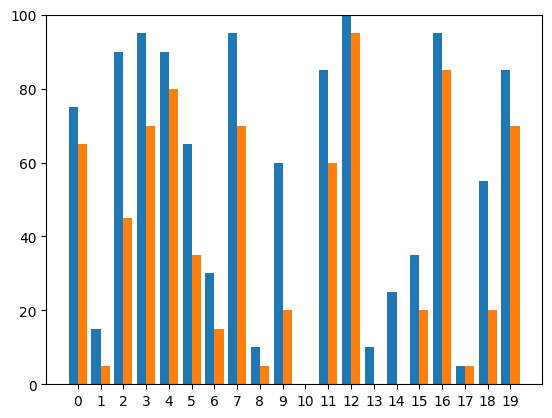

In [29]:
from matplotlib import pyplot as plt
x = np.arange(len(scores_task))
width = 0.4
plt.bar(x-width/2, scores_max_task, width, label='scores_max_task')
plt.bar(x+width/2, scores_task, width, label='scores_task')
plt.xticks(x, task_indices)
plt.ylim(0,100)
plt.show()